# Modelagem preditiva
_Machine Learning_

---

## Sumário

1. **Importação de bibliotecas**
2. **Carregamento da base**
    - 2.1. Carregamento dos dataframes
    - 2.2. Extração de amostra dos dataframes
3. **Preparação dos dados**
    - 3.1. Exibição dos metadados
    - 3.2. Análise de cardinalidade
    - 3.3. Análise de variáveis não numéricas
    - 3.4. Selecionando variáveis não aplicáveis à modelagem
    - 3.5. Segmentação das bases **train** e **test**
    - 3.6. Transformação das features das bases **train** e **test**
4. **Modelagem preditiva**
    - 4.1. Treinamento de N modelos
    - 4.2. Rankeamento dos modelo por score
    - 4.3. Análise gráfica de resíduos x previsões
    - 4.4. Tunagem dos hiperparâmetros do modelo com Optuna
        - 4.4.1. Tunagem do modelo **Bayesian Ridge**
        - 4.4.2. Tunagem do modelo **Linear Regression**
        - 4.4.3. Tunagem do modelo **Huber Regressor**
        - 4.4.4. Tunagem do modelo **Lasso**
        - 4.4.5. Tunagem do modelo **ElasticNet**

<br>

---

<br>

## 1. Importação de bibliotecas

In [63]:
# Importação de pacotes e definição de parâmetros globais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import time
import optuna
import joblib

from sklearn.metrics import (
    make_scorer, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
)
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor, 
                                  BayesianRidge, RANSACRegressor,
                                  TheilSenRegressor)
from optuna.samplers import TPESampler

In [64]:
# Configurações para exibição de dados no Jupyter Notebook

# Configurar opção para exibir todas as linhas do Dataframe
pd.set_option('display.max_rows', None)

# Configurar para exibir o conteúdo completo das colunas
pd.set_option('display.max_colwidth', None)

# Configurar a supressão de mensagens de aviso durante a execução
warnings.filterwarnings('ignore')

# Configurar estilo dos gráficos do Seaborn
sns.set_style('whitegrid')

## 2. Carregamento da base

In [65]:
# Efetuando a limpeza da memória antes do carregamento dos dados

print(f'\nQuantidade de objetos removidos da memória: {gc.collect()}')


Quantidade de objetos removidos da memória: 23601


In [66]:
# Criando um dataframe a partir do arquivo *.csv

df = pd.read_csv('dados/Car_Purchasing_Data_Atualizado.csv', sep=';')
df.head()

,Customer Name,Customer e-mail,Country,Gender,Age,Annual Salary,Credit Card Debt,Net Worth,Car Purchase Amount,debt_to_annual_salary,...,age_adjusted_income,wealth_growth_rate,financial_maturity_index,email_tld,age_range,high_income_flag,high_debt_flag,high_net_worth_flag,high_ppi_flag,financial_status_category
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,USA,0,42,62812.09301,11609.380910,238961.2505,35321.45877,0.184827,...,9692.116370,0.090581,2.717416,edu,35 to 44,0,0,0,0,Moderate
1,Harlan Barnes,eu.dolor@diam.co.uk,USA,0,41,66646.89292,9572.957136,530973.9078,45115.52566,0.143637,...,10408.495986,0.194316,5.829491,uk,35 to 44,0,0,1,1,Moderate
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradipiscing.co.uk,USA,1,43,53798.55112,11160.355060,638467.1773,42925.70921,0.207447,...,8204.202132,0.275994,8.279818,uk,35 to 44,0,0,1,1,Moderate
3,Jade Cunningham,malesuada@dignissim.com,USA,1,58,79370.03798,14426.164850,548599.0524,67422.36313,0.181758,...,10421.796563,0.119171,3.575129,com,55 to 64,1,0,1,0,High Income - Low Debt
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,USA,1,57,59729.15130,5358.712177,560304.0671,55915.46248,0.089717,...,7911.319356,0.164575,4.937235,net,55 to 64,0,0,1,0,Moderate


## 3. Preparação dos dados

### 3.1. Exibição dos metadados

In [67]:
# Função para geração de um dataframe de metadados

def generate_metadata(dataframe):
    '''
    Gera um DataFrame contendo metadados das colunas do DataFrame fornecido.

    :param dataframe: DataFrame
        DataFrame para o qual os metadados serão gerados.
    :return: DataFrame
        DataFrame contendo os metadados.
    '''
    metadata = pd.DataFrame({
        'Variável': dataframe.columns,
        'Tipo': dataframe.dtypes,
        'Qtde de nulos': dataframe.isnull().sum(),
        '% de nulos': round((dataframe.isnull().sum() / len(dataframe)) * 100, 2),
        'Cardinalidade': dataframe.nunique(),
    }).sort_values(by='Qtde de nulos', ascending=False).reset_index(drop=True)

    return metadata

In [68]:
generate_metadata(df)

,Variável,Tipo,Qtde de nulos,% de nulos,Cardinalidade
0,Customer Name,object,0,0.0,498
1,Customer e-mail,object,0,0.0,500
2,Country,object,0,0.0,1
3,Gender,int64,0,0.0,2
4,Age,int64,0,0.0,43
5,Annual Salary,float64,0,0.0,500
6,Credit Card Debt,float64,0,0.0,500
7,Net Worth,float64,0,0.0,500
8,Car Purchase Amount,float64,0,0.0,500
9,debt_to_annual_salary,float64,0,0.0,500


### 3.2. Análise de cardinalidade

In [69]:
# Listando todas as variáveis com cardinalidade inferior a 2

cols_low_cardinality = [col for col in df.columns if df[col].nunique(dropna=False) < 2]
print(cols_low_cardinality)


['Country']


### 3.3. Análise de variáveis não numéricas

In [70]:
# Listando todas as variáveis object e category

cols_text = df.select_dtypes(include=[object, 'category']).columns.tolist()
print(cols_text)

['Customer Name', 'Customer e-mail', 'Country', 'email_tld', 'age_range', 'financial_status_category']


In [71]:
df[cols_text].head()

,Customer Name,Customer e-mail,Country,email_tld,age_range,financial_status_category
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,USA,edu,35 to 44,Moderate
1,Harlan Barnes,eu.dolor@diam.co.uk,USA,uk,35 to 44,Moderate
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradipiscing.co.uk,USA,uk,35 to 44,Moderate
3,Jade Cunningham,malesuada@dignissim.com,USA,com,55 to 64,High Income - Low Debt
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,USA,net,55 to 64,Moderate


In [72]:
# Detectar variáveis binárias (0 ou 1)
binary_cols = [
    col for col in df.columns
    if set(df[col].dropna().unique()) <= {0, 1}
]
print(binary_cols)

# Transformando variáveis binárias (0 ou 1) em categóricas
df[binary_cols] = df[binary_cols].astype('category')

['Gender', 'high_income_flag', 'high_debt_flag', 'high_net_worth_flag', 'high_ppi_flag']


In [73]:
df[binary_cols].head()

,Gender,high_income_flag,high_debt_flag,high_net_worth_flag,high_ppi_flag
0,0,0,0,0,0
1,0,0,0,1,1
2,1,0,0,1,1
3,1,1,0,1,0
4,1,0,0,1,0


### 3.4. Selecionando variáveis não aplicáveis à modelagem

In [74]:
# Separando as variáveis não aplicáveis à modelagem

vars_to_remove = ['Customer Name', 'Customer e-mail', 'Country']
if 'Age' in df.columns and 'age_range' in df.columns:
    vars_to_remove.append('Age')


### 3.5. Segmentação das bases **train** e **test**

In [75]:
# Separando as variáveis preditivas e a variável preditora (alvo)

target = 'Car Purchase Amount'
features = [col for col in df.columns if col not in [target] + vars_to_remove]


In [76]:
# Separação das features e o target
X = df[features]
y = df[target]

# Separação dos dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 3.6. Transformação das features das bases **train** e **test**

In [77]:
# Separando as variáveis numéricas e categóricas

numerical_features = X.select_dtypes(exclude=[object, 'category']).columns
categorical_features = X.select_dtypes(include=[object, 'category']).columns

In [78]:
# Criando o pipeline para as variáveis numéricas
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('variance', VarianceThreshold(threshold=0.0)),
    ('scaler', StandardScaler())
])

# Criando o pipeline para as variáveis categóricas
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [79]:
# Criando o pipeline de pré-processamento que aplica transformações

preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, categorical_features),
    ('num', num_pipeline, numerical_features)
])
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [80]:
# Verificando os shapes antes da transformação

print(f'Shape: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Shape: X_test:  {X_test.shape},  y_test: {y_test.shape}')

Shape: X_train: (400, 26), y_train: (400,)
Shape: X_test:  (100, 26),  y_test: (100,)


In [81]:
# Aplicando o pré-processamento nos conjuntos de treino e teste

X_train_processed = pipeline.fit_transform(X_train, y_train)
X_test_processed = pipeline.transform(X_test)

In [82]:
# Verificando os shapes após transformação

print(f'Shape de X_train após transformação: {X_train_processed.shape}')
print(f'Shape de X_test após transformação:  {X_test_processed.shape}')

Shape de X_train após transformação: (400, 43)
Shape de X_test após transformação:  (100, 43)


## 4. Modelagem preditiva

### 4.1. Treinamento de N modelos

In [83]:
# Definindo os modelos a serem testados

models =  { 
    # Regressão Linear Clássica
    'LinearRegression': LinearRegression(),

    # Regularização
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),

    # Bayesian
    'BayesianRidge': BayesianRidge(),

    # Robustos
    'HuberRegressor': HuberRegressor(),
    'RANSACRegressor': RANSACRegressor(estimator=LinearRegression()),
    'TheilSenRegressor': TheilSenRegressor(),
}


In [84]:
def models_evaluation(models, X_train, y_train, X_test, y_test, preprocessor, cv_splits=5):
    '''
    Avalia modelos de aprendizado de máquina, calculando métricas de desempenho 
    no conjunto de treino e teste.

    :param models: dict
        Dicionário contendo os modelos a serem avaliados.
    :param X_train: DataFrame
        Conjunto de dados de treino com as variáveis independentes.
    :param y_train: Series
        Variável dependente para o conjunto de treino.
    :param X_test: DataFrame
        Conjunto de dados de teste com as variáveis independentes.
    :param y_test: Series
        Variável dependente para o conjunto de teste.
    :param preprocessor: ColumnTransformer
        Objeto de pré-processamento que será aplicado aos dados antes do treinamento do modelo.
    :param cv_splits: int, default=5
        Número de divisões (folds) para a validação cruzada (K-Fold).

    :return: list
        Lista contendo os resultados de avaliação de cada modelo, métricas para treino 
        e teste, além do tempo de execução.
    '''
    results = []
    
    # Inicializa o esquema de validação cruzada
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    
    # Define métricas de avaliação (valores negativos são convertidos depois)
    scoring = {
        'MAE': 'neg_mean_absolute_error',
        'RMSE': 'neg_root_mean_squared_error',
        'R2': 'r2'
    }
    
    # Loop pelos modelos a serem avaliados
    for model_name, model in models.items():
        # Cria um pipeline que combina o pré-processamento e o modelo
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
        
        # Registra o tempo de início
        start_time = time.time()
        
        # Executa validação cruzada no pipeline
        cv_results = cross_validate(
            pipeline, X_train, y_train,
            cv=kf, scoring=scoring, n_jobs=-1, return_train_score=False
        )
        
        # Calcula médias das métricas (convertendo para valores positivos)
        mean_cv_mae = -np.mean(cv_results['test_MAE'])
        mean_cv_rmse = -np.mean(cv_results['test_RMSE'])
        mean_cv_r2 = np.mean(cv_results['test_R2'])
        
        # Ajusta o modelo final em todos os dados de treino
        pipeline.fit(X_train, y_train)
        
        # Gera previsões no conjunto de teste
        preds = pipeline.predict(X_test)
        
        # Métricas no teste
        test_rmse = np.sqrt(mean_squared_error(y_test, preds))
        test_mae = mean_absolute_error(y_test, preds)
        test_r2 = r2_score(y_test, preds)
        
        # Calcula tempo total de execução
        elapsed = time.time() - start_time
        
        # Guarda resultados
        results.append({
            'Model': model_name,
            'CV_RMSE': mean_cv_rmse,
            'Test_RMSE': test_rmse,
            'CV_MAE': mean_cv_mae,
            'Test_MAE': test_mae,
            'CV_R2': mean_cv_r2,            
            'Test_R2': test_r2,
            'Time (s)': round(elapsed, 4)
        })
        
    return results

### 4.2. Rankeamento dos modelo por score

In [85]:
def zscore_norm(series):
    '''
    Normalização Z-score: (x - média) / desvio padrão

    :param series: pd.Series
        Série numérica a ser normalizada.

    :return: pd.Series or float
        Série normalizada usando Z-score.
        Retorna 0.0 caso desvio padrão seja zero (todos iguais).
    '''
    if series.std() == 0:
        return pd.Series(0.0, index=series.index)
    
    return (series - series.mean()) / series.std()


def add_final_score(df, w_mae=0.80, w_time=0.20):
    '''
    Adiciona colunas normalizadas e calcula um ranking Final_Score
    usando Z-score utilizando pesos proporcionais.

    :param df: pd.DataFrame
        DataFrame contendo as métricas dos modelos.
    :param w_mae: float, default=0.80
        Peso atribuído à métrica MAE na composição do score final.
    :param w_time: float, default=0.20
        Peso atribuído ao tempo de execução na composição do score final.   

    :return: pd.DataFrame
        DataFrame com colunas normalizadas e ranking Final_Score.
    '''

    # Normalização robusta
    df['MAE_norm'] = zscore_norm(df['Test_MAE'])
    df['Time_norm'] = zscore_norm(df['Time (s)'])

    # Score final (menor = melhor)
    df['Final_Score'] = (
        w_mae * df['MAE_norm'] +
        w_time * df['Time_norm']
    )

    # Ordenação para ranking
    df.sort_values('Final_Score', ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [86]:
# Avaliando os modelos
results = models_evaluation(models, X_train, y_train, X_test, y_test, preprocessor)

# Criando DataFrame de resultados
df_ranked = pd.DataFrame(results)

# Adicionando o score final ao DataFrame de resultados
df_ranked_default = add_final_score(df_ranked)

# Colunas recomendadas para análise e gráficos
df_ranked_default[['Model','CV_MAE','Test_MAE','Time (s)','MAE_norm','Time_norm','Final_Score']]

,Model,CV_MAE,Test_MAE,Time (s),MAE_norm,Time_norm,Final_Score
0,RANSACRegressor,558.515386,387.662645,0.0803,-0.596129,-0.351602,-0.547224
1,LinearRegression,655.449819,561.578690,0.0545,-0.409502,-0.365131,-0.400628
2,BayesianRidge,646.176425,588.939077,0.0530,-0.380142,-0.365917,-0.377297
3,HuberRegressor,755.852265,738.217539,0.1135,-0.219954,-0.334193,-0.242802
4,Lasso,781.968040,783.743438,0.0888,-0.171101,-0.347145,-0.206310
5,Ridge,842.932178,879.050373,0.0804,-0.068828,-0.351549,-0.125373
6,TheilSenRegressor,589.273761,398.076647,5.4702,-0.584954,2.474742,0.026985
7,ElasticNet,3111.124014,3208.260115,0.0658,2.430610,-0.359205,1.872647


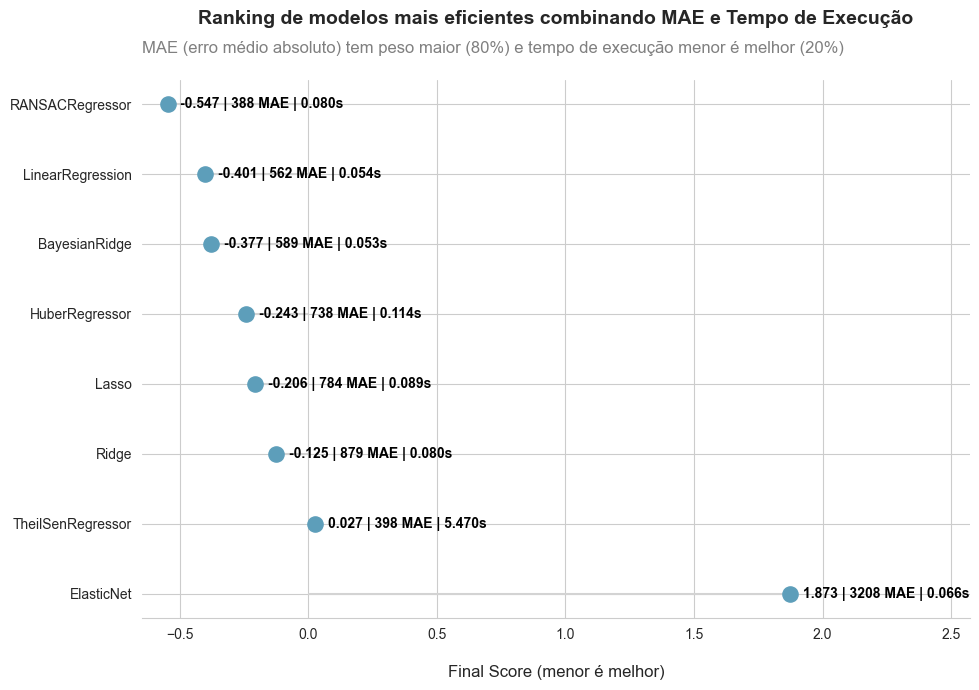

In [87]:
# Ordenar os modelos pelo Final_Score para o gráfico
df_plot = df_ranked_default.sort_values(by='Final_Score', ascending=False)

# Figura e eixo
fig, ax = plt.subplots(figsize=(10, 7))

# Linha horizontal
ax.hlines(y=df_plot['Model'], xmin=df_plot['Final_Score'], xmax=0,
    color='lightgray', linewidth=1.5)

# Pontos no valor real
ax.scatter(df_plot['Final_Score'], df_plot['Model'], 
           color='#5d9eba', s=120, zorder=3)

# Adicionar texto com MAE e tempo
for score, mae, time_s, model in zip(
    df_plot['Final_Score'], df_plot['Test_MAE'], df_plot['Time (s)'], df_plot['Model']):
    ax.text(score + 0.05, model, f'{score:.3f} | {mae:.0f} MAE | {time_s:.3f}s',
        fontweight='bold', va='center', fontsize=10, color='#000000')

# Título e labels
ax.set_title('Ranking de modelos mais eficientes combinando MAE e Tempo de Execução',
             fontsize=14, fontweight='bold', pad=40)
ax.set_xlabel('\nFinal Score (menor é melhor)', fontsize=12)
ax.set_ylabel('')

# Subtítulo explicativo
ax.text(0, 1.05, 
        'MAE (erro médio absoluto) tem peso maior (80%) e tempo de execução menor é melhor (20%)',
        fontsize=12, color='gray', ha='left', transform=ax.transAxes)

# Ajuste de eixo para não cortar textos
ax.set_xlim(df_plot['Final_Score'].min() - 0.1,
            df_plot['Final_Score'].max() + 0.7)
#ax.tick_params(labelsize=10)

# limpar borda superior e direita
sns.despine(left=True, bottom=False) 

# Ajuste final do layout para evitar sobreposição
plt.tight_layout()

# Exibição do gráfico
plt.show()


### 4.3. Análise gráfica de resíduos x previsões

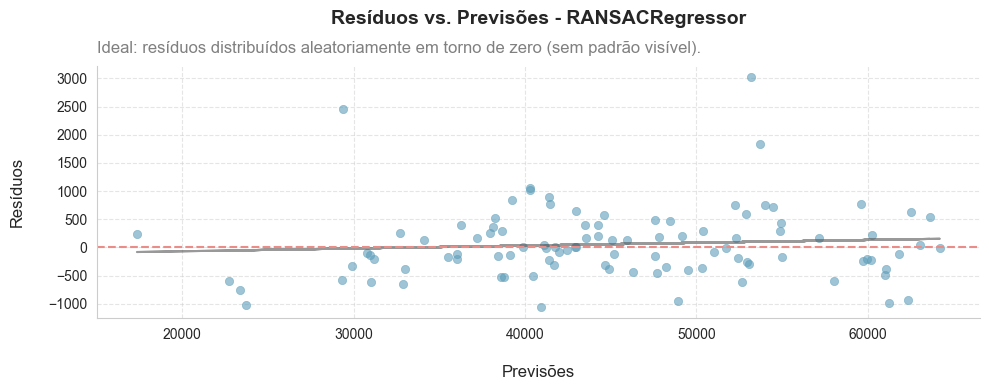

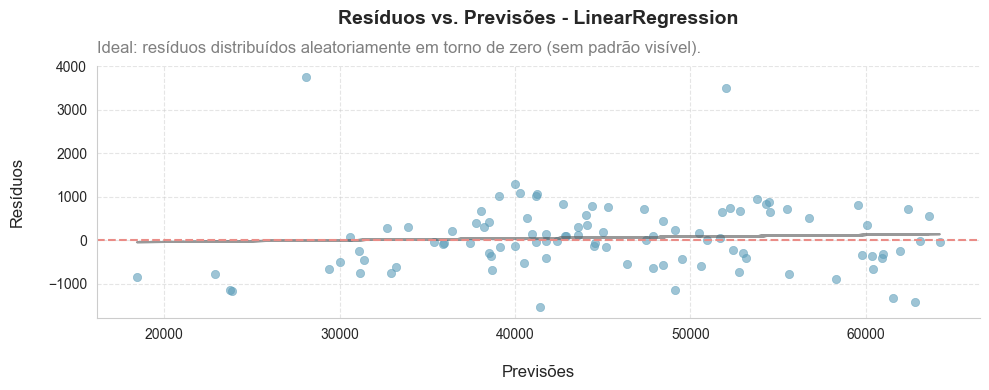

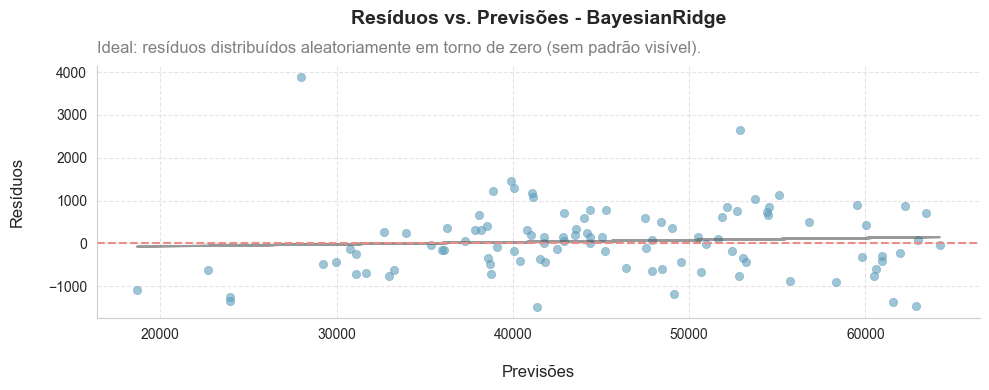

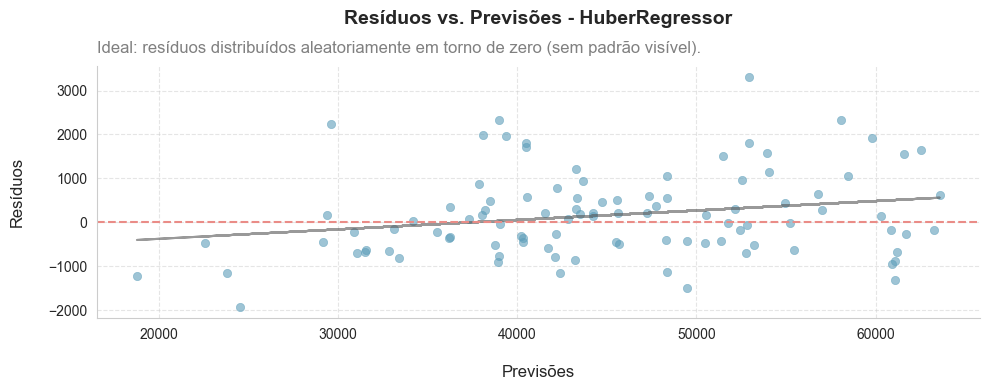

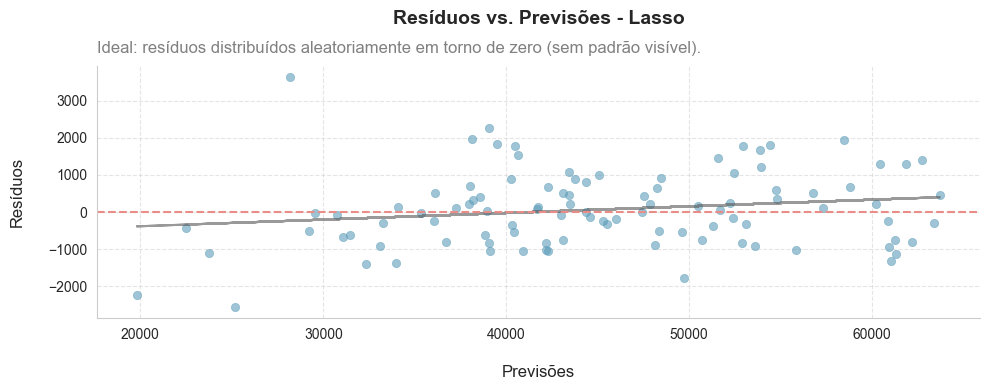

In [88]:
# Ordenar pelos menores Final_Score e pegar os 5 primeiros modelos
top_models = df_ranked.sort_values('Final_Score').head(5)['Model'].tolist()

# Loop para ajustar cada modelo e gerar o gráfico de resíduos
for model_name in top_models:
    
    # Seleção do modelo atual
    model = models[model_name]
    # Criação do pipeline com pré-processamento e modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    # Treinamento do pipeline com os dados de treino
    pipeline.fit(X_train, y_train)
    # Geração das previsões com os dados de teste
    preds = pipeline.predict(X_test)
    # Cálculo dos resíduos (diferença entre valor real e previsto)
    residuals = y_test - preds

    # Ajuste do tamanho da figura
    fig, ax = plt.subplots(figsize=(10, 4))

    # Gráfico de dispersão dos resíduos em função das previsões
    sns.scatterplot(x=preds, y=residuals, color='#5d9eba', alpha=0.6, edgecolor=None, ax=ax)

    # Linha de tendência dos resíduos
    trend_model = LinearRegression()
    trend_model.fit(preds.reshape(-1, 1), residuals)
    trend_line = trend_model.predict(preds.reshape(-1, 1))
    ax.plot(preds, trend_line, color='#555555', linestyle='-', linewidth=1.5, alpha=0.6)

    # Linha horizontal representando o ponto de resíduo zero
    ax.axhline(0, color='#ea8c87', linestyle='--', linewidth=1.5)

    # Título do gráfico com destaque
    ax.set_title(f'Resíduos vs. Previsões - {model_name}\n', fontsize=14, fontweight='bold', pad=15)  
    # Rótulo do eixo X
    ax.set_xlabel('\nPrevisões', fontsize=12)
    # Rótulo do eixo Y
    ax.set_ylabel('Resíduos\n', fontsize=12)

    # Subtítulo explicativo
    ax.text(0, 1.05, 
        'Ideal: resíduos distribuídos aleatoriamente em torno de zero (sem padrão visível).',
        fontsize=12, color='gray', ha='left', transform=ax.transAxes)
    
    # Exibição da grade para melhor leitura dos dados
    ax.grid(True, linestyle='--', alpha=0.5)
    # Ajuste dos tamanhos dos ticks
    ax.tick_params(labelsize=10)
    # Remover bordas desnecessárias
    sns.despine(right=True, top=True)

    # Ajuste final do layout para evitar sobreposição
    fig.tight_layout()
    # Exibição do gráfico
    plt.show()


### 4.4. Tunagem dos hiperparâmetros do modelo com Optuna

#### 4.4.1. Tunagem do modelo **RANSACRegressor**

In [89]:
def objective_ransac(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo RANSACRegressor usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado por validação cruzada para o modelo treinado.
    '''

    model = RANSACRegressor(
        estimator=LinearRegression(),
        min_samples=trial.suggest_float('min_samples', 0.1, 1.0),
        residual_threshold=trial.suggest_float('residual_threshold', 1e-3, 10.0, log=True),
        max_trials=trial.suggest_int('max_trials', 50, 500),
        stop_probability=trial.suggest_float('stop_probability', 0.9, 1.0),
        stop_score=trial.suggest_float('stop_score', 0.0, 1.0),
        loss=trial.suggest_categorical('loss', ['absolute_error', 'squared_error']),
        random_state=42
    )

    # Pipeline com pré-processamento
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Validação cruzada k-fold
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Usamos MAE negativo porque Optuna minimiza a função
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Avaliação com cross-validation
    scores = cross_val_score(
        pipeline,
        X_train, y_train,
        cv=cv,
        scoring=mae_scorer,
        n_jobs=-1
    )

    # Retorna o MAE positivo
    return -scores.mean()


In [90]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_ransac, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-12-01 16:26:48,593] A new study created in memory with name: no-name-0c60d44c-6ab4-4b28-8ad2-8487ab78aa97
Best trial: 3. Best value: 10685.4:   5%|▌         | 5/100 [00:00<00:05, 17.86it/s, 0.30/1800 seconds]

[I 2025-12-01 16:26:48,677] Trial 0 finished with value: 15742.251832868229 and parameters: {'min_samples': 0.28186051636710735, 'residual_threshold': 0.0015555190861513532, 'max_trials': 100, 'stop_probability': 0.945541003479826, 'stop_score': 0.3962856948026605, 'loss': 'squared_error'}. Best is trial 0 with value: 15742.251832868229.
[I 2025-12-01 16:26:48,712] Trial 1 finished with value: 11992.255920272903 and parameters: {'min_samples': 0.4209009105854098, 'residual_threshold': 4.382032050090032, 'max_trials': 428, 'stop_probability': 0.9671737787892214, 'stop_score': 0.9042284284802448, 'loss': 'squared_error'}. Best is trial 1 with value: 11992.255920272903.
[I 2025-12-01 16:26:48,783] Trial 3 finished with value: 10685.37541346557 and parameters: {'min_samples': 0.24445724680737768, 'residual_threshold': 1.522840552286417, 'max_trials': 470, 'stop_probability': 0.9654708044314383, 'stop_score': 0.675078873652343, 'loss': 'absolute_error'}. Best is trial 3 with value: 10685.37

Best trial: 7. Best value: 8978.19:  10%|█         | 10/100 [00:00<00:04, 21.42it/s, 0.51/1800 seconds]

[I 2025-12-01 16:26:48,926] Trial 6 finished with value: 16345.878779959032 and parameters: {'min_samples': 0.5675880557102089, 'residual_threshold': 0.0353732564736982, 'max_trials': 143, 'stop_probability': 0.9538889460896686, 'stop_score': 0.9887179429353318, 'loss': 'squared_error'}. Best is trial 3 with value: 10685.37541346557.
[I 2025-12-01 16:26:48,992] Trial 7 finished with value: 8978.190016607006 and parameters: {'min_samples': 0.29372615096924637, 'residual_threshold': 4.044974023642337, 'max_trials': 64, 'stop_probability': 0.9953847869663741, 'stop_score': 0.8109237626762017, 'loss': 'absolute_error'}. Best is trial 7 with value: 8978.190016607006.
[I 2025-12-01 16:26:49,011] Trial 8 finished with value: 16345.878779959032 and parameters: {'min_samples': 0.606716346319536, 'residual_threshold': 0.002932374484195699, 'max_trials': 382, 'stop_probability': 0.9854590708453788, 'stop_score': 0.18410315321068882, 'loss': 'squared_error'}. Best is trial 7 with value: 8978.19001

Best trial: 7. Best value: 8978.19:  15%|█▌        | 15/100 [00:00<00:03, 21.78it/s, 0.66/1800 seconds]

[I 2025-12-01 16:26:49,141] Trial 11 finished with value: 22799.36498245794 and parameters: {'min_samples': 0.9226947661376788, 'residual_threshold': 0.0018332377375847204, 'max_trials': 189, 'stop_probability': 0.9119694733866045, 'stop_score': 0.14013327053030833, 'loss': 'absolute_error'}. Best is trial 7 with value: 8978.190016607006.
[I 2025-12-01 16:26:49,163] Trial 12 finished with value: 9473.361677953359 and parameters: {'min_samples': 0.41966941789986634, 'residual_threshold': 0.6494694533406878, 'max_trials': 429, 'stop_probability': 0.9832971740080082, 'stop_score': 0.44717345526117047, 'loss': 'absolute_error'}. Best is trial 7 with value: 8978.190016607006.
[I 2025-12-01 16:26:49,201] Trial 13 finished with value: 13326.209826935557 and parameters: {'min_samples': 0.5887234116620781, 'residual_threshold': 0.8950374760582409, 'max_trials': 433, 'stop_probability': 0.9920475797896064, 'stop_score': 0.29460101753086065, 'loss': 'squared_error'}. Best is trial 7 with value: 8

Best trial: 7. Best value: 8978.19:  19%|█▉        | 19/100 [00:00<00:03, 25.13it/s, 0.89/1800 seconds]

[W 2025-12-01 16:26:49,323] Trial 2 failed with value np.float64(nan).
[I 2025-12-01 16:26:49,328] Trial 16 finished with value: 16858.46511204586 and parameters: {'min_samples': 0.38355240232151955, 'residual_threshold': 0.23427542144404503, 'max_trials': 300, 'stop_probability': 0.9997680087236183, 'stop_score': 0.37694529514790703, 'loss': 'absolute_error'}. Best is trial 7 with value: 8978.190016607006.
[I 2025-12-01 16:26:49,422] Trial 17 finished with value: 11319.341599222742 and parameters: {'min_samples': 0.41860751192938045, 'residual_threshold': 0.25574340008769936, 'max_trials': 272, 'stop_probability': 0.997430670211045, 'stop_score': 0.6532012433877059, 'loss': 'absolute_error'}. Best is trial 7 with value: 8978.190016607006.
[I 2025-12-01 16:26:49,455] Trial 19 finished with value: 17521.8355224081 and parameters: {'min_samples': 0.1197311685682062, 'residual_threshold': 0.20878769076356934, 'max_trials': 348, 'stop_probability': 0.9804506562568016, 'stop_score': 0.53731

Best trial: 25. Best value: 8080.84:  24%|██▍       | 24/100 [00:01<00:03, 19.89it/s, 1.06/1800 seconds]

[I 2025-12-01 16:26:49,511] Trial 21 finished with value: 9841.851774893654 and parameters: {'min_samples': 0.1100338392175858, 'residual_threshold': 2.8039672320171376, 'max_trials': 69, 'stop_probability': 0.9795777467796782, 'stop_score': 0.5245858401293004, 'loss': 'absolute_error'}. Best is trial 7 with value: 8978.190016607006.
[I 2025-12-01 16:26:49,542] Trial 20 finished with value: 15165.877695611784 and parameters: {'min_samples': 0.1346138804097063, 'residual_threshold': 0.20954723452419843, 'max_trials': 351, 'stop_probability': 0.981704174522044, 'stop_score': 0.5594142807225787, 'loss': 'absolute_error'}. Best is trial 7 with value: 8978.190016607006.
[I 2025-12-01 16:26:49,563] Trial 22 finished with value: 10130.518783919533 and parameters: {'min_samples': 0.6818735168447021, 'residual_threshold': 2.4099075951061475, 'max_trials': 54, 'stop_probability': 0.9806494071654022, 'stop_score': 0.5521195329822578, 'loss': 'absolute_error'}. Best is trial 7 with value: 8978.190

Best trial: 29. Best value: 7775.45:  30%|███       | 30/100 [00:01<00:02, 26.66it/s, 1.31/1800 seconds]

[I 2025-12-01 16:26:49,692] Trial 25 finished with value: 8080.8444420708065 and parameters: {'min_samples': 0.30998796994072786, 'residual_threshold': 7.846195516962016, 'max_trials': 106, 'stop_probability': 0.9908171148399152, 'stop_score': 0.005363522602143955, 'loss': 'absolute_error'}. Best is trial 25 with value: 8080.8444420708065.
[I 2025-12-01 16:26:49,734] Trial 26 finished with value: 8065.668385699733 and parameters: {'min_samples': 0.4999670599797973, 'residual_threshold': 7.470856573285894, 'max_trials': 111, 'stop_probability': 0.9708651754454983, 'stop_score': 0.2363421974580847, 'loss': 'absolute_error'}. Best is trial 26 with value: 8065.668385699733.
[I 2025-12-01 16:26:49,784] Trial 29 finished with value: 7775.448242637748 and parameters: {'min_samples': 0.31452547818624643, 'residual_threshold': 8.670314974521084, 'max_trials': 108, 'stop_probability': 0.9917119769527143, 'stop_score': 0.43611242515638127, 'loss': 'absolute_error'}. Best is trial 29 with value: 7

[I 2025-12-01 16:26:49,967] Trial 32 finished with value: 4596.535049482596 and parameters: {'min_samples': 0.49097336168608646, 'residual_threshold': 9.787083883641957, 'max_trials': 183, 'stop_probability': 0.9714361940200945, 'stop_score': 0.01906192928821252, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:50,004] Trial 30 finished with value: 8860.132819442766 and parameters: {'min_samples': 0.5001533638917612, 'residual_threshold': 5.916241999994072, 'max_trials': 128, 'stop_probability': 0.9603104596815984, 'stop_score': 0.04052221147085181, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:50,011] Trial 31 finished with value: 6936.706233640145 and parameters: {'min_samples': 0.4959708629414874, 'residual_threshold': 8.464223110722447, 'max_trials': 120, 'stop_probability': 0.9715808381662344, 'stop_score': 0.031454923710848855, 'loss': 'absolute_error'}. Best is trial 32 with value: 459

Best trial: 32. Best value: 4596.54:  40%|████      | 40/100 [00:01<00:02, 22.08it/s, 1.74/1800 seconds]

[I 2025-12-01 16:26:50,110] Trial 36 finished with value: 5465.198623521622 and parameters: {'min_samples': 0.3560750479235074, 'residual_threshold': 9.02968060086792, 'max_trials': 192, 'stop_probability': 0.9706066367208182, 'stop_score': 0.05724456644061089, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:50,152] Trial 35 finished with value: 9422.46849030033 and parameters: {'min_samples': 0.3118597340717974, 'residual_threshold': 9.915422472350551, 'max_trials': 180, 'stop_probability': 0.9603589646427098, 'stop_score': 0.023887572481356006, 'loss': 'squared_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:50,287] Trial 37 finished with value: 11852.872241950226 and parameters: {'min_samples': 0.6495780394059221, 'residual_threshold': 1.3383938212442634, 'max_trials': 188, 'stop_probability': 0.9333826286789769, 'stop_score': 0.0911208827037839, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.5

Best trial: 32. Best value: 4596.54:  44%|████▍     | 44/100 [00:01<00:02, 27.08it/s, 1.95/1800 seconds]

[I 2025-12-01 16:26:50,349] Trial 38 finished with value: 10758.972014236544 and parameters: {'min_samples': 0.6496120291019961, 'residual_threshold': 1.5762668214314124, 'max_trials': 181, 'stop_probability': 0.9656491048057743, 'stop_score': 0.08545851472752503, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:50,383] Trial 41 finished with value: 9186.489269792542 and parameters: {'min_samples': 0.46832387289449856, 'residual_threshold': 4.774021804810782, 'max_trials': 223, 'stop_probability': 0.9439095199612855, 'stop_score': 0.11037812019628895, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:50,498] Trial 44 finished with value: 15678.920511650742 and parameters: {'min_samples': 0.7531740029291845, 'residual_threshold': 3.348790181546503, 'max_trials': 155, 'stop_probability': 0.9737311168447398, 'stop_score': 0.18537340896137122, 'loss': 'squared_error'}. Best is trial 32 with value: 45

Best trial: 32. Best value: 4596.54:  49%|████▉     | 49/100 [00:02<00:02, 21.89it/s, 2.13/1800 seconds]

[I 2025-12-01 16:26:50,571] Trial 43 finished with value: 9183.12737316246 and parameters: {'min_samples': 0.7726951246434772, 'residual_threshold': 4.630603123966716, 'max_trials': 159, 'stop_probability': 0.9482752035085864, 'stop_score': 0.17657962275418962, 'loss': 'squared_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:50,593] Trial 42 finished with value: 9125.718396234222 and parameters: {'min_samples': 0.45870078687031807, 'residual_threshold': 1.6448654114711598, 'max_trials': 223, 'stop_probability': 0.9712052378831584, 'stop_score': 0.08400517265243629, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:50,648] Trial 47 finished with value: 9191.105974874392 and parameters: {'min_samples': 0.1900716715198264, 'residual_threshold': 4.292512467583913, 'max_trials': 162, 'stop_probability': 0.970265104919307, 'stop_score': 0.18848203166486427, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.5

Best trial: 32. Best value: 4596.54:  55%|█████▌    | 55/100 [00:02<00:01, 23.99it/s, 2.39/1800 seconds]

[I 2025-12-01 16:26:50,726] Trial 50 finished with value: 5769.775032916742 and parameters: {'min_samples': 0.3739642565371903, 'residual_threshold': 6.1372677102794695, 'max_trials': 80, 'stop_probability': 0.9551031455357603, 'stop_score': 0.05551515573961748, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:50,839] Trial 51 finished with value: 9665.525998893383 and parameters: {'min_samples': 0.3680429590167613, 'residual_threshold': 2.1601196351282956, 'max_trials': 81, 'stop_probability': 0.963565217977594, 'stop_score': 0.2582549684292953, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:50,855] Trial 52 finished with value: 20800.27411308646 and parameters: {'min_samples': 0.3781963631456458, 'residual_threshold': 0.07284416805505294, 'max_trials': 87, 'stop_probability': 0.9635646774828666, 'stop_score': 0.048464045892150295, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.

Best trial: 32. Best value: 4596.54:  59%|█████▉    | 59/100 [00:02<00:01, 22.36it/s, 2.61/1800 seconds]

[I 2025-12-01 16:26:51,039] Trial 55 finished with value: 8202.592946275112 and parameters: {'min_samples': 0.34926264853766176, 'residual_threshold': 6.705919184305691, 'max_trials': 90, 'stop_probability': 0.9559928847173, 'stop_score': 0.05561610589294089, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:51,064] Trial 56 finished with value: 5982.9376915642715 and parameters: {'min_samples': 0.3419878972507832, 'residual_threshold': 9.635068591775989, 'max_trials': 130, 'stop_probability': 0.952154417308816, 'stop_score': 0.31158903226196943, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:51,113] Trial 57 finished with value: 9666.69724044624 and parameters: {'min_samples': 0.26404854280140333, 'residual_threshold': 7.326447344085443, 'max_trials': 128, 'stop_probability': 0.9556392204228804, 'stop_score': 0.05632937943737956, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535

Best trial: 32. Best value: 4596.54:  65%|██████▌   | 65/100 [00:02<00:01, 21.56it/s, 2.82/1800 seconds]

[I 2025-12-01 16:26:51,199] Trial 60 finished with value: 13397.496004101145 and parameters: {'min_samples': 0.548806241755167, 'residual_threshold': 6.772320213076516, 'max_trials': 130, 'stop_probability': 0.9557040179800143, 'stop_score': 0.3173354432132971, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:51,244] Trial 61 finished with value: 21092.783139529656 and parameters: {'min_samples': 0.5525736855279211, 'residual_threshold': 0.009507993489407878, 'max_trials': 203, 'stop_probability': 0.9233585807318078, 'stop_score': 0.3268588488844465, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:51,326] Trial 64 finished with value: 13226.627270260851 and parameters: {'min_samples': 0.40769876732805765, 'residual_threshold': 2.0176182895237202, 'max_trials': 199, 'stop_probability': 0.9674871813728689, 'stop_score': 0.11615083273552759, 'loss': 'absolute_error'}. Best is trial 32 with value: 

Best trial: 32. Best value: 4596.54:  69%|██████▉   | 69/100 [00:03<00:01, 21.23it/s, 3.09/1800 seconds]

[I 2025-12-01 16:26:51,520] Trial 66 finished with value: 8124.7356773215115 and parameters: {'min_samples': 0.43994553889125404, 'residual_threshold': 3.2170422790770843, 'max_trials': 248, 'stop_probability': 0.9860208419448769, 'stop_score': 0.6134436311973361, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:51,540] Trial 67 finished with value: 6261.287041955175 and parameters: {'min_samples': 0.325378952339865, 'residual_threshold': 8.847674105894598, 'max_trials': 257, 'stop_probability': 0.9865624935549256, 'stop_score': 0.4339618555530098, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:51,576] Trial 69 finished with value: 9051.190914687328 and parameters: {'min_samples': 0.4473118364970403, 'residual_threshold': 6.024610622179237, 'max_trials': 247, 'stop_probability': 0.9766969097484479, 'stop_score': 0.6145927340338165, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.5

[I 2025-12-01 16:26:51,702] Trial 70 finished with value: 9067.767145249678 and parameters: {'min_samples': 0.46035413631929645, 'residual_threshold': 9.572166818752486, 'max_trials': 167, 'stop_probability': 0.9764865847640973, 'stop_score': 0.3971970119010209, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:51,714] Trial 71 finished with value: 7012.978241518297 and parameters: {'min_samples': 0.2751885066384263, 'residual_threshold': 9.809946585429724, 'max_trials': 286, 'stop_probability': 0.9759890097754542, 'stop_score': 0.4774623772294317, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:51,782] Trial 72 finished with value: 7999.855483096109 and parameters: {'min_samples': 0.28078187449471187, 'residual_threshold': 5.8337087440232045, 'max_trials': 279, 'stop_probability': 0.9690833393557858, 'stop_score': 0.47998691187727066, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596

Best trial: 32. Best value: 4596.54:  79%|███████▉  | 79/100 [00:03<00:01, 19.80it/s, 3.48/1800 seconds]

[I 2025-12-01 16:26:51,931] Trial 74 finished with value: 18792.361988633173 and parameters: {'min_samples': 0.38989938620594633, 'residual_threshold': 0.15653542789804759, 'max_trials': 239, 'stop_probability': 0.9885322804563214, 'stop_score': 0.3915913028567118, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:51,967] Trial 75 finished with value: 6870.646606458412 and parameters: {'min_samples': 0.5948021043778279, 'residual_threshold': 7.057210678300362, 'max_trials': 262, 'stop_probability': 0.9859722073637477, 'stop_score': 0.7219249745292649, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:51,983] Trial 77 finished with value: 5976.3030497803065 and parameters: {'min_samples': 0.6051643959053065, 'residual_threshold': 9.917607269323224, 'max_trials': 260, 'stop_probability': 0.9002236865110718, 'stop_score': 0.722157425340858, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596

Best trial: 32. Best value: 4596.54:  85%|████████▌ | 85/100 [00:03<00:00, 24.37it/s, 3.78/1800 seconds]

[I 2025-12-01 16:26:52,192] Trial 81 finished with value: 11005.44857579036 and parameters: {'min_samples': 0.5263259436998045, 'residual_threshold': 3.6596863457160347, 'max_trials': 313, 'stop_probability': 0.9461606835351347, 'stop_score': 0.9909932730970372, 'loss': 'squared_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:52,224] Trial 82 finished with value: 11765.14344476554 and parameters: {'min_samples': 0.9893596195334151, 'residual_threshold': 3.657037733536152, 'max_trials': 305, 'stop_probability': 0.9002897318094234, 'stop_score': 0.8554127300431922, 'loss': 'squared_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:52,195] Trial 80 finished with value: 8589.971865268315 and parameters: {'min_samples': 0.5251957050481572, 'residual_threshold': 3.7565854281577065, 'max_trials': 304, 'stop_probability': 0.9032963444427106, 'stop_score': 0.9353650769576323, 'loss': 'squared_error'}. Best is trial 32 with value: 4596.5350

Best trial: 32. Best value: 4596.54:  88%|████████▊ | 88/100 [00:03<00:00, 24.22it/s, 3.96/1800 seconds]

[I 2025-12-01 16:26:52,389] Trial 87 finished with value: 9186.489269792542 and parameters: {'min_samples': 0.467748769504152, 'residual_threshold': 5.006220909828146, 'max_trials': 325, 'stop_probability': 0.9945077845606456, 'stop_score': 0.773173217024526, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:52,433] Trial 85 finished with value: 7434.933811509242 and parameters: {'min_samples': 0.6185435085857773, 'residual_threshold': 5.246208862608125, 'max_trials': 215, 'stop_probability': 0.9944515578893619, 'stop_score': 0.795378467166016, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:52,551] Trial 86 finished with value: 11899.065458227504 and parameters: {'min_samples': 0.24022980476057404, 'residual_threshold': 5.83075021611341, 'max_trials': 175, 'stop_probability': 0.9934281784650482, 'stop_score': 0.5779513884057235, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.53504

Best trial: 32. Best value: 4596.54:  93%|█████████▎| 93/100 [00:04<00:00, 22.22it/s, 4.12/1800 seconds]

[I 2025-12-01 16:26:52,557] Trial 89 finished with value: 5821.4910344537075 and parameters: {'min_samples': 0.8585637390266408, 'residual_threshold': 9.883812646425895, 'max_trials': 216, 'stop_probability': 0.9834889921283511, 'stop_score': 0.5773520097672684, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:52,579] Trial 91 finished with value: 7607.344761199851 and parameters: {'min_samples': 0.3859630134113165, 'residual_threshold': 9.446355800497535, 'max_trials': 198, 'stop_probability': 0.9221371144746654, 'stop_score': 0.5731706949913642, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:52,644] Trial 92 finished with value: 6781.328549348073 and parameters: {'min_samples': 0.9361586536171428, 'residual_threshold': 9.764779283548718, 'max_trials': 196, 'stop_probability': 0.9215707967148392, 'stop_score': 0.6642780464840623, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.53

Best trial: 32. Best value: 4596.54:  99%|█████████▉| 99/100 [00:04<00:00, 20.27it/s, 4.39/1800 seconds]

[I 2025-12-01 16:26:52,797] Trial 94 finished with value: 13329.117327988908 and parameters: {'min_samples': 0.8296587504708921, 'residual_threshold': 2.6701338503319856, 'max_trials': 235, 'stop_probability': 0.9822883834651805, 'stop_score': 0.5163248191441404, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:52,802] Trial 96 finished with value: 16851.86602499249 and parameters: {'min_samples': 0.9027034587868635, 'residual_threshold': 2.612179493367, 'max_trials': 499, 'stop_probability': 0.9607100106178632, 'stop_score': 0.5042509337448281, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.
[I 2025-12-01 16:26:52,834] Trial 95 finished with value: 8985.859100253083 and parameters: {'min_samples': 0.9022812721421936, 'residual_threshold': 9.929066466331506, 'max_trials': 237, 'stop_probability': 0.9218103660401088, 'stop_score': 0.6806210354904488, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.5350

Best trial: 32. Best value: 4596.54: 100%|██████████| 100/100 [00:04<00:00, 22.74it/s, 4.40/1800 seconds]

[I 2025-12-01 16:26:52,995] Trial 99 finished with value: 6844.848657436689 and parameters: {'min_samples': 0.9606816223639809, 'residual_threshold': 7.87834058381439, 'max_trials': 187, 'stop_probability': 0.9151899301741118, 'stop_score': 0.12763249137353233, 'loss': 'absolute_error'}. Best is trial 32 with value: 4596.535049482596.


In [91]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_ransac = study.best_value
params_ransac = study.best_params

print(f'Melhores hiperparâmetros: {params_ransac}')
print(f'\nMelhor MAE: {mae_ransac:.4f}')

Melhores hiperparâmetros: {'min_samples': 0.49097336168608646, 'residual_threshold': 9.787083883641957, 'max_trials': 183, 'stop_probability': 0.9714361940200945, 'stop_score': 0.01906192928821252, 'loss': 'absolute_error'}

Melhor MAE: 4596.5350


#### 4.4.2. Tunagem do modelo **Bayesian Ridge**

In [92]:
def objective_bayesianridge(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo BayesianRidge usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    model = BayesianRidge(
        max_iter=trial.suggest_int('max_iter', 100, 500),
        tol=trial.suggest_float('tol', 1e-5, 1e-2, log=True),
        alpha_1=trial.suggest_float('alpha_1', 1e-8, 1e-3, log=True),
        alpha_2=trial.suggest_float('alpha_2', 1e-8, 1e-3, log=True),
        lambda_1=trial.suggest_float('lambda_1', 1e-8, 1e-3, log=True),
        lambda_2=trial.suggest_float('lambda_2', 1e-8, 1e-3, log=True),
        fit_intercept=True,
        compute_score=False,
        copy_X=True,
        verbose=False
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Validação cruzada k-fold
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # MAE negativo (porque o Optuna minimiza a função)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Avalia o modelo com CV
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()

In [93]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_bayesianridge, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-12-01 16:26:53,030] A new study created in memory with name: no-name-139a4095-8ebd-4b4e-b4a7-9d74596ab4fb
Best trial: 0. Best value: 646.176:   1%|          | 1/100 [00:00<00:11,  8.31it/s]

[I 2025-12-01 16:26:53,143] Trial 0 finished with value: 646.176406985084 and parameters: {'max_iter': 241, 'tol': 0.0009202177063462154, 'alpha_1': 0.0003399101798704139, 'alpha_2': 3.734994425104487e-06, 'lambda_1': 3.7238914401284285e-07, 'lambda_2': 9.049092288416634e-05}. Best is trial 0 with value: 646.176406985084.
[I 2025-12-01 16:26:53,143] Trial 3 finished with value: 646.1764246343575 and parameters: {'max_iter': 169, 'tol': 0.0007236062194019393, 'alpha_1': 1.4997443318018044e-08, 'alpha_2': 1.6287373351729146e-08, 'lambda_1': 3.922164609002641e-08, 'lambda_2': 3.788842528032529e-06}. Best is trial 0 with value: 646.176406985084.


[I 2025-12-01 16:26:53,185] Trial 2 finished with value: 646.1764247966836 and parameters: {'max_iter': 323, 'tol': 0.007701011112059316, 'alpha_1': 3.2965412217249504e-07, 'alpha_2': 6.002804471569221e-07, 'lambda_1': 3.1498711788487326e-07, 'lambda_2': 0.0003824793298890082}. Best is trial 0 with value: 646.176406985084.
[I 2025-12-01 16:26:53,212] Trial 5 finished with value: 646.1764167469 and parameters: {'max_iter': 323, 'tol': 3.5487003694429366e-05, 'alpha_1': 0.0002264103982392531, 'alpha_2': 1.4731994397867227e-07, 'lambda_1': 7.627975590773276e-06, 'lambda_2': 3.9082574955112776e-06}. Best is trial 0 with value: 646.176406985084.
[I 2025-12-01 16:26:53,260] Trial 1 finished with value: 646.176436085596 and parameters: {'max_iter': 398, 'tol': 0.0013750447671239466, 'alpha_1': 5.916281407638399e-06, 'alpha_2': 3.786197782456822e-05, 'lambda_1': 2.2363190145838273e-05, 'lambda_2': 1.010353397170665e-05}. Best is trial 0 with value: 646.176406985084.
[I 2025-12-01 16:26:53,270]

Best trial: 0. Best value: 646.176:  10%|█         | 10/100 [00:00<00:03, 29.01it/s, 0.37/1800 seconds]

[I 2025-12-01 16:26:53,330] Trial 9 finished with value: 646.1764212647194 and parameters: {'max_iter': 435, 'tol': 1.2080062463519233e-05, 'alpha_1': 6.390647997486426e-05, 'alpha_2': 0.0003973978454858333, 'lambda_1': 2.5606872190348302e-08, 'lambda_2': 1.5356621548988833e-07}. Best is trial 0 with value: 646.176406985084.
[I 2025-12-01 16:26:53,380] Trial 6 finished with value: 646.1764178610504 and parameters: {'max_iter': 150, 'tol': 0.005807956355339044, 'alpha_1': 0.00013000872737079072, 'alpha_2': 5.293468400967307e-07, 'lambda_1': 3.877841362657297e-08, 'lambda_2': 8.389219201549474e-08}. Best is trial 0 with value: 646.176406985084.
[I 2025-12-01 16:26:53,402] Trial 8 finished with value: 646.1764247080212 and parameters: {'max_iter': 135, 'tol': 0.0029283069967935152, 'alpha_1': 1.4192770146525799e-08, 'alpha_2': 6.179108350885392e-05, 'lambda_1': 1.1801273888870546e-07, 'lambda_2': 0.00014794911012496544}. Best is trial 0 with value: 646.176406985084.


Best trial: 0. Best value: 646.176:  13%|█▎        | 13/100 [00:00<00:03, 28.58it/s, 0.46/1800 seconds]

[I 2025-12-01 16:26:53,445] Trial 11 finished with value: 646.1764217038562 and parameters: {'max_iter': 134, 'tol': 1.5803954871983496e-05, 'alpha_1': 6.809040586277813e-05, 'alpha_2': 2.397023846416209e-07, 'lambda_1': 1.2760914131488972e-06, 'lambda_2': 7.554248559538452e-08}. Best is trial 0 with value: 646.176406985084.
[I 2025-12-01 16:26:53,462] Trial 10 finished with value: 646.1764246400198 and parameters: {'max_iter': 490, 'tol': 2.3961792291646427e-05, 'alpha_1': 1.1979997612521251e-08, 'alpha_2': 9.84913602666606e-06, 'lambda_1': 7.274184999236531e-08, 'lambda_2': 1.0068485892655304e-07}. Best is trial 0 with value: 646.176406985084.
[I 2025-12-01 16:26:53,486] Trial 12 finished with value: 646.1764242619995 and parameters: {'max_iter': 272, 'tol': 0.00015246306188768422, 'alpha_1': 6.657790025759364e-06, 'alpha_2': 4.6684561579149056e-08, 'lambda_1': 1.5493715288974185e-08, 'lambda_2': 0.0001497722004761934}. Best is trial 0 with value: 646.176406985084.


Best trial: 15. Best value: 646.176:  15%|█▌        | 15/100 [00:00<00:02, 28.58it/s, 0.55/1800 seconds]

[I 2025-12-01 16:26:53,536] Trial 14 finished with value: 646.1764249359734 and parameters: {'max_iter': 288, 'tol': 0.002873605008753665, 'alpha_1': 5.293619956168488e-07, 'alpha_2': 0.00010640510643867846, 'lambda_1': 5.9571620183383e-07, 'lambda_2': 3.0739684058408177e-07}. Best is trial 0 with value: 646.176406985084.
[I 2025-12-01 16:26:53,564] Trial 15 finished with value: 646.1763814909498 and parameters: {'max_iter': 499, 'tol': 0.00015329052098657543, 'alpha_1': 0.000828854196578786, 'alpha_2': 9.64175695206545e-06, 'lambda_1': 6.676688542901185e-07, 'lambda_2': 5.302789183401226e-05}. Best is trial 15 with value: 646.1763814909498.
[I 2025-12-01 16:26:53,571] Trial 13 finished with value: 646.1764281637231 and parameters: {'max_iter': 303, 'tol': 1.3866857402667954e-05, 'alpha_1': 7.142375733975371e-08, 'alpha_2': 6.151346718311941e-05, 'lambda_1': 6.769630821620246e-06, 'lambda_2': 1.277954388914785e-05}. Best is trial 15 with value: 646.1763814909498.


Best trial: 18. Best value: 646.176:  18%|█▊        | 18/100 [00:00<00:02, 29.88it/s, 0.66/1800 seconds]

[I 2025-12-01 16:26:53,571] Trial 16 finished with value: 646.1763972409278 and parameters: {'max_iter': 242, 'tol': 0.00010270786462466973, 'alpha_1': 0.0005377396051537136, 'alpha_2': 0.000809303222841667, 'lambda_1': 1.5876123215982301e-06, 'lambda_2': 4.773966854223808e-05}. Best is trial 15 with value: 646.1763814909498.
[I 2025-12-01 16:26:53,645] Trial 17 finished with value: 646.17640711078 and parameters: {'max_iter': 224, 'tol': 0.00011386564227516294, 'alpha_1': 0.00034570007109665753, 'alpha_2': 2.9154772721287215e-06, 'lambda_1': 1.207144495195666e-06, 'lambda_2': 3.494396739394937e-05}. Best is trial 15 with value: 646.1763814909498.
[I 2025-12-01 16:26:53,656] Trial 18 finished with value: 646.1763805748817 and parameters: {'max_iter': 250, 'tol': 0.00010470322740708392, 'alpha_1': 0.0008556091293906746, 'alpha_2': 4.97964386296007e-06, 'lambda_1': 1.5924037877936435e-06, 'lambda_2': 3.367452942361446e-05}. Best is trial 18 with value: 646.1763805748817.


[I 2025-12-01 16:26:53,679] Trial 19 finished with value: 8494.593665670145 and parameters: {'max_iter': 211, 'tol': 0.00011803167771869843, 'alpha_1': 0.0009390798901839269, 'alpha_2': 0.0007655942659461858, 'lambda_1': 0.0009353986513054044, 'lambda_2': 1.0845620279077224e-08}. Best is trial 18 with value: 646.1763805748817.
[I 2025-12-01 16:26:53,767] Trial 21 finished with value: 646.1764503289118 and parameters: {'max_iter': 386, 'tol': 5.22691789543253e-05, 'alpha_1': 2.105164494226018e-05, 'alpha_2': 1.379374108530368e-05, 'lambda_1': 5.094722402208081e-05, 'lambda_2': 1.034598742815753e-06}. Best is trial 18 with value: 646.1763805748817.


Best trial: 18. Best value: 646.176:  24%|██▍       | 24/100 [00:00<00:02, 26.69it/s, 0.88/1800 seconds]

[I 2025-12-01 16:26:53,768] Trial 20 finished with value: 646.1764006348269 and parameters: {'max_iter': 197, 'tol': 9.922966881717958e-05, 'alpha_1': 0.0009951003534551816, 'alpha_2': 0.0007486529704666897, 'lambda_1': 5.357214604009087e-05, 'lambda_2': 3.036081559084756e-05}. Best is trial 18 with value: 646.1763805748817.
[I 2025-12-01 16:26:53,798] Trial 22 finished with value: 646.1764321280665 and parameters: {'max_iter': 500, 'tol': 0.00028438684202652535, 'alpha_1': 1.9131300857930346e-05, 'alpha_2': 1.4051130052933856e-05, 'lambda_1': 1.618934345100747e-05, 'lambda_2': 7.73012098209709e-07}. Best is trial 18 with value: 646.1763805748817.
[I 2025-12-01 16:26:53,890] Trial 24 finished with value: 646.1764258648955 and parameters: {'max_iter': 485, 'tol': 0.00028111659590455675, 'alpha_1': 3.780252226523875e-05, 'alpha_2': 2.5126073725244357e-06, 'lambda_1': 6.157289205937244e-06, 'lambda_2': 0.0009829607290448568}. Best is trial 18 with value: 646.1763805748817.
[I 2025-12-01 1

Best trial: 18. Best value: 646.176:  27%|██▋       | 27/100 [00:00<00:02, 26.69it/s, 0.94/1800 seconds]

[I 2025-12-01 16:26:53,895] Trial 25 finished with value: 646.1763811164358 and parameters: {'max_iter': 184, 'tol': 0.0002906555851710681, 'alpha_1': 0.0008582163983713602, 'alpha_2': 2.203200738079336e-06, 'lambda_1': 2.874881548204056e-06, 'lambda_2': 4.443753075031963e-05}. Best is trial 18 with value: 646.1763805748817.
[I 2025-12-01 16:26:53,936] Trial 26 finished with value: 646.1763935359405 and parameters: {'max_iter': 247, 'tol': 5.9792852652998573e-05, 'alpha_1': 0.0006305925832444406, 'alpha_2': 2.2960770855803193e-06, 'lambda_1': 3.797805249688198e-06, 'lambda_2': 4.351515012062187e-05}. Best is trial 18 with value: 646.1763805748817.
[I 2025-12-01 16:26:53,985] Trial 27 finished with value: 646.1764195430901 and parameters: {'max_iter': 177, 'tol': 5.789727384955429e-05, 'alpha_1': 9.804544986567035e-05, 'alpha_2': 1.3402303790868466e-06, 'lambda_1': 1.5450402953167593e-07, 'lambda_2': 1.5079755034250154e-05}. Best is trial 18 with value: 646.1763805748817.


Best trial: 18. Best value: 646.176:  31%|███       | 31/100 [00:01<00:02, 32.08it/s, 1.08/1800 seconds]

[I 2025-12-01 16:26:54,049] Trial 28 finished with value: 646.1764190616975 and parameters: {'max_iter': 106, 'tol': 5.854360170395743e-05, 'alpha_1': 0.00010843871027574766, 'alpha_2': 1.1847951543457227e-06, 'lambda_1': 2.7527034164861614e-07, 'lambda_2': 8.58011925393102e-06}. Best is trial 18 with value: 646.1763805748817.
[I 2025-12-01 16:26:54,075] Trial 29 finished with value: 646.1764183110397 and parameters: {'max_iter': 112, 'tol': 0.00018501305695916084, 'alpha_1': 0.00012187951407287607, 'alpha_2': 1.0043257527089535e-06, 'lambda_1': 1.8423439306882532e-07, 'lambda_2': 9.325303542322743e-06}. Best is trial 18 with value: 646.1763805748817.
[I 2025-12-01 16:26:54,107] Trial 31 finished with value: 646.1764190082654 and parameters: {'max_iter': 103, 'tol': 0.0005077118233180932, 'alpha_1': 0.00010842067977370419, 'alpha_2': 1.1008615646501834e-06, 'lambda_1': 1.668900461106722e-07, 'lambda_2': 1.1507830729072195e-05}. Best is trial 18 with value: 646.1763805748817.


Best trial: 18. Best value: 646.176:  33%|███▎      | 33/100 [00:01<00:02, 28.50it/s, 1.17/1800 seconds]

[I 2025-12-01 16:26:54,153] Trial 30 finished with value: 646.1764179755984 and parameters: {'max_iter': 185, 'tol': 0.00019931213693433366, 'alpha_1': 0.00012823845697758118, 'alpha_2': 1.017386242647522e-06, 'lambda_1': 1.8047185484798713e-07, 'lambda_2': 1.2744290123828379e-05}. Best is trial 18 with value: 646.1763805748817.
[I 2025-12-01 16:26:54,174] Trial 32 finished with value: 646.1764099061487 and parameters: {'max_iter': 445, 'tol': 0.00021096127838763005, 'alpha_1': 0.0002860321473269131, 'alpha_2': 7.220148419637948e-06, 'lambda_1': 5.696900946644119e-07, 'lambda_2': 7.621304442840004e-06}. Best is trial 18 with value: 646.1763805748817.


Best trial: 18. Best value: 646.176:  38%|███▊      | 38/100 [00:01<00:02, 28.13it/s, 1.33/1800 seconds]

[I 2025-12-01 16:26:54,247] Trial 33 finished with value: 646.1764139843533 and parameters: {'max_iter': 445, 'tol': 0.00020444358474617098, 'alpha_1': 0.0002076745615193904, 'alpha_2': 5.847654859944355e-07, 'lambda_1': 5.113096131104671e-07, 'lambda_2': 7.920109260045176e-06}. Best is trial 18 with value: 646.1763805748817.
[I 2025-12-01 16:26:54,283] Trial 34 finished with value: 646.1764029554612 and parameters: {'max_iter': 246, 'tol': 0.0002119461833560648, 'alpha_1': 0.0004511638234529467, 'alpha_2': 6.768842946893525e-06, 'lambda_1': 3.813910483838786e-06, 'lambda_2': 8.465116401203641e-05}. Best is trial 18 with value: 646.1763805748817.
[I 2025-12-01 16:26:54,283] Trial 36 finished with value: 646.1763998809489 and parameters: {'max_iter': 247, 'tol': 0.00018548974871667256, 'alpha_1': 0.0004780107652105863, 'alpha_2': 4.779516189202947e-06, 'lambda_1': 6.492894084610541e-07, 'lambda_2': 8.257242282809088e-05}. Best is trial 18 with value: 646.1763805748817.
[I 2025-12-01 16:

Best trial: 18. Best value: 646.176:  40%|████      | 40/100 [00:01<00:02, 29.46it/s, 1.42/1800 seconds]

[I 2025-12-01 16:26:54,363] Trial 37 finished with value: 646.1763994406022 and parameters: {'max_iter': 241, 'tol': 0.00043021412238585525, 'alpha_1': 0.0005067387411986803, 'alpha_2': 7.2437489907146136e-06, 'lambda_1': 2.673230255794999e-06, 'lambda_2': 8.29766731740847e-05}. Best is trial 18 with value: 646.1763805748817.
[I 2025-12-01 16:26:54,444] Trial 39 finished with value: 646.1763868318623 and parameters: {'max_iter': 215, 'tol': 7.849361227642823e-05, 'alpha_1': 0.0007488961111713487, 'alpha_2': 2.081294448263454e-05, 'lambda_1': 2.8479648236129648e-06, 'lambda_2': 0.0002620485047960957}. Best is trial 18 with value: 646.1763805748817.


Best trial: 42. Best value: 646.176:  41%|████      | 41/100 [00:01<00:02, 29.46it/s, 1.51/1800 seconds]

[I 2025-12-01 16:26:54,480] Trial 40 finished with value: 646.1763802451811 and parameters: {'max_iter': 218, 'tol': 0.00046714353570876435, 'alpha_1': 0.0008633543465308269, 'alpha_2': 2.273815191180694e-05, 'lambda_1': 1.7327733568164776e-06, 'lambda_2': 0.00029898202862536113}. Best is trial 40 with value: 646.1763802451811.
[I 2025-12-01 16:26:54,522] Trial 44 finished with value: 646.1764250539384 and parameters: {'max_iter': 321, 'tol': 0.0010787631595643287, 'alpha_1': 2.0802103449869e-06, 'alpha_2': 2.876466319453516e-05, 'lambda_1': 1.042172014860878e-06, 'lambda_2': 0.0002725089134722544}. Best is trial 40 with value: 646.1763802451811.


[I 2025-12-01 16:26:54,522] Trial 42 finished with value: 646.1763772063407 and parameters: {'max_iter': 215, 'tol': 0.0009339719016294508, 'alpha_1': 0.0009148471654878704, 'alpha_2': 2.7586891832540255e-05, 'lambda_1': 1.0702044837530373e-06, 'lambda_2': 0.00022403104384784302}. Best is trial 42 with value: 646.1763772063407.
[I 2025-12-01 16:26:54,576] Trial 43 finished with value: 646.1763729110899 and parameters: {'max_iter': 347, 'tol': 0.0011025648539954535, 'alpha_1': 0.000995737895492366, 'alpha_2': 2.4501030746610676e-05, 'lambda_1': 9.716576711682659e-07, 'lambda_2': 0.00028972614053639667}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:54,610] Trial 41 finished with value: 646.176384299486 and parameters: {'max_iter': 211, 'tol': 0.0011107564254556053, 'alpha_1': 0.0007921908161796164, 'alpha_2': 2.7643082421572588e-05, 'lambda_1': 2.328882679287197e-06, 'lambda_2': 0.00032885299236766545}. Best is trial 43 with value: 646.1763729110899.


Best trial: 43. Best value: 646.176:  46%|████▌     | 46/100 [00:01<00:02, 24.51it/s, 1.69/1800 seconds]

[I 2025-12-01 16:26:54,646] Trial 45 finished with value: 646.1764314594031 and parameters: {'max_iter': 155, 'tol': 0.0008747505292917095, 'alpha_1': 1.8436445211205182e-06, 'alpha_2': 2.6301706425376997e-05, 'lambda_1': 1.3181616952297977e-05, 'lambda_2': 0.0002677764884623335}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:54,718] Trial 48 finished with value: 646.176418713854 and parameters: {'max_iter': 161, 'tol': 0.0013858288355978778, 'alpha_1': 0.00026812951606750875, 'alpha_2': 4.960029319256839e-05, 'lambda_1': 1.5492485383905364e-05, 'lambda_2': 0.0005211340070415663}. Best is trial 43 with value: 646.1763729110899.


Best trial: 43. Best value: 646.176:  50%|█████     | 50/100 [00:01<00:02, 24.51it/s, 1.79/1800 seconds]

[I 2025-12-01 16:26:54,720] Trial 46 finished with value: 646.1764155568065 and parameters: {'max_iter': 193, 'tol': 0.0007406070630258465, 'alpha_1': 0.00025047601382730293, 'alpha_2': 4.9389696530248766e-05, 'lambda_1': 7.744000106645115e-06, 'lambda_2': 0.00037421779128383564}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:54,754] Trial 49 finished with value: 646.1764132700544 and parameters: {'max_iter': 164, 'tol': 0.0015347306435494138, 'alpha_1': 0.0002339576813029864, 'alpha_2': 2.9998999668588847e-05, 'lambda_1': 1.7556854572822568e-06, 'lambda_2': 0.0007282515108196023}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:54,789] Trial 47 finished with value: 646.1764140213439 and parameters: {'max_iter': 166, 'tol': 0.001300651849427383, 'alpha_1': 0.0003007422641493703, 'alpha_2': 4.779302233919455e-05, 'lambda_1': 9.832753280942516e-06, 'lambda_2': 0.0007715565650195787}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 1

Best trial: 43. Best value: 646.176:  52%|█████▏    | 52/100 [00:01<00:01, 26.39it/s, 1.88/1800 seconds]

[I 2025-12-01 16:26:54,894] Trial 52 finished with value: 646.1764247957503 and parameters: {'max_iter': 271, 'tol': 0.002127438243276623, 'alpha_1': 4.457443591815562e-08, 'alpha_2': 0.0001686311943699166, 'lambda_1': 3.451840370923931e-07, 'lambda_2': 0.0001743632075540677}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:54,924] Trial 51 finished with value: 646.176422205556 and parameters: {'max_iter': 267, 'tol': 0.0019126474500327404, 'alpha_1': 4.905093364571018e-05, 'alpha_2': 0.00023956774766756422, 'lambda_1': 3.0615637942023415e-07, 'lambda_2': 0.0001455948576824349}. Best is trial 43 with value: 646.1763729110899.


Best trial: 43. Best value: 646.176:  55%|█████▌    | 55/100 [00:02<00:01, 28.12it/s, 2.00/1800 seconds]

[I 2025-12-01 16:26:54,943] Trial 55 finished with value: 646.1764222660798 and parameters: {'max_iter': 345, 'tol': 0.00040420022695783524, 'alpha_1': 4.776089162834901e-05, 'alpha_2': 0.0001858914177198661, 'lambda_1': 3.141782626408222e-07, 'lambda_2': 0.00017825841439496532}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:55,027] Trial 54 finished with value: 646.1764224193853 and parameters: {'max_iter': 346, 'tol': 0.002834983625899974, 'alpha_1': 4.60458206666473e-05, 'alpha_2': 0.00022180863944947066, 'lambda_1': 3.506643025923395e-07, 'lambda_2': 2.551704801026716e-05}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:55,032] Trial 53 finished with value: 646.1764251553577 and parameters: {'max_iter': 279, 'tol': 0.0032918192971865393, 'alpha_1': 1.66388548907914e-07, 'alpha_2': 0.00013034060097070837, 'lambda_1': 9.815177868323015e-07, 'lambda_2': 0.00014775976303115052}. Best is trial 43 with value: 646.1763729110899.


Best trial: 43. Best value: 646.176:  56%|█████▌    | 56/100 [00:02<00:01, 28.12it/s, 2.05/1800 seconds]

[I 2025-12-01 16:26:55,060] Trial 57 finished with value: 646.176380525076 and parameters: {'max_iter': 414, 'tol': 0.0005701103736221146, 'alpha_1': 0.0008495987097500299, 'alpha_2': 8.631218153027627e-05, 'lambda_1': 8.938541431822038e-07, 'lambda_2': 2.413992447417447e-05}. Best is trial 43 with value: 646.1763729110899.


[I 2025-12-01 16:26:55,120] Trial 59 finished with value: 646.1763804827402 and parameters: {'max_iter': 227, 'tol': 0.004973809192023851, 'alpha_1': 0.0008520439932813644, 'alpha_2': 1.4905036913509888e-05, 'lambda_1': 9.57756229111872e-07, 'lambda_2': 2.8802964729143888e-05}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:55,131] Trial 58 finished with value: 646.1764034857092 and parameters: {'max_iter': 417, 'tol': 0.005280028887087765, 'alpha_1': 0.00041331087932359876, 'alpha_2': 9.225226698016292e-05, 'lambda_1': 9.511042575534458e-07, 'lambda_2': 2.400034032247532e-05}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:55,134] Trial 56 finished with value: 646.1763743658487 and parameters: {'max_iter': 410, 'tol': 0.0006301838444819475, 'alpha_1': 0.0009669199798369285, 'alpha_2': 1.0758925394986796e-05, 'lambda_1': 8.803193740013129e-07, 'lambda_2': 2.8446456136063997e-05}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:

Best trial: 43. Best value: 646.176:  62%|██████▏   | 62/100 [00:02<00:01, 26.49it/s, 2.26/1800 seconds]

[I 2025-12-01 16:26:55,287] Trial 62 finished with value: 646.1764153909896 and parameters: {'max_iter': 374, 'tol': 0.0005976952801625558, 'alpha_1': 0.00017630270937264275, 'alpha_2': 1.707027287505617e-05, 'lambda_1': 5.741117847977771e-08, 'lambda_2': 5.7164065541153785e-06}. Best is trial 43 with value: 646.1763729110899.


Best trial: 43. Best value: 646.176:  67%|██████▋   | 67/100 [00:02<00:01, 26.81it/s, 2.44/1800 seconds]

[I 2025-12-01 16:26:55,299] Trial 63 finished with value: 646.176381098165 and parameters: {'max_iter': 304, 'tol': 0.0007310575309760751, 'alpha_1': 0.000882883530485785, 'alpha_2': 1.7184527739276324e-05, 'lambda_1': 5.278472160590687e-06, 'lambda_2': 1.6071964064491733e-05}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:55,394] Trial 64 finished with value: 646.176375610203 and parameters: {'max_iter': 361, 'tol': 0.0006851589554952486, 'alpha_1': 0.0009794308743973643, 'alpha_2': 7.86599774861321e-05, 'lambda_1': 4.4884952136649e-06, 'lambda_2': 2.19668103581331e-06}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:55,412] Trial 65 finished with value: 646.1763751872525 and parameters: {'max_iter': 227, 'tol': 0.0007511983506652653, 'alpha_1': 0.0009927696067038743, 'alpha_2': 1.0711532931253211e-05, 'lambda_1': 4.996176194216032e-06, 'lambda_2': 1.6856998252628667e-05}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:55

Best trial: 43. Best value: 646.176:  67%|██████▋   | 67/100 [00:02<00:01, 26.81it/s, 2.44/1800 seconds]

[I 2025-12-01 16:26:55,509] Trial 68 finished with value: 646.176374892674 and parameters: {'max_iter': 406, 'tol': 0.0003711948199553335, 'alpha_1': 0.0009641115559539864, 'alpha_2': 3.5929220002851173e-06, 'lambda_1': 1.601830106344647e-06, 'lambda_2': 2.1869829433805628e-05}. Best is trial 43 with value: 646.1763729110899.


Best trial: 43. Best value: 646.176:  72%|███████▏  | 72/100 [00:02<00:01, 26.67it/s, 2.62/1800 seconds]

[I 2025-12-01 16:26:55,542] Trial 69 finished with value: 646.1763942967847 and parameters: {'max_iter': 473, 'tol': 0.00039324169228561914, 'alpha_1': 0.000593034895938361, 'alpha_2': 1.0398232474224798e-05, 'lambda_1': 1.498488303680236e-06, 'lambda_2': 2.1058582952411733e-05}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:55,559] Trial 67 finished with value: 646.1763768951607 and parameters: {'max_iter': 399, 'tol': 0.00039807830571798647, 'alpha_1': 0.0009241242194237443, 'alpha_2': 3.569079403060026e-06, 'lambda_1': 1.42263873871349e-06, 'lambda_2': 2.010163437981811e-05}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:55,625] Trial 71 finished with value: 646.1764113200575 and parameters: {'max_iter': 399, 'tol': 0.00042991799083808165, 'alpha_1': 0.0005718336955355807, 'alpha_2': 1.0564022241897772e-05, 'lambda_1': 3.171055423374884e-05, 'lambda_2': 2.21490556098766e-06}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16

Best trial: 43. Best value: 646.176:  78%|███████▊  | 78/100 [00:02<00:00, 26.39it/s, 2.86/1800 seconds]

[I 2025-12-01 16:26:55,730] Trial 70 finished with value: 646.1763967170451 and parameters: {'max_iter': 332, 'tol': 0.0003655269660091117, 'alpha_1': 0.0005773962357926705, 'alpha_2': 9.767708541829228e-06, 'lambda_1': 4.536779561551664e-06, 'lambda_2': 2.6741255988355402e-06}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:55,762] Trial 75 finished with value: 646.1764061446645 and parameters: {'max_iter': 365, 'tol': 0.0003375179088489869, 'alpha_1': 0.00039968328633287144, 'alpha_2': 3.7113885951684282e-06, 'lambda_1': 4.743118616096021e-06, 'lambda_2': 5.27458559851571e-06}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:55,851] Trial 74 finished with value: 646.1764087540871 and parameters: {'max_iter': 393, 'tol': 0.0009159306729698089, 'alpha_1': 0.00035959393796156964, 'alpha_2': 3.811649849923708e-06, 'lambda_1': 5.6891325604830254e-06, 'lambda_2': 3.868854586265161e-07}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 1

Best trial: 43. Best value: 646.176:  86%|████████▌ | 86/100 [00:03<00:00, 26.49it/s, 3.22/1800 seconds]

[I 2025-12-01 16:26:56,046] Trial 80 finished with value: 646.1763747710323 and parameters: {'max_iter': 407, 'tol': 0.0005162570565081213, 'alpha_1': 0.0009549463750650845, 'alpha_2': 1.191004743698306e-08, 'lambda_1': 4.5760029444114945e-07, 'lambda_2': 6.046149927413011e-05}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:56,079] Trial 79 finished with value: 646.1763762958042 and parameters: {'max_iter': 382, 'tol': 0.00051605219615872, 'alpha_1': 0.0009260550162102165, 'alpha_2': 6.087580173497028e-08, 'lambda_1': 4.763436844986141e-07, 'lambda_2': 0.00012131308553747253}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:56,079] Trial 82 finished with value: 646.1763784626031 and parameters: {'max_iter': 382, 'tol': 0.00024879398300647936, 'alpha_1': 0.0009764911833402883, 'alpha_2': 9.239477224325178e-08, 'lambda_1': 9.613788707677975e-06, 'lambda_2': 0.00011162897806386209}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:

[I 2025-12-01 16:26:56,256] Trial 87 finished with value: 646.1763999365007 and parameters: {'max_iter': 332, 'tol': 0.0005078159882711882, 'alpha_1': 0.00047266572813531847, 'alpha_2': 2.2910485009228563e-08, 'lambda_1': 2.2140802417790485e-07, 'lambda_2': 6.054382853545029e-05}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:56,358] Trial 86 finished with value: 646.1763897072365 and parameters: {'max_iter': 454, 'tol': 0.0005350735664893215, 'alpha_1': 0.0006697275130675378, 'alpha_2': 2.032582209527911e-08, 'lambda_1': 4.1948964582221365e-07, 'lambda_2': 7.12040060934081e-05}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:56,402] Trial 90 finished with value: 646.1764000768623 and parameters: {'max_iter': 450, 'tol': 0.0005202521185217414, 'alpha_1': 0.0004720481494630688, 'alpha_2': 9.47916823028581e-08, 'lambda_1': 4.264346362087371e-07, 'lambda_2': 6.200968988334692e-05}. Best is trial 43 with value: 646.1763729110899.


Best trial: 43. Best value: 646.176:  95%|█████████▌| 95/100 [00:03<00:00, 26.87it/s, 3.53/1800 seconds]

[I 2025-12-01 16:26:56,436] Trial 88 finished with value: 646.1763909053751 and parameters: {'max_iter': 459, 'tol': 0.0005286183244910973, 'alpha_1': 0.000644899292938634, 'alpha_2': 1.3387157895213563e-07, 'lambda_1': 2.2236768661740207e-07, 'lambda_2': 6.988580100351842e-05}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:56,446] Trial 89 finished with value: 646.1764002423431 and parameters: {'max_iter': 426, 'tol': 0.0006551890521273557, 'alpha_1': 0.0004693895439925033, 'alpha_2': 2.7172353024045224e-08, 'lambda_1': 4.759417790963593e-07, 'lambda_2': 6.162715012299495e-05}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:56,452] Trial 92 finished with value: 646.176408183711 and parameters: {'max_iter': 463, 'tol': 0.0006400610422864862, 'alpha_1': 0.0003181640479501218, 'alpha_2': 6.729971300826934e-08, 'lambda_1': 4.973648989352073e-07, 'lambda_2': 1.6725731652886504e-05}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:

Best trial: 43. Best value: 646.176: 100%|██████████| 100/100 [00:03<00:00, 26.98it/s, 3.71/1800 seconds]

[I 2025-12-01 16:26:56,646] Trial 97 finished with value: 646.1763910675307 and parameters: {'max_iter': 389, 'tol': 0.0002448105100687031, 'alpha_1': 0.0006527980154226529, 'alpha_2': 1.4559274529620705e-08, 'lambda_1': 1.3171698858732437e-06, 'lambda_2': 0.0001877239782259153}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:56,669] Trial 96 finished with value: 646.1763733282648 and parameters: {'max_iter': 374, 'tol': 0.00029735984898157154, 'alpha_1': 0.0009909593684744272, 'alpha_2': 3.5858678621439257e-05, 'lambda_1': 1.3049946758057001e-06, 'lambda_2': 0.00019548687534179593}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-01 16:26:56,716] Trial 99 finished with value: 646.176375131881 and parameters: {'max_iter': 389, 'tol': 0.00025003280825360735, 'alpha_1': 0.0009562588166080062, 'alpha_2': 7.288003224620511e-07, 'lambda_1': 1.2745459502057846e-06, 'lambda_2': 0.00043280246080170797}. Best is trial 43 with value: 646.1763729110899.
[I 2025-12-

In [94]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_bayesianridge = study.best_value
params_bayesianridge = study.best_params

print(f'Melhores hiperparâmetros: {params_bayesianridge}')
print(f'\nMelhor MAE: {mae_bayesianridge:.4f}')

Melhores hiperparâmetros: {'max_iter': 347, 'tol': 0.0011025648539954535, 'alpha_1': 0.000995737895492366, 'alpha_2': 2.4501030746610676e-05, 'lambda_1': 9.716576711682659e-07, 'lambda_2': 0.00028972614053639667}

Melhor MAE: 646.1764


#### 4.4.3. Tunagem do modelo **Linear Regression**

In [95]:
def objective_linearregression(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo LinearRegression usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    model = LinearRegression(
        fit_intercept=trial.suggest_categorical('fit_intercept', [True, False]),
        positive=trial.suggest_categorical('positive', [True, False]),
        n_jobs=None
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Validação cruzada k-fold
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # MAE negativo (porque o Optuna minimiza a função)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Avalia o modelo com CV
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()

In [96]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_linearregression, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-12-01 16:26:56,772] A new study created in memory with name: no-name-be604e09-24ec-421f-a89c-3e1276b8a9fb
Best trial: 0. Best value: 655.45:   2%|▏         | 2/100 [00:00<00:12,  7.73it/s, 0.13/1800 seconds]

[I 2025-12-01 16:26:56,891] Trial 0 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 0 with value: 655.4498191947844.
[I 2025-12-01 16:26:56,898] Trial 1 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 0 with value: 655.4498191947844.
[I 2025-12-01 16:26:56,906] Trial 2 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 0 with value: 655.4498191947844.


Best trial: 6. Best value: 655.45:   7%|▋         | 7/100 [00:00<00:03, 24.96it/s, 0.29/1800 seconds]

[I 2025-12-01 16:26:56,939] Trial 3 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 0 with value: 655.4498191947844.
[I 2025-12-01 16:26:56,960] Trial 5 finished with value: 1898.543364004717 and parameters: {'fit_intercept': True, 'positive': True}. Best is trial 0 with value: 655.4498191947844.
[I 2025-12-01 16:26:57,004] Trial 6 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,027] Trial 7 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,035] Trial 4 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.


Best trial: 6. Best value: 655.45:   9%|▉         | 9/100 [00:00<00:03, 24.96it/s, 0.33/1800 seconds]

[I 2025-12-01 16:26:57,076] Trial 10 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,091] Trial 8 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 6 with value: 655.4498191947774.


Best trial: 6. Best value: 655.45:  15%|█▌        | 15/100 [00:00<00:03, 25.97it/s, 0.51/1800 seconds]

[I 2025-12-01 16:26:57,142] Trial 9 finished with value: 1898.543364004717 and parameters: {'fit_intercept': True, 'positive': True}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,155] Trial 11 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,185] Trial 12 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,202] Trial 13 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,243] Trial 14 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.


Best trial: 6. Best value: 655.45:  17%|█▋        | 17/100 [00:00<00:02, 34.78it/s, 0.58/1800 seconds]

[I 2025-12-01 16:26:57,257] Trial 15 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,272] Trial 16 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.


[I 2025-12-01 16:26:57,312] Trial 17 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,341] Trial 18 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,353] Trial 19 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,396] Trial 20 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.


[I 2025-12-01 16:26:57,424] Trial 21 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,451] Trial 22 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,492] Trial 23 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,503] Trial 24 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,543] Trial 25 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.


Best trial: 6. Best value: 655.45:  27%|██▋       | 27/100 [00:00<00:02, 31.95it/s, 0.83/1800 seconds]

[I 2025-12-01 16:26:57,555] Trial 26 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,575] Trial 27 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.


[I 2025-12-01 16:26:57,589] Trial 28 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,669] Trial 30 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,669] Trial 29 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,692] Trial 31 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,727] Trial 32 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.


Best trial: 6. Best value: 655.45:  35%|███▌      | 35/100 [00:01<00:01, 39.72it/s, 1.04/1800 seconds]

[I 2025-12-01 16:26:57,762] Trial 33 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,776] Trial 34 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.


Best trial: 6. Best value: 655.45:  38%|███▊      | 38/100 [00:01<00:01, 39.72it/s, 1.17/1800 seconds]

[I 2025-12-01 16:26:57,868] Trial 35 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,884] Trial 38 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,898] Trial 36 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,904] Trial 37 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.


Best trial: 6. Best value: 655.45:  41%|████      | 41/100 [00:01<00:01, 34.22it/s, 1.25/1800 seconds]

[I 2025-12-01 16:26:57,947] Trial 39 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:57,985] Trial 41 finished with value: 1898.543364004717 and parameters: {'fit_intercept': True, 'positive': True}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,009] Trial 40 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.


[I 2025-12-01 16:26:58,026] Trial 42 finished with value: 1898.543364004717 and parameters: {'fit_intercept': True, 'positive': True}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,075] Trial 44 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,109] Trial 43 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,168] Trial 46 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.


Best trial: 6. Best value: 655.45:  49%|████▉     | 49/100 [00:01<00:01, 32.94it/s, 1.46/1800 seconds]

[I 2025-12-01 16:26:58,168] Trial 45 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,198] Trial 47 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,227] Trial 48 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.


Best trial: 6. Best value: 655.45:  55%|█████▌    | 55/100 [00:01<00:01, 38.47it/s, 1.60/1800 seconds]

[I 2025-12-01 16:26:58,252] Trial 49 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,273] Trial 50 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,308] Trial 51 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,327] Trial 52 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,343] Trial 53 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,355] Trial 54 finished with value: 655.4498191947774 and 

Best trial: 6. Best value: 655.45:  56%|█████▌    | 56/100 [00:01<00:01, 37.96it/s, 1.64/1800 seconds]

[I 2025-12-01 16:26:58,412] Trial 55 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,418] Trial 56 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.


[I 2025-12-01 16:26:58,440] Trial 57 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,473] Trial 59 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,485] Trial 60 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,515] Trial 61 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.


Best trial: 6. Best value: 655.45:  64%|██████▍   | 64/100 [00:01<00:00, 36.55it/s, 1.87/1800 seconds]

[I 2025-12-01 16:26:58,530] Trial 58 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,596] Trial 63 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,610] Trial 64 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,630] Trial 62 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 6 with value: 655.4498191947774.


[I 2025-12-01 16:26:58,640] Trial 65 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,675] Trial 66 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,688] Trial 67 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.


Best trial: 6. Best value: 655.45:  73%|███████▎  | 73/100 [00:02<00:00, 36.70it/s, 2.12/1800 seconds]

[I 2025-12-01 16:26:58,758] Trial 68 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,783] Trial 69 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,824] Trial 70 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,856] Trial 71 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,889] Trial 72 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 6 with value: 655.4498191947774.


Best trial: 6. Best value: 655.45:  73%|███████▎  | 73/100 [00:02<00:00, 36.70it/s, 2.12/1800 seconds]

[I 2025-12-01 16:26:58,942] Trial 73 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.


[I 2025-12-01 16:26:58,944] Trial 74 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:58,973] Trial 75 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:59,033] Trial 77 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:59,062] Trial 76 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:59,081] Trial 78 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:59,144] Trial 79 finished with value: 655.4498191947774 and 

Best trial: 6. Best value: 655.45:  80%|████████  | 80/100 [00:02<00:00, 33.72it/s, 2.39/1800 seconds]

[I 2025-12-01 16:26:59,146] Trial 80 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.


Best trial: 6. Best value: 655.45:  87%|████████▋ | 87/100 [00:02<00:00, 31.09it/s, 2.56/1800 seconds]

[I 2025-12-01 16:26:59,160] Trial 82 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:59,208] Trial 83 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:59,245] Trial 81 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:59,253] Trial 85 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:59,267] Trial 84 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:59,299] Trial 87 finished with value: 655.4498191947774 and 

[I 2025-12-01 16:26:59,341] Trial 89 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:59,344] Trial 86 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:59,417] Trial 91 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:59,490] Trial 94 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:59,447] Trial 92 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:59,475] Trial 93 finished with value: 655.4498191947774 and 

Best trial: 6. Best value: 655.45: 100%|██████████| 100/100 [00:02<00:00, 34.94it/s, 2.86/1800 seconds]

[I 2025-12-01 16:26:59,419] Trial 90 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:59,558] Trial 96 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:59,579] Trial 97 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:59,613] Trial 98 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.
[I 2025-12-01 16:26:59,632] Trial 99 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 6 with value: 655.4498191947774.


In [97]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_linearregression = study.best_value
params_linearregression = study.best_params

print(f'Melhores hiperparâmetros: {params_linearregression}')
print(f'\nMelhor MAE: {mae_linearregression:.4f}')

Melhores hiperparâmetros: {'fit_intercept': False, 'positive': False}

Melhor MAE: 655.4498


#### 4.4.4. Tunagem do modelo **Huber Regressor**

In [98]:
def objective_huberregressor(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo HuberRegressor usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    model = HuberRegressor(
        epsilon=trial.suggest_float('epsilon', 1.1, 2.0),
        alpha=trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
        max_iter=trial.suggest_int('max_iter', 100, 1000),
        tol=trial.suggest_float('tol', 1e-6, 1e-3, log=True),
        fit_intercept=trial.suggest_categorical('fit_intercept', [True, False]),
        warm_start=False
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Validação cruzada k-fold
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # MAE negativo (porque o Optuna minimiza a função)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Avalia o modelo com CV
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()


In [99]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_huberregressor, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-12-01 16:26:59,665] A new study created in memory with name: no-name-8e2ce25d-e549-41a5-a1e6-77a9e122184b
  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-01 16:26:59,760] Trial 0 finished with value: 1020.5631624160724 and parameters: {'epsilon': 1.8685292792194494, 'alpha': 0.002375206730723476, 'max_iter': 184, 'tol': 1.5954956082509627e-05, 'fit_intercept': False}. Best is trial 0 with value: 1020.5631624160724.


Best trial: 5. Best value: 707.189:   3%|▎         | 3/100 [00:00<00:08, 11.41it/s, 0.28/1800 seconds]

[I 2025-12-01 16:26:59,899] Trial 2 finished with value: 800.7251525735779 and parameters: {'epsilon': 1.1066264378946158, 'alpha': 0.0005851010002928514, 'max_iter': 317, 'tol': 2.5992698031939363e-06, 'fit_intercept': True}. Best is trial 2 with value: 800.7251525735779.
[I 2025-12-01 16:26:59,944] Trial 5 finished with value: 707.1894259001105 and parameters: {'epsilon': 1.1775086802349826, 'alpha': 1.4920228036288812e-05, 'max_iter': 165, 'tol': 7.645307178344044e-06, 'fit_intercept': True}. Best is trial 5 with value: 707.1894259001105.


Best trial: 5. Best value: 707.189:   5%|▌         | 5/100 [00:00<00:07, 13.01it/s, 0.40/1800 seconds]

[I 2025-12-01 16:27:00,069] Trial 3 finished with value: 1491.0886062378747 and parameters: {'epsilon': 1.9457584054087986, 'alpha': 0.020249170962605718, 'max_iter': 805, 'tol': 2.129309898512277e-06, 'fit_intercept': True}. Best is trial 5 with value: 707.1894259001105.
[I 2025-12-01 16:27:00,073] Trial 1 finished with value: 12537.543504453512 and parameters: {'epsilon': 1.788259460597391, 'alpha': 0.038472167994716436, 'max_iter': 986, 'tol': 3.150193772385249e-05, 'fit_intercept': False}. Best is trial 5 with value: 707.1894259001105.


Best trial: 5. Best value: 707.189:   7%|▋         | 7/100 [00:00<00:07, 13.01it/s, 0.48/1800 seconds]

[I 2025-12-01 16:27:00,081] Trial 4 finished with value: 767.3198266650595 and parameters: {'epsilon': 1.9709201000159466, 'alpha': 0.0003623313193425745, 'max_iter': 473, 'tol': 0.00010437783032795522, 'fit_intercept': True}. Best is trial 5 with value: 707.1894259001105.
[I 2025-12-01 16:27:00,149] Trial 6 finished with value: 971.2720469123411 and parameters: {'epsilon': 1.391106716840237, 'alpha': 0.00456230278214352, 'max_iter': 883, 'tol': 4.2775858297065876e-05, 'fit_intercept': True}. Best is trial 5 with value: 707.1894259001105.


Best trial: 7. Best value: 599.669:  10%|█         | 10/100 [00:00<00:07, 12.21it/s, 0.76/1800 seconds]

[I 2025-12-01 16:27:00,338] Trial 8 finished with value: 1062.7805862439996 and parameters: {'epsilon': 1.9676660537390909, 'alpha': 0.0033500659268886042, 'max_iter': 324, 'tol': 5.275584213605309e-05, 'fit_intercept': False}. Best is trial 5 with value: 707.1894259001105.
[I 2025-12-01 16:27:00,341] Trial 7 finished with value: 599.669066493723 and parameters: {'epsilon': 1.37451653965567, 'alpha': 2.3395397701463042e-05, 'max_iter': 891, 'tol': 0.000723110856481733, 'fit_intercept': False}. Best is trial 7 with value: 599.669066493723.
[I 2025-12-01 16:27:00,424] Trial 9 finished with value: 859.125778232505 and parameters: {'epsilon': 1.3079107945275874, 'alpha': 0.0005823576819551358, 'max_iter': 648, 'tol': 5.662806396972056e-06, 'fit_intercept': False}. Best is trial 7 with value: 599.669066493723.


Best trial: 7. Best value: 599.669:  12%|█▏        | 12/100 [00:01<00:06, 12.97it/s, 1.02/1800 seconds]

[I 2025-12-01 16:27:00,548] Trial 10 finished with value: 624.2652628158033 and parameters: {'epsilon': 1.9278663871547523, 'alpha': 1.312040221848072e-05, 'max_iter': 526, 'tol': 0.00044276955502900125, 'fit_intercept': False}. Best is trial 7 with value: 599.669066493723.
[I 2025-12-01 16:27:00,681] Trial 11 finished with value: 661.1133344890675 and parameters: {'epsilon': 1.8317091901708364, 'alpha': 4.792469575877193e-05, 'max_iter': 501, 'tol': 1.7375944997604185e-06, 'fit_intercept': True}. Best is trial 7 with value: 599.669066493723.


Best trial: 7. Best value: 599.669:  15%|█▌        | 15/100 [00:01<00:07, 11.66it/s, 1.28/1800 seconds]

[I 2025-12-01 16:27:00,794] Trial 12 finished with value: 647.3452026076332 and parameters: {'epsilon': 1.5716251435861577, 'alpha': 4.8587547443696895e-05, 'max_iter': 410, 'tol': 3.662299201125964e-06, 'fit_intercept': True}. Best is trial 7 with value: 599.669066493723.
[I 2025-12-01 16:27:00,897] Trial 14 finished with value: 6709.11052729868 and parameters: {'epsilon': 1.7439866033308544, 'alpha': 0.027701393043394064, 'max_iter': 852, 'tol': 9.450948892145076e-06, 'fit_intercept': False}. Best is trial 7 with value: 599.669066493723.
[I 2025-12-01 16:27:00,946] Trial 13 finished with value: 657.6051688241296 and parameters: {'epsilon': 1.9295228484081508, 'alpha': 4.218727148105656e-05, 'max_iter': 688, 'tol': 5.349599522101792e-05, 'fit_intercept': True}. Best is trial 7 with value: 599.669066493723.


Best trial: 7. Best value: 599.669:  17%|█▋        | 17/100 [00:01<00:08,  9.34it/s, 1.60/1800 seconds]

[I 2025-12-01 16:27:01,100] Trial 15 finished with value: 613.7850631177555 and parameters: {'epsilon': 1.6368988833549671, 'alpha': 1.6352554913617493e-05, 'max_iter': 657, 'tol': 0.000733115133778275, 'fit_intercept': False}. Best is trial 7 with value: 599.669066493723.
[I 2025-12-01 16:27:01,260] Trial 16 finished with value: 614.4767833917188 and parameters: {'epsilon': 1.6388962766252844, 'alpha': 1.071173696425971e-05, 'max_iter': 641, 'tol': 0.0008151875906255389, 'fit_intercept': False}. Best is trial 7 with value: 599.669066493723.


Best trial: 7. Best value: 599.669:  19%|█▉        | 19/100 [00:01<00:09,  8.55it/s, 1.88/1800 seconds]

[I 2025-12-01 16:27:01,399] Trial 17 finished with value: 663.7985110689244 and parameters: {'epsilon': 1.592700644984664, 'alpha': 6.918887083957354e-05, 'max_iter': 667, 'tol': 0.0007723901481349405, 'fit_intercept': False}. Best is trial 7 with value: 599.669066493723.
[I 2025-12-01 16:27:01,543] Trial 18 finished with value: 612.9620160362285 and parameters: {'epsilon': 1.6302493464580516, 'alpha': 1.4635460525202923e-05, 'max_iter': 662, 'tol': 0.0008336364009438875, 'fit_intercept': False}. Best is trial 7 with value: 599.669066493723.


Best trial: 7. Best value: 599.669:  21%|██        | 21/100 [00:02<00:09,  8.46it/s, 2.12/1800 seconds]

[I 2025-12-01 16:27:01,686] Trial 19 finished with value: 612.9890366686074 and parameters: {'epsilon': 1.6583016933762638, 'alpha': 1.4031301334428808e-05, 'max_iter': 652, 'tol': 0.0007642059415169634, 'fit_intercept': False}. Best is trial 7 with value: 599.669066493723.
[I 2025-12-01 16:27:01,790] Trial 20 finished with value: 611.9771744479846 and parameters: {'epsilon': 1.602956981075054, 'alpha': 1.2424484148646763e-05, 'max_iter': 609, 'tol': 0.0009823759226061394, 'fit_intercept': False}. Best is trial 7 with value: 599.669066493723.


Best trial: 7. Best value: 599.669:  23%|██▎       | 23/100 [00:02<00:08,  8.84it/s, 2.33/1800 seconds]

[I 2025-12-01 16:27:01,884] Trial 21 finished with value: 708.6992971084386 and parameters: {'epsilon': 1.6073738058805238, 'alpha': 0.00016091140169714047, 'max_iter': 729, 'tol': 0.0009602624463060785, 'fit_intercept': False}. Best is trial 7 with value: 599.669066493723.
[I 2025-12-01 16:27:01,998] Trial 22 finished with value: 700.6207890643045 and parameters: {'epsilon': 1.4377298520887227, 'alpha': 0.0001499876606902162, 'max_iter': 997, 'tol': 0.0002964251310437111, 'fit_intercept': False}. Best is trial 7 with value: 599.669066493723.


Best trial: 7. Best value: 599.669:  25%|██▌       | 25/100 [00:02<00:07,  9.43it/s, 2.52/1800 seconds]

[I 2025-12-01 16:27:02,082] Trial 23 finished with value: 710.875023849394 and parameters: {'epsilon': 1.4757619704818845, 'alpha': 0.00018842378714577888, 'max_iter': 998, 'tol': 0.00024605909573536725, 'fit_intercept': False}. Best is trial 7 with value: 599.669066493723.
[I 2025-12-01 16:27:02,182] Trial 24 finished with value: 707.6483265435742 and parameters: {'epsilon': 1.4353814397820481, 'alpha': 0.00019093361181329822, 'max_iter': 986, 'tol': 0.00017003608641423824, 'fit_intercept': False}. Best is trial 7 with value: 599.669066493723.


Best trial: 7. Best value: 599.669:  27%|██▋       | 27/100 [00:02<00:07,  9.28it/s, 2.73/1800 seconds]

[I 2025-12-01 16:27:02,291] Trial 25 finished with value: 700.3435238881946 and parameters: {'epsilon': 1.4337446219062047, 'alpha': 0.00014945258710594592, 'max_iter': 990, 'tol': 0.0002336051237106732, 'fit_intercept': False}. Best is trial 7 with value: 599.669066493723.
[I 2025-12-01 16:27:02,391] Trial 26 finished with value: 706.1150038084178 and parameters: {'epsilon': 1.4460322357983317, 'alpha': 0.0001649332241370563, 'max_iter': 991, 'tol': 0.0002766418873071554, 'fit_intercept': False}. Best is trial 7 with value: 599.669066493723.


Best trial: 7. Best value: 599.669:  29%|██▉       | 29/100 [00:02<00:07,  9.17it/s, 2.95/1800 seconds]

[I 2025-12-01 16:27:02,479] Trial 27 finished with value: 691.8688479435204 and parameters: {'epsilon': 1.4549879010884499, 'alpha': 0.00013230624573853366, 'max_iter': 946, 'tol': 0.0002560034422978961, 'fit_intercept': False}. Best is trial 7 with value: 599.669066493723.
[I 2025-12-01 16:27:02,612] Trial 28 finished with value: 677.7970866704029 and parameters: {'epsilon': 1.477723596223899, 'alpha': 9.958204710428691e-05, 'max_iter': 766, 'tol': 0.00022937233326683368, 'fit_intercept': False}. Best is trial 7 with value: 599.669066493723.


Best trial: 30. Best value: 597.86:  31%|███       | 31/100 [00:03<00:09,  7.65it/s, 3.27/1800 seconds]

[I 2025-12-01 16:27:02,759] Trial 29 finished with value: 603.0986987244917 and parameters: {'epsilon': 1.3285395443425596, 'alpha': 2.670787927778878e-05, 'max_iter': 766, 'tol': 0.00016066619927892456, 'fit_intercept': False}. Best is trial 7 with value: 599.669066493723.
[I 2025-12-01 16:27:02,932] Trial 30 finished with value: 597.8596358756934 and parameters: {'epsilon': 1.3115110372592365, 'alpha': 2.3082224899482318e-05, 'max_iter': 757, 'tol': 0.000372780626431772, 'fit_intercept': False}. Best is trial 30 with value: 597.8596358756934.


Best trial: 30. Best value: 597.86:  33%|███▎      | 33/100 [00:03<00:10,  6.69it/s, 3.62/1800 seconds]

[I 2025-12-01 16:27:03,133] Trial 31 finished with value: 602.1404135265351 and parameters: {'epsilon': 1.2882827922814517, 'alpha': 2.6229257209067598e-05, 'max_iter': 780, 'tol': 0.00043063636714122706, 'fit_intercept': False}. Best is trial 30 with value: 597.8596358756934.
[I 2025-12-01 16:27:03,286] Trial 32 finished with value: 606.7026843700195 and parameters: {'epsilon': 1.3112878043863925, 'alpha': 2.8681526710247105e-05, 'max_iter': 765, 'tol': 0.00046228918010285684, 'fit_intercept': False}. Best is trial 30 with value: 597.8596358756934.


Best trial: 30. Best value: 597.86:  35%|███▌      | 35/100 [00:03<00:08,  7.84it/s, 3.82/1800 seconds]

[I 2025-12-01 16:27:03,338] Trial 33 finished with value: 608.4870462479934 and parameters: {'epsilon': 1.2961325811325115, 'alpha': 3.003113905946811e-05, 'max_iter': 755, 'tol': 0.00011085344466318067, 'fit_intercept': False}. Best is trial 30 with value: 597.8596358756934.
[I 2025-12-01 16:27:03,484] Trial 34 finished with value: 601.1581798851372 and parameters: {'epsilon': 1.2992494715588079, 'alpha': 2.535508416653656e-05, 'max_iter': 595, 'tol': 0.0004608387098872054, 'fit_intercept': False}. Best is trial 30 with value: 597.8596358756934.


Best trial: 30. Best value: 597.86:  37%|███▋      | 37/100 [00:04<00:08,  7.31it/s, 4.12/1800 seconds]

[I 2025-12-01 16:27:03,637] Trial 35 finished with value: 605.0998765314083 and parameters: {'epsilon': 1.2844710486290745, 'alpha': 2.7777571280546752e-05, 'max_iter': 586, 'tol': 0.00010818483162051456, 'fit_intercept': False}. Best is trial 30 with value: 597.8596358756934.
[I 2025-12-01 16:27:03,784] Trial 36 finished with value: 606.3420450126348 and parameters: {'epsilon': 1.2866006826903467, 'alpha': 2.8291014086041782e-05, 'max_iter': 577, 'tol': 0.0004526365012117245, 'fit_intercept': False}. Best is trial 30 with value: 597.8596358756934.


Best trial: 30. Best value: 597.86:  39%|███▉      | 39/100 [00:04<00:09,  6.47it/s, 4.47/1800 seconds]

[I 2025-12-01 16:27:03,973] Trial 37 finished with value: 600.3032715507176 and parameters: {'epsilon': 1.3053612233991496, 'alpha': 2.4833963782233204e-05, 'max_iter': 890, 'tol': 0.00011033909892233254, 'fit_intercept': False}. Best is trial 30 with value: 597.8596358756934.
[I 2025-12-01 16:27:04,137] Trial 38 finished with value: 598.2584352843113 and parameters: {'epsilon': 1.2500641892585949, 'alpha': 2.4225741624502287e-05, 'max_iter': 894, 'tol': 0.00011175222664385026, 'fit_intercept': False}. Best is trial 30 with value: 597.8596358756934.


Best trial: 30. Best value: 597.86:  42%|████▏     | 42/100 [00:04<00:08,  6.94it/s, 4.74/1800 seconds]

[I 2025-12-01 16:27:04,282] Trial 39 finished with value: 606.5243317323404 and parameters: {'epsilon': 1.2243085902866624, 'alpha': 2.8757353301414206e-05, 'max_iter': 897, 'tol': 0.00044569763309431607, 'fit_intercept': False}. Best is trial 30 with value: 597.8596358756934.
[I 2025-12-01 16:27:04,408] Trial 41 finished with value: 1001.4761391762931 and parameters: {'epsilon': 1.20297508173842, 'alpha': 0.001813190522623745, 'max_iter': 845, 'tol': 0.000430264956917904, 'fit_intercept': False}. Best is trial 30 with value: 597.8596358756934.
[I 2025-12-01 16:27:04,408] Trial 40 finished with value: 661.5121632820919 and parameters: {'epsilon': 1.2282437686015766, 'alpha': 7.839519167791952e-05, 'max_iter': 895, 'tol': 0.0005089302326208884, 'fit_intercept': False}. Best is trial 30 with value: 597.8596358756934.


Best trial: 30. Best value: 597.86:  45%|████▌     | 45/100 [00:05<00:05, 10.50it/s, 5.04/1800 seconds]

[I 2025-12-01 16:27:04,593] Trial 43 finished with value: 993.6480577212653 and parameters: {'epsilon': 1.1703386240702236, 'alpha': 0.0016730338303228454, 'max_iter': 893, 'tol': 7.510916422164003e-05, 'fit_intercept': False}. Best is trial 30 with value: 597.8596358756934.
[I 2025-12-01 16:27:04,601] Trial 42 finished with value: 662.0665179768899 and parameters: {'epsilon': 1.2018774471170148, 'alpha': 7.818540864569332e-05, 'max_iter': 855, 'tol': 0.00037116000111086204, 'fit_intercept': False}. Best is trial 30 with value: 597.8596358756934.
[I 2025-12-01 16:27:04,705] Trial 44 finished with value: 869.667240402845 and parameters: {'epsilon': 1.1677205746879789, 'alpha': 0.0013876381576578497, 'max_iter': 898, 'tol': 2.8937970329707674e-05, 'fit_intercept': True}. Best is trial 30 with value: 597.8596358756934.


Best trial: 30. Best value: 597.86:  47%|████▋     | 47/100 [00:05<00:06,  8.82it/s, 5.33/1800 seconds]

[I 2025-12-01 16:27:04,827] Trial 45 finished with value: 863.3301508966464 and parameters: {'epsilon': 1.119802784057503, 'alpha': 0.0012325784331713135, 'max_iter': 828, 'tol': 3.3948635760383155e-05, 'fit_intercept': True}. Best is trial 30 with value: 597.8596358756934.
[I 2025-12-01 16:27:04,994] Trial 47 finished with value: 4900.455776070936 and parameters: {'epsilon': 1.1065576834766764, 'alpha': 0.06748805101695363, 'max_iter': 930, 'tol': 2.30083750386114e-05, 'fit_intercept': True}. Best is trial 30 with value: 597.8596358756934.


Best trial: 30. Best value: 597.86:  52%|█████▏    | 52/100 [00:05<00:04, 10.46it/s, 5.55/1800 seconds]

[I 2025-12-01 16:27:05,047] Trial 48 finished with value: 4866.73454960295 and parameters: {'epsilon': 1.3685879490913255, 'alpha': 0.07216804645981074, 'max_iter': 824, 'tol': 3.263697572608668e-05, 'fit_intercept': True}. Best is trial 30 with value: 597.8596358756934.
[I 2025-12-01 16:27:05,116] Trial 49 finished with value: 1301.8790189783285 and parameters: {'epsilon': 1.102186682507451, 'alpha': 0.01335403196581767, 'max_iter': 107, 'tol': 2.9361749013121632e-05, 'fit_intercept': True}. Best is trial 30 with value: 597.8596358756934.
[I 2025-12-01 16:27:05,136] Trial 46 finished with value: 654.8453301033389 and parameters: {'epsilon': 1.1040097882624635, 'alpha': 5.6734728257505586e-05, 'max_iter': 831, 'tol': 3.4030152358521576e-05, 'fit_intercept': True}. Best is trial 30 with value: 597.8596358756934.
[I 2025-12-01 16:27:05,181] Trial 50 finished with value: 1034.1441032462756 and parameters: {'epsilon': 1.3723562123056887, 'alpha': 0.006805292560199402, 'max_iter': 816, 'tol

Best trial: 30. Best value: 597.86:  55%|█████▌    | 55/100 [00:05<00:03, 14.70it/s, 5.76/1800 seconds]

[I 2025-12-01 16:27:05,319] Trial 52 finished with value: 784.1310676808264 and parameters: {'epsilon': 1.3776673107480326, 'alpha': 0.00037225044508916254, 'max_iter': 422, 'tol': 0.00015666744187761014, 'fit_intercept': False}. Best is trial 30 with value: 597.8596358756934.
[I 2025-12-01 16:27:05,329] Trial 53 finished with value: 1674.863391273279 and parameters: {'epsilon': 1.3670387539067095, 'alpha': 0.01067219619221365, 'max_iter': 435, 'tol': 0.0001584996081219189, 'fit_intercept': False}. Best is trial 30 with value: 597.8596358756934.
[I 2025-12-01 16:27:05,424] Trial 54 finished with value: 829.422362491837 and parameters: {'epsilon': 1.3738679704174706, 'alpha': 0.0004868106611071589, 'max_iter': 380, 'tol': 0.0001525917683172669, 'fit_intercept': False}. Best is trial 30 with value: 597.8596358756934.


Best trial: 30. Best value: 597.86:  57%|█████▋    | 57/100 [00:05<00:03, 13.85it/s, 5.93/1800 seconds]

[I 2025-12-01 16:27:05,564] Trial 55 finished with value: 780.537889443072 and parameters: {'epsilon': 1.5187407443857928, 'alpha': 0.00038311154011194415, 'max_iter': 716, 'tol': 0.00016320747296673182, 'fit_intercept': False}. Best is trial 30 with value: 597.8596358756934.
[I 2025-12-01 16:27:05,592] Trial 56 finished with value: 813.5246492696997 and parameters: {'epsilon': 1.2473099935224614, 'alpha': 0.00041222165867980503, 'max_iter': 377, 'tol': 0.0005985989932408083, 'fit_intercept': False}. Best is trial 30 with value: 597.8596358756934.


Best trial: 57. Best value: 595.081:  58%|█████▊    | 58/100 [00:06<00:03, 13.85it/s, 6.17/1800 seconds]

[I 2025-12-01 16:27:05,831] Trial 57 finished with value: 595.0806139816376 and parameters: {'epsilon': 1.2588756040571862, 'alpha': 1.684113023265733e-05, 'max_iter': 720, 'tol': 0.0005724409194262427, 'fit_intercept': False}. Best is trial 57 with value: 595.0806139816376.


Best trial: 57. Best value: 595.081:  60%|██████    | 60/100 [00:06<00:04,  8.10it/s, 6.58/1800 seconds]

[I 2025-12-01 16:27:06,104] Trial 58 finished with value: 598.2311185091717 and parameters: {'epsilon': 1.341045883053391, 'alpha': 1.7925993904876392e-05, 'max_iter': 938, 'tol': 0.0006685601955609607, 'fit_intercept': False}. Best is trial 57 with value: 595.0806139816376.
[I 2025-12-01 16:27:06,246] Trial 59 finished with value: 629.4025936003792 and parameters: {'epsilon': 1.2476137285873705, 'alpha': 4.311397232201346e-05, 'max_iter': 699, 'tol': 7.939976271715943e-05, 'fit_intercept': False}. Best is trial 57 with value: 595.0806139816376.


Best trial: 57. Best value: 595.081:  61%|██████    | 61/100 [00:06<00:04,  7.87it/s, 6.71/1800 seconds]

[I 2025-12-01 16:27:06,376] Trial 60 finished with value: 595.1447174172825 and parameters: {'epsilon': 1.2639778108309838, 'alpha': 1.8329872352701598e-05, 'max_iter': 710, 'tol': 7.3542879143283e-05, 'fit_intercept': False}. Best is trial 57 with value: 595.0806139816376.


Best trial: 62. Best value: 594.282:  63%|██████▎   | 63/100 [00:07<00:05,  6.80it/s, 7.10/1800 seconds]

[I 2025-12-01 16:27:06,604] Trial 61 finished with value: 594.3571428136554 and parameters: {'epsilon': 1.2653007871745157, 'alpha': 1.9778005455570358e-05, 'max_iter': 945, 'tol': 0.0005974165077760746, 'fit_intercept': False}. Best is trial 61 with value: 594.3571428136554.
[I 2025-12-01 16:27:06,768] Trial 62 finished with value: 594.2821840453571 and parameters: {'epsilon': 1.2638170342148067, 'alpha': 1.9934439958158466e-05, 'max_iter': 941, 'tol': 7.118941969020831e-05, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282:  64%|██████▍   | 64/100 [00:07<00:05,  6.88it/s, 7.24/1800 seconds]

[I 2025-12-01 16:27:06,905] Trial 63 finished with value: 599.0418157330918 and parameters: {'epsilon': 1.342791320698978, 'alpha': 2.041449186240699e-05, 'max_iter': 516, 'tol': 0.0006342686961273018, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282:  66%|██████▌   | 66/100 [00:07<00:05,  6.55it/s, 7.58/1800 seconds]

[I 2025-12-01 16:27:07,092] Trial 64 finished with value: 597.7109414984983 and parameters: {'epsilon': 1.3391058989712243, 'alpha': 2.071520513113584e-05, 'max_iter': 936, 'tol': 7.67058282977575e-05, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.
[I 2025-12-01 16:27:07,243] Trial 65 finished with value: 598.2068657221905 and parameters: {'epsilon': 1.341003457649346, 'alpha': 1.7863072745684895e-05, 'max_iter': 939, 'tol': 0.0006696655800690567, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282:  68%|██████▊   | 68/100 [00:07<00:04,  6.56it/s, 7.89/1800 seconds]

[I 2025-12-01 16:27:07,442] Trial 66 finished with value: 598.2963033043685 and parameters: {'epsilon': 1.3434343006025404, 'alpha': 1.848515286860557e-05, 'max_iter': 790, 'tol': 5.39609019747621e-05, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.
[I 2025-12-01 16:27:07,560] Trial 67 finished with value: 598.1235600615676 and parameters: {'epsilon': 1.3435655787336191, 'alpha': 1.894202165819256e-05, 'max_iter': 957, 'tol': 0.0003337192479641374, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282:  69%|██████▉   | 69/100 [00:08<00:04,  6.38it/s, 8.06/1800 seconds]

[I 2025-12-01 16:27:07,729] Trial 68 finished with value: 594.7864224294808 and parameters: {'epsilon': 1.2629007698382164, 'alpha': 1.7679021414675397e-05, 'max_iter': 956, 'tol': 4.786268617775668e-05, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282:  71%|███████   | 71/100 [00:08<00:04,  5.98it/s, 8.43/1800 seconds]

[I 2025-12-01 16:27:07,937] Trial 69 finished with value: 599.5771599817208 and parameters: {'epsilon': 1.2589727914956899, 'alpha': 1.0847371737703928e-05, 'max_iter': 947, 'tol': 5.819987512790175e-05, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.
[I 2025-12-01 16:27:08,094] Trial 70 finished with value: 598.1845001222132 and parameters: {'epsilon': 1.3390087407675064, 'alpha': 1.7486447719987446e-05, 'max_iter': 951, 'tol': 5.7752076408353025e-05, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282:  73%|███████▎  | 73/100 [00:08<00:04,  5.88it/s, 8.78/1800 seconds]

[I 2025-12-01 16:27:08,280] Trial 71 finished with value: 598.4106193034752 and parameters: {'epsilon': 1.1405897437958994, 'alpha': 1.1753032661269193e-05, 'max_iter': 963, 'tol': 6.949209334992114e-05, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.
[I 2025-12-01 16:27:08,445] Trial 72 finished with value: 622.5473811945301 and parameters: {'epsilon': 1.26366621749536, 'alpha': 3.865449237792622e-05, 'max_iter': 965, 'tol': 0.00033414898343276473, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282:  75%|███████▌  | 75/100 [00:09<00:04,  6.03it/s, 9.10/1800 seconds]

[I 2025-12-01 16:27:08,588] Trial 73 finished with value: 606.1842690449314 and parameters: {'epsilon': 1.411113822092314, 'alpha': 1.0241499235674597e-05, 'max_iter': 955, 'tol': 7.063733552691464e-05, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.
[I 2025-12-01 16:27:08,763] Trial 74 finished with value: 599.5095656849384 and parameters: {'epsilon': 1.2657787689766296, 'alpha': 1.1128270393968112e-05, 'max_iter': 966, 'tol': 4.4616182551685e-05, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282:  76%|███████▌  | 76/100 [00:09<00:04,  5.84it/s, 9.28/1800 seconds]

[I 2025-12-01 16:27:08,933] Trial 75 finished with value: 631.9378272164216 and parameters: {'epsilon': 1.137658805571148, 'alpha': 4.2063278507732705e-05, 'max_iter': 736, 'tol': 7.351196034000994e-05, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282:  78%|███████▊  | 78/100 [00:09<00:03,  5.65it/s, 9.66/1800 seconds]

[I 2025-12-01 16:27:09,162] Trial 76 finished with value: 625.8974480760268 and parameters: {'epsilon': 1.1447185375955002, 'alpha': 3.8452862995785894e-05, 'max_iter': 972, 'tol': 8.202114118413931e-05, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.
[I 2025-12-01 16:27:09,322] Trial 77 finished with value: 629.2345148678462 and parameters: {'epsilon': 1.4145515258192467, 'alpha': 4.243820360516029e-05, 'max_iter': 925, 'tol': 0.00033248920359194056, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282:  79%|███████▉  | 79/100 [00:09<00:03,  5.65it/s, 9.76/1800 seconds]

[I 2025-12-01 16:27:09,421] Trial 78 finished with value: 598.1902032624686 and parameters: {'epsilon': 1.1993605255209125, 'alpha': 1.3748077826800954e-05, 'max_iter': 624, 'tol': 8.660734353925208e-05, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282:  81%|████████  | 81/100 [00:10<00:03,  5.86it/s, 10.06/1800 seconds]

[I 2025-12-01 16:27:09,647] Trial 79 finished with value: 622.8964496309475 and parameters: {'epsilon': 1.1989864446555327, 'alpha': 3.7820395221822975e-05, 'max_iter': 860, 'tol': 4.251861686223008e-05, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.
[I 2025-12-01 16:27:09,730] Trial 80 finished with value: 619.5266090623829 and parameters: {'epsilon': 1.1955609185679732, 'alpha': 3.561172942651655e-05, 'max_iter': 866, 'tol': 1.1127805574722798e-06, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282:  83%|████████▎ | 83/100 [00:10<00:02,  6.29it/s, 10.42/1800 seconds]

[I 2025-12-01 16:27:09,915] Trial 81 finished with value: 620.2452842975212 and parameters: {'epsilon': 1.2005666446097147, 'alpha': 3.633144477366848e-05, 'max_iter': 924, 'tol': 1.011541560649937e-05, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.
[I 2025-12-01 16:27:10,084] Trial 82 finished with value: 595.5115380924348 and parameters: {'epsilon': 1.2125125070889362, 'alpha': 1.4893933892189975e-05, 'max_iter': 861, 'tol': 1.0131619623770843e-05, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282:  85%|████████▌ | 85/100 [00:10<00:02,  6.88it/s, 10.68/1800 seconds]

[I 2025-12-01 16:27:10,226] Trial 83 finished with value: 649.9453520855997 and parameters: {'epsilon': 1.1998694269993346, 'alpha': 6.088778555084207e-05, 'max_iter': 864, 'tol': 9.479247089102703e-06, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.
[I 2025-12-01 16:27:10,346] Trial 84 finished with value: 672.8198158980575 and parameters: {'epsilon': 1.2133291752836632, 'alpha': 9.544235870207308e-05, 'max_iter': 869, 'tol': 4.139982068457932e-05, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282:  87%|████████▋ | 87/100 [00:10<00:01,  7.37it/s, 10.94/1800 seconds]

[I 2025-12-01 16:27:10,487] Trial 85 finished with value: 647.4124095226507 and parameters: {'epsilon': 1.229296766536192, 'alpha': 5.8592912698290417e-05, 'max_iter': 914, 'tol': 8.001205995677381e-06, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.
[I 2025-12-01 16:27:10,599] Trial 86 finished with value: 647.461087725818 and parameters: {'epsilon': 1.2259590265025335, 'alpha': 5.8696721619810634e-05, 'max_iter': 914, 'tol': 4.250992139964027e-05, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282:  89%|████████▉ | 89/100 [00:11<00:01,  6.85it/s, 11.26/1800 seconds]

[I 2025-12-01 16:27:10,786] Trial 87 finished with value: 598.3769047794916 and parameters: {'epsilon': 1.3168971204496578, 'alpha': 1.5009581541980834e-05, 'max_iter': 912, 'tol': 0.00019920243081919463, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.
[I 2025-12-01 16:27:10,922] Trial 88 finished with value: 643.9033741996346 and parameters: {'epsilon': 1.2190983232952879, 'alpha': 5.50329128201279e-05, 'max_iter': 683, 'tol': 0.00020865684751574854, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282:  90%|█████████ | 90/100 [00:11<00:01,  6.70it/s, 11.41/1800 seconds]

[I 2025-12-01 16:27:11,079] Trial 89 finished with value: 598.9251132747592 and parameters: {'epsilon': 1.3160523954898278, 'alpha': 1.417541733744268e-05, 'max_iter': 688, 'tol': 4.541466720357881e-06, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282:  92%|█████████▏| 92/100 [00:11<00:01,  6.25it/s, 11.77/1800 seconds]

[I 2025-12-01 16:27:11,293] Trial 90 finished with value: 598.134442384178 and parameters: {'epsilon': 1.311908583994746, 'alpha': 1.4933685437199066e-05, 'max_iter': 911, 'tol': 1.273330706805644e-05, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.
[I 2025-12-01 16:27:11,433] Trial 91 finished with value: 597.2604343502946 and parameters: {'epsilon': 1.2832865781724194, 'alpha': 1.439192811131715e-05, 'max_iter': 792, 'tol': 0.00020870240320968955, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282:  93%|█████████▎| 93/100 [00:11<00:01,  6.25it/s, 11.87/1800 seconds]

[I 2025-12-01 16:27:11,533] Trial 92 finished with value: 599.4097615367394 and parameters: {'epsilon': 1.3112804658192694, 'alpha': 1.3994863639110698e-05, 'max_iter': 562, 'tol': 5.348920144971373e-06, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282:  96%|█████████▌| 96/100 [00:12<00:00,  8.39it/s, 12.20/1800 seconds]

[I 2025-12-01 16:27:11,731] Trial 93 finished with value: 594.802505545779 and parameters: {'epsilon': 1.2807102313479188, 'alpha': 2.0904077111235916e-05, 'max_iter': 804, 'tol': 1.7469747319800682e-05, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.
[I 2025-12-01 16:27:11,770] Trial 94 finished with value: 653.5982996646188 and parameters: {'epsilon': 1.729619285814568, 'alpha': 2.1572629699447292e-05, 'max_iter': 272, 'tol': 0.0005510442679480868, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.
[I 2025-12-01 16:27:11,862] Trial 95 finished with value: 734.1591270854724 and parameters: {'epsilon': 1.7531587893374159, 'alpha': 0.0002430235940777603, 'max_iter': 803, 'tol': 0.0001240848514470031, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282:  97%|█████████▋| 97/100 [00:12<00:00,  7.02it/s, 12.42/1800 seconds]

[I 2025-12-01 16:27:12,086] Trial 96 finished with value: 595.8243618689046 and parameters: {'epsilon': 1.2787061924565242, 'alpha': 2.174583956290486e-05, 'max_iter': 802, 'tol': 1.207682831921603e-05, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282:  98%|█████████▊| 98/100 [00:12<00:00,  6.57it/s, 12.60/1800 seconds]

[I 2025-12-01 16:27:12,269] Trial 97 finished with value: 597.1844623018645 and parameters: {'epsilon': 1.278817811344871, 'alpha': 2.3124636722305412e-05, 'max_iter': 808, 'tol': 0.000566022834376921, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282:  99%|█████████▉| 99/100 [00:12<00:00,  5.94it/s, 12.82/1800 seconds]

[I 2025-12-01 16:27:12,483] Trial 98 finished with value: 596.4083730456535 and parameters: {'epsilon': 1.281962862151033, 'alpha': 2.214746695719716e-05, 'max_iter': 792, 'tol': 2.80241803534832e-06, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


Best trial: 62. Best value: 594.282: 100%|██████████| 100/100 [00:13<00:00,  7.69it/s, 13.00/1800 seconds]

[I 2025-12-01 16:27:12,667] Trial 99 finished with value: 596.2822838659089 and parameters: {'epsilon': 1.2749167632533736, 'alpha': 2.2416820619216104e-05, 'max_iter': 803, 'tol': 9.40765193598606e-05, 'fit_intercept': False}. Best is trial 62 with value: 594.2821840453571.


In [100]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_huberregressor = study.best_value
params_huberregressor = study.best_params

print(f'Melhores hiperparâmetros: {params_huberregressor}')
print(f'\nMelhor MAE: {mae_huberregressor:.4f}')

Melhores hiperparâmetros: {'epsilon': 1.2638170342148067, 'alpha': 1.9934439958158466e-05, 'max_iter': 941, 'tol': 7.118941969020831e-05, 'fit_intercept': False}

Melhor MAE: 594.2822


#### 4.4.5. Tunagem do modelo **Lasso**

In [101]:
def objective_lasso(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo Lasso usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    model = Lasso(
        alpha=trial.suggest_float('alpha', 1e-5, 1e1, log=True),
        max_iter=trial.suggest_int('max_iter', 500, 3000),
        tol=trial.suggest_float('tol', 1e-6, 1e-3, log=True),
        selection=trial.suggest_categorical('selection', ['cyclic', 'random']),
        fit_intercept=True,
        positive=trial.suggest_categorical('positive', [False, True]),
        random_state=42
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Validação cruzada k-fold
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # MAE negativo (porque o Optuna minimiza a função)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Avalia o modelo com CV
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()


In [102]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_lasso, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-12-01 16:27:12,704] A new study created in memory with name: no-name-55cae860-2730-48dc-8bf0-c13a9a7f61a1


[I 2025-12-01 16:27:12,820] Trial 0 finished with value: 1898.0549219571446 and parameters: {'alpha': 0.09807022312198956, 'max_iter': 1069, 'tol': 1.5861776454165272e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 0 with value: 1898.0549219571446.

  0%|          | 0/100 [00:00<?, ?it/s]

Best trial: 2. Best value: 737.311:   5%|▌         | 5/100 [00:00<00:07, 12.38it/s, 0.29/1800 seconds]

[I 2025-12-01 16:27:12,859] Trial 1 finished with value: 1898.245318266032 and parameters: {'alpha': 0.04022591696525203, 'max_iter': 1262, 'tol': 0.0003264816561750184, 'selection': 'random', 'positive': True}. Best is trial 0 with value: 1898.0549219571446.
[I 2025-12-01 16:27:12,948] Trial 2 finished with value: 737.3113870247383 and parameters: {'alpha': 1.724478558842265, 'max_iter': 2268, 'tol': 7.421808360614942e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 2 with value: 737.3113870247383.
[I 2025-12-01 16:27:12,985] Trial 4 finished with value: 1898.3258216779188 and parameters: {'alpha': 0.02798040478260313, 'max_iter': 561, 'tol': 0.0005269213180650076, 'selection': 'cyclic', 'positive': True}. Best is trial 2 with value: 737.3113870247383.
[I 2025-12-01 16:27:12,987] Trial 3 finished with value: 1898.5397727339612 and parameters: {'alpha': 0.0003937980570539789, 'max_iter': 947, 'tol': 8.467318392329668e-06, 'selection': 'cyclic', 'positive': True}. Best is t

Best trial: 2. Best value: 737.311:   6%|▌         | 6/100 [00:00<00:07, 12.38it/s, 0.34/1800 seconds]

[I 2025-12-01 16:27:13,040] Trial 5 finished with value: 755.0903008917363 and parameters: {'alpha': 0.0009157631483445509, 'max_iter': 2795, 'tol': 3.0815109099395024e-06, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 737.3113870247383.


Best trial: 2. Best value: 737.311:  10%|█         | 10/100 [00:00<00:03, 22.96it/s, 0.51/1800 seconds]

[I 2025-12-01 16:27:13,094] Trial 6 finished with value: 775.7281135435176 and parameters: {'alpha': 0.008576548516103562, 'max_iter': 1867, 'tol': 2.1685831635361013e-05, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 737.3113870247383.
[I 2025-12-01 16:27:13,094] Trial 7 finished with value: 1898.4748555744766 and parameters: {'alpha': 2.1978027675175233e-05, 'max_iter': 569, 'tol': 0.00014372048740994087, 'selection': 'cyclic', 'positive': True}. Best is trial 2 with value: 737.3113870247383.
[I 2025-12-01 16:27:13,176] Trial 8 finished with value: 1898.5423440243944 and parameters: {'alpha': 0.0003436682321437352, 'max_iter': 2878, 'tol': 1.0450565203610226e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 2 with value: 737.3113870247383.
[I 2025-12-01 16:27:13,209] Trial 9 finished with value: 1898.5426006490131 and parameters: {'alpha': 1.17535619382736e-05, 'max_iter': 2284, 'tol': 6.799749973444658e-06, 'selection': 'random', 'positive': True}

Best trial: 11. Best value: 735.029:  14%|█▍        | 14/100 [00:00<00:04, 19.88it/s, 0.70/1800 seconds]

[I 2025-12-01 16:27:13,272] Trial 10 finished with value: 1898.505203575857 and parameters: {'alpha': 2.966571352553914e-05, 'max_iter': 635, 'tol': 0.0007313805257810356, 'selection': 'cyclic', 'positive': True}. Best is trial 2 with value: 737.3113870247383.
[I 2025-12-01 16:27:13,329] Trial 11 finished with value: 735.0288447122173 and parameters: {'alpha': 4.140001841714851e-05, 'max_iter': 2848, 'tol': 0.0005951780192633905, 'selection': 'cyclic', 'positive': False}. Best is trial 11 with value: 735.0288447122173.
[I 2025-12-01 16:27:13,365] Trial 12 finished with value: 1897.6084038676395 and parameters: {'alpha': 0.17444366435241085, 'max_iter': 2412, 'tol': 8.766897603583144e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 11 with value: 735.0288447122173.
[I 2025-12-01 16:27:13,397] Trial 13 finished with value: 1898.542182909118 and parameters: {'alpha': 3.8534955735838826e-05, 'max_iter': 1040, 'tol': 0.0004939210032480103, 'selection': 'cyclic', 'positive': True

Best trial: 11. Best value: 735.029:  19%|█▉        | 19/100 [00:00<00:03, 22.71it/s, 0.92/1800 seconds]

[I 2025-12-01 16:27:13,448] Trial 14 finished with value: 1898.2927556489 and parameters: {'alpha': 0.050377343756278774, 'max_iter': 664, 'tol': 4.127664115044245e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 11 with value: 735.0288447122173.
[I 2025-12-01 16:27:13,478] Trial 15 finished with value: 765.2717997687499 and parameters: {'alpha': 5.73213170277228, 'max_iter': 2219, 'tol': 0.00011649965970509411, 'selection': 'cyclic', 'positive': False}. Best is trial 11 with value: 735.0288447122173.
[I 2025-12-01 16:27:13,536] Trial 16 finished with value: 744.2684204100035 and parameters: {'alpha': 3.6117210823566315, 'max_iter': 2944, 'tol': 1.1135489597098467e-06, 'selection': 'random', 'positive': False}. Best is trial 11 with value: 735.0288447122173.
[I 2025-12-01 16:27:13,605] Trial 17 finished with value: 754.9587472980338 and parameters: {'alpha': 4.7574497440428365, 'max_iter': 2383, 'tol': 7.79455126691449e-05, 'selection': 'cyclic', 'positive': False}. Best is

Best trial: 11. Best value: 735.029:  23%|██▎       | 23/100 [00:01<00:03, 22.56it/s, 1.11/1800 seconds]

[I 2025-12-01 16:27:13,688] Trial 19 finished with value: 736.5664238434983 and parameters: {'alpha': 1.7877147535135345, 'max_iter': 2371, 'tol': 6.479996325941889e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 11 with value: 735.0288447122173.
[I 2025-12-01 16:27:13,732] Trial 21 finished with value: 801.1814975645277 and parameters: {'alpha': 8.869707619514099, 'max_iter': 2592, 'tol': 5.87811093691982e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 11 with value: 735.0288447122173.
[I 2025-12-01 16:27:13,759] Trial 22 finished with value: 755.7874243765448 and parameters: {'alpha': 0.8665514874611334, 'max_iter': 1820, 'tol': 0.00022727633693260695, 'selection': 'cyclic', 'positive': False}. Best is trial 11 with value: 735.0288447122173.
[I 2025-12-01 16:27:13,818] Trial 20 finished with value: 775.8135753832848 and parameters: {'alpha': 6.997707336698976, 'max_iter': 2548, 'tol': 5.6312757869386556e-05, 'selection': 'cyclic', 'positive': False}. Best 

Best trial: 11. Best value: 735.029:  28%|██▊       | 28/100 [00:01<00:03, 22.46it/s, 1.33/1800 seconds]

[I 2025-12-01 16:27:13,871] Trial 23 finished with value: 764.8052870149722 and parameters: {'alpha': 0.577585260844964, 'max_iter': 1637, 'tol': 0.00022822180764900792, 'selection': 'cyclic', 'positive': False}. Best is trial 11 with value: 735.0288447122173.
[I 2025-12-01 16:27:13,908] Trial 24 finished with value: 759.1876829139715 and parameters: {'alpha': 0.4087504882914477, 'max_iter': 1869, 'tol': 0.0002339210674643548, 'selection': 'cyclic', 'positive': False}. Best is trial 11 with value: 735.0288447122173.
[I 2025-12-01 16:27:13,948] Trial 25 finished with value: 757.2099890230251 and parameters: {'alpha': 0.6212531371228525, 'max_iter': 1876, 'tol': 0.00019269882289686961, 'selection': 'cyclic', 'positive': False}. Best is trial 11 with value: 735.0288447122173.
[I 2025-12-01 16:27:13,987] Trial 26 finished with value: 754.6030385512652 and parameters: {'alpha': 0.5693047721721487, 'max_iter': 1991, 'tol': 0.00022324078409265754, 'selection': 'cyclic', 'positive': False}. Be

Best trial: 11. Best value: 735.029:  32%|███▏      | 32/100 [00:01<00:03, 21.31it/s, 1.55/1800 seconds]

[I 2025-12-01 16:27:14,090] Trial 28 finished with value: 749.603370990558 and parameters: {'alpha': 0.7157971066910509, 'max_iter': 2103, 'tol': 0.00019526415441398234, 'selection': 'cyclic', 'positive': False}. Best is trial 11 with value: 735.0288447122173.
[I 2025-12-01 16:27:14,137] Trial 29 finished with value: 758.8150388182363 and parameters: {'alpha': 0.007079384275189374, 'max_iter': 2055, 'tol': 2.8748568216963095e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 11 with value: 735.0288447122173.
[I 2025-12-01 16:27:14,182] Trial 30 finished with value: 760.24579781535 and parameters: {'alpha': 0.006960572401939177, 'max_iter': 2010, 'tol': 2.371247441401508e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 11 with value: 735.0288447122173.
[I 2025-12-01 16:27:14,252] Trial 31 finished with value: 770.8579580699198 and parameters: {'alpha': 0.0058320445196323725, 'max_iter': 2057, 'tol': 0.0009761834398929912, 'selection': 'random', 'positive': False}

Best trial: 11. Best value: 735.029:  36%|███▌      | 36/100 [00:01<00:03, 21.00it/s, 1.76/1800 seconds]

[I 2025-12-01 16:27:14,304] Trial 32 finished with value: 756.436490217219 and parameters: {'alpha': 0.005263535474878547, 'max_iter': 2715, 'tol': 3.450276549647338e-05, 'selection': 'random', 'positive': False}. Best is trial 11 with value: 735.0288447122173.
[I 2025-12-01 16:27:14,335] Trial 33 finished with value: 757.4819961334242 and parameters: {'alpha': 0.003605837460272868, 'max_iter': 2658, 'tol': 3.074919107210608e-05, 'selection': 'random', 'positive': False}. Best is trial 11 with value: 735.0288447122173.
[I 2025-12-01 16:27:14,400] Trial 34 finished with value: 757.2366186137058 and parameters: {'alpha': 0.004771390977004405, 'max_iter': 2678, 'tol': 0.0008731624423986215, 'selection': 'random', 'positive': False}. Best is trial 11 with value: 735.0288447122173.
[I 2025-12-01 16:27:14,464] Trial 35 finished with value: 757.1642642810175 and parameters: {'alpha': 0.0029511440275225907, 'max_iter': 2686, 'tol': 3.697428744726386e-05, 'selection': 'random', 'positive': Fals

Best trial: 11. Best value: 735.029:  39%|███▉      | 39/100 [00:01<00:03, 20.14it/s, 1.93/1800 seconds]

[I 2025-12-01 16:27:14,497] Trial 36 finished with value: 738.778668306688 and parameters: {'alpha': 2.9965693578173647, 'max_iter': 2951, 'tol': 1.4189927173965641e-06, 'selection': 'random', 'positive': False}. Best is trial 11 with value: 735.0288447122173.
[I 2025-12-01 16:27:14,570] Trial 37 finished with value: 736.9934499603464 and parameters: {'alpha': 2.6714662612702678, 'max_iter': 2989, 'tol': 1.2737076270217541e-06, 'selection': 'random', 'positive': False}. Best is trial 11 with value: 735.0288447122173.
[I 2025-12-01 16:27:14,634] Trial 38 finished with value: 735.4472993787789 and parameters: {'alpha': 1.9679128769630607, 'max_iter': 2899, 'tol': 1.3439629820218485e-06, 'selection': 'random', 'positive': False}. Best is trial 11 with value: 735.0288447122173.


Best trial: 11. Best value: 735.029:  43%|████▎     | 43/100 [00:02<00:03, 18.63it/s, 2.12/1800 seconds]

[I 2025-12-01 16:27:14,681] Trial 39 finished with value: 736.1101390497993 and parameters: {'alpha': 2.134962261775804, 'max_iter': 2977, 'tol': 1.597915682091618e-06, 'selection': 'random', 'positive': False}. Best is trial 11 with value: 735.0288447122173.
[I 2025-12-01 16:27:14,747] Trial 40 finished with value: 736.606249194112 and parameters: {'alpha': 2.2537886941901926, 'max_iter': 2968, 'tol': 1.0895056912572199e-06, 'selection': 'random', 'positive': False}. Best is trial 11 with value: 735.0288447122173.
[I 2025-12-01 16:27:14,794] Trial 41 finished with value: 736.3870223125184 and parameters: {'alpha': 2.285215501156012, 'max_iter': 2977, 'tol': 1.1324309850542216e-06, 'selection': 'random', 'positive': False}. Best is trial 11 with value: 735.0288447122173.
[I 2025-12-01 16:27:14,823] Trial 42 finished with value: 757.6608151623295 and parameters: {'alpha': 2.427621194400351, 'max_iter': 1575, 'tol': 4.23822165623825e-06, 'selection': 'random', 'positive': False}. Best is

Best trial: 46. Best value: 732.225:  47%|████▋     | 47/100 [00:02<00:02, 18.72it/s, 2.34/1800 seconds]

[I 2025-12-01 16:27:14,878] Trial 43 finished with value: 732.3982064247095 and parameters: {'alpha': 1.669779978324529, 'max_iter': 2819, 'tol': 1.4043692445641612e-05, 'selection': 'random', 'positive': False}. Best is trial 43 with value: 732.3982064247095.
[I 2025-12-01 16:27:14,950] Trial 44 finished with value: 733.0793593397525 and parameters: {'alpha': 1.7503315592973008, 'max_iter': 2860, 'tol': 2.3763251960895097e-06, 'selection': 'random', 'positive': False}. Best is trial 43 with value: 732.3982064247095.
[I 2025-12-01 16:27:14,980] Trial 45 finished with value: 750.650416406818 and parameters: {'alpha': 0.17516826391826185, 'max_iter': 2847, 'tol': 2.429911782840897e-06, 'selection': 'random', 'positive': False}. Best is trial 43 with value: 732.3982064247095.
[I 2025-12-01 16:27:15,043] Trial 46 finished with value: 732.224635881611 and parameters: {'alpha': 1.6105902104636631, 'max_iter': 2812, 'tol': 2.1919143395912787e-06, 'selection': 'random', 'positive': False}. Bes

Best trial: 46. Best value: 732.225:  50%|█████     | 50/100 [00:02<00:02, 18.41it/s, 2.52/1800 seconds]

[I 2025-12-01 16:27:15,108] Trial 47 finished with value: 750.4914436207764 and parameters: {'alpha': 0.19774251141996202, 'max_iter': 2844, 'tol': 2.504323908787962e-06, 'selection': 'random', 'positive': False}. Best is trial 46 with value: 732.224635881611.
[I 2025-12-01 16:27:15,144] Trial 48 finished with value: 751.4147312418546 and parameters: {'alpha': 0.18625708473498304, 'max_iter': 2807, 'tol': 2.842400128066088e-06, 'selection': 'random', 'positive': False}. Best is trial 46 with value: 732.224635881611.
[I 2025-12-01 16:27:15,224] Trial 49 finished with value: 752.588974313456 and parameters: {'alpha': 0.11908989931428635, 'max_iter': 2806, 'tol': 2.2872030479848897e-06, 'selection': 'random', 'positive': False}. Best is trial 46 with value: 732.224635881611.


Best trial: 46. Best value: 732.225:  55%|█████▌    | 55/100 [00:02<00:02, 19.35it/s, 2.77/1800 seconds]

[I 2025-12-01 16:27:15,299] Trial 51 finished with value: 1898.442434331783 and parameters: {'alpha': 0.020845047963767047, 'max_iter': 2826, 'tol': 2.006667636231735e-06, 'selection': 'random', 'positive': True}. Best is trial 46 with value: 732.224635881611.
[I 2025-12-01 16:27:15,320] Trial 50 finished with value: 751.0532673659225 and parameters: {'alpha': 0.2085959278511129, 'max_iter': 2791, 'tol': 2.3274422189007153e-06, 'selection': 'random', 'positive': False}. Best is trial 46 with value: 732.224635881611.
[I 2025-12-01 16:27:15,364] Trial 52 finished with value: 1898.542972449206 and parameters: {'alpha': 0.00010494553477779624, 'max_iter': 2790, 'tol': 1.5139905044975936e-05, 'selection': 'random', 'positive': True}. Best is trial 46 with value: 732.224635881611.
[I 2025-12-01 16:27:15,399] Trial 53 finished with value: 1898.5430243932637 and parameters: {'alpha': 9.118340295556431e-05, 'max_iter': 2539, 'tol': 5.5477269302473865e-06, 'selection': 'random', 'positive': True

Best trial: 46. Best value: 732.225:  60%|██████    | 60/100 [00:03<00:02, 18.13it/s, 3.02/1800 seconds]

[I 2025-12-01 16:27:15,574] Trial 55 finished with value: 1898.5429213264622 and parameters: {'alpha': 7.641118152833961e-05, 'max_iter': 2534, 'tol': 1.3067138085429725e-05, 'selection': 'random', 'positive': True}. Best is trial 46 with value: 732.224635881611.
[I 2025-12-01 16:27:15,585] Trial 56 finished with value: 760.3771720760803 and parameters: {'alpha': 0.00024190759921420224, 'max_iter': 2528, 'tol': 4.389877425269511e-06, 'selection': 'random', 'positive': False}. Best is trial 46 with value: 732.224635881611.
[I 2025-12-01 16:27:15,608] Trial 57 finished with value: 1892.292037180092 and parameters: {'alpha': 1.211133668094266, 'max_iter': 2550, 'tol': 4.6169617434579406e-06, 'selection': 'random', 'positive': True}. Best is trial 46 with value: 732.224635881611.
[I 2025-12-01 16:27:15,674] Trial 58 finished with value: 743.5667219698735 and parameters: {'alpha': 1.1582981527110021, 'max_iter': 2486, 'tol': 4.617073753081456e-06, 'selection': 'random', 'positive': False}. 

Best trial: 46. Best value: 732.225:  64%|██████▍   | 64/100 [00:03<00:01, 19.33it/s, 3.20/1800 seconds]

[I 2025-12-01 16:27:15,773] Trial 60 finished with value: 772.2360687351857 and parameters: {'alpha': 1.0216854122661976, 'max_iter': 1311, 'tol': 1.676348092762752e-06, 'selection': 'random', 'positive': False}. Best is trial 46 with value: 732.224635881611.
[I 2025-12-01 16:27:15,843] Trial 62 finished with value: 738.0240215889942 and parameters: {'alpha': 1.266032936019254, 'max_iter': 2721, 'tol': 1.6685967521030997e-06, 'selection': 'random', 'positive': False}. Best is trial 46 with value: 732.224635881611.
[I 2025-12-01 16:27:15,889] Trial 61 finished with value: 735.4405067459303 and parameters: {'alpha': 1.2636973111498735, 'max_iter': 2893, 'tol': 1.5280324979025245e-06, 'selection': 'random', 'positive': False}. Best is trial 46 with value: 732.224635881611.
[I 2025-12-01 16:27:15,900] Trial 63 finished with value: 780.6636780215523 and parameters: {'alpha': 0.3596796130588058, 'max_iter': 1409, 'tol': 1.7973030385272659e-06, 'selection': 'random', 'positive': False}. Best 

Best trial: 66. Best value: 730.725:  68%|██████▊   | 68/100 [00:03<00:01, 21.57it/s, 3.39/1800 seconds]

[I 2025-12-01 16:27:15,967] Trial 64 finished with value: 751.9336562594242 and parameters: {'alpha': 0.001434524183556475, 'max_iter': 2906, 'tol': 1.8928449571447885e-06, 'selection': 'random', 'positive': False}. Best is trial 46 with value: 732.224635881611.
[I 2025-12-01 16:27:16,026] Trial 65 finished with value: 747.1206611461964 and parameters: {'alpha': 0.3318331251819992, 'max_iter': 2888, 'tol': 3.3079875884163783e-06, 'selection': 'random', 'positive': False}. Best is trial 46 with value: 732.224635881611.
[I 2025-12-01 16:27:16,056] Trial 66 finished with value: 730.7245669640013 and parameters: {'alpha': 1.6008744030381645, 'max_iter': 2904, 'tol': 8.36346442578974e-06, 'selection': 'random', 'positive': False}. Best is trial 66 with value: 730.7245669640013.
[I 2025-12-01 16:27:16,097] Trial 67 finished with value: 744.5268828396208 and parameters: {'alpha': 4.585923556118133, 'max_iter': 2931, 'tol': 1.7268510830835268e-06, 'selection': 'random', 'positive': False}. Bes

Best trial: 66. Best value: 730.725:  72%|███████▏  | 72/100 [00:03<00:01, 18.73it/s, 3.64/1800 seconds]

[I 2025-12-01 16:27:16,198] Trial 69 finished with value: 751.6022627416 and parameters: {'alpha': 4.443166074438431, 'max_iter': 2269, 'tol': 6.866179812934521e-06, 'selection': 'random', 'positive': False}. Best is trial 66 with value: 730.7245669640013.
[I 2025-12-01 16:27:16,253] Trial 68 finished with value: 747.4152104897036 and parameters: {'alpha': 0.32491850902780095, 'max_iter': 2890, 'tol': 1.6888734395579776e-06, 'selection': 'random', 'positive': False}. Best is trial 66 with value: 730.7245669640013.
[I 2025-12-01 16:27:16,300] Trial 70 finished with value: 747.0423965098851 and parameters: {'alpha': 5.070345119050428, 'max_iter': 2888, 'tol': 8.651049645292166e-06, 'selection': 'random', 'positive': False}. Best is trial 66 with value: 730.7245669640013.
[I 2025-12-01 16:27:16,342] Trial 71 finished with value: 750.9388816161045 and parameters: {'alpha': 4.106338324094495, 'max_iter': 2288, 'tol': 1.4748956632610982e-06, 'selection': 'random', 'positive': False}. Best is

Best trial: 66. Best value: 730.725:  77%|███████▋  | 77/100 [00:03<00:01, 20.75it/s, 3.85/1800 seconds]

[I 2025-12-01 16:27:16,379] Trial 72 finished with value: 752.2218662488617 and parameters: {'alpha': 4.720022926601326, 'max_iter': 2276, 'tol': 6.96587339674058e-06, 'selection': 'random', 'positive': False}. Best is trial 66 with value: 730.7245669640013.
[I 2025-12-01 16:27:16,411] Trial 73 finished with value: 748.2515220722929 and parameters: {'alpha': 4.719276800266523, 'max_iter': 2629, 'tol': 9.292031441678813e-06, 'selection': 'random', 'positive': False}. Best is trial 66 with value: 730.7245669640013.
[I 2025-12-01 16:27:16,459] Trial 74 finished with value: 756.6322507382436 and parameters: {'alpha': 0.07079181567904186, 'max_iter': 2641, 'tol': 8.84626206960894e-06, 'selection': 'random', 'positive': False}. Best is trial 66 with value: 730.7245669640013.
[I 2025-12-01 16:27:16,514] Trial 75 finished with value: 758.7245103329053 and parameters: {'alpha': 0.0005981055830534881, 'max_iter': 2623, 'tol': 8.916082712314796e-06, 'selection': 'random', 'positive': False}. Best

Best trial: 66. Best value: 730.725:  81%|████████  | 81/100 [00:04<00:00, 20.66it/s, 4.00/1800 seconds]

[I 2025-12-01 16:27:16,579] Trial 77 finished with value: 809.668757050391 and parameters: {'alpha': 9.546571180157438, 'max_iter': 2624, 'tol': 1.9120867110793168e-05, 'selection': 'random', 'positive': False}. Best is trial 66 with value: 730.7245669640013.
[I 2025-12-01 16:27:16,649] Trial 78 finished with value: 735.1299982388567 and parameters: {'alpha': 1.8225199260662666, 'max_iter': 2741, 'tol': 1.0376665752386972e-05, 'selection': 'random', 'positive': False}. Best is trial 66 with value: 730.7245669640013.
[I 2025-12-01 16:27:16,705] Trial 80 finished with value: 806.6729543700727 and parameters: {'alpha': 8.484885317719108, 'max_iter': 2755, 'tol': 0.000545723827963717, 'selection': 'random', 'positive': False}. Best is trial 66 with value: 730.7245669640013.
[I 2025-12-01 16:27:16,706] Trial 79 finished with value: 796.0455446620994 and parameters: {'alpha': 8.603583951361559, 'max_iter': 2755, 'tol': 2.2011455500094044e-05, 'selection': 'random', 'positive': False}. Best i

Best trial: 82. Best value: 726.309:  87%|████████▋ | 87/100 [00:04<00:00, 22.73it/s, 4.28/1800 seconds]

[I 2025-12-01 16:27:16,832] Trial 82 finished with value: 726.3093468196569 and parameters: {'alpha': 1.6122625219735596, 'max_iter': 2996, 'tol': 1.9355856332308235e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 82 with value: 726.3093468196569.
[I 2025-12-01 16:27:16,833] Trial 83 finished with value: 778.7123538721044 and parameters: {'alpha': 1.6168440511296314, 'max_iter': 844, 'tol': 3.1696061271810897e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 82 with value: 726.3093468196569.
[I 2025-12-01 16:27:16,897] Trial 84 finished with value: 731.1990355043666 and parameters: {'alpha': 1.7258178991698474, 'max_iter': 2749, 'tol': 1.202755079173064e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 82 with value: 726.3093468196569.
[I 2025-12-01 16:27:16,947] Trial 85 finished with value: 730.4752819994894 and parameters: {'alpha': 1.7987725219382114, 'max_iter': 2951, 'tol': 1.1390068618051704e-05, 'selection': 'cyclic', 'positive': False}. Be

Best trial: 89. Best value: 725.514:  91%|█████████ | 91/100 [00:04<00:00, 22.87it/s, 4.47/1800 seconds]

[I 2025-12-01 16:27:17,030] Trial 87 finished with value: 733.7301091108684 and parameters: {'alpha': 1.8017594629428035, 'max_iter': 2851, 'tol': 3.400958392068948e-06, 'selection': 'random', 'positive': False}. Best is trial 82 with value: 726.3093468196569.
[I 2025-12-01 16:27:17,076] Trial 89 finished with value: 725.5140838836936 and parameters: {'alpha': 1.564380647368343, 'max_iter': 2986, 'tol': 1.178544251370527e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 89 with value: 725.5140838836936.
[I 2025-12-01 16:27:17,122] Trial 88 finished with value: 729.7118470337094 and parameters: {'alpha': 0.7598610878368918, 'max_iter': 2852, 'tol': 1.7935310932407436e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 89 with value: 725.5140838836936.
[I 2025-12-01 16:27:17,178] Trial 90 finished with value: 729.4957289496576 and parameters: {'alpha': 0.8136502231678286, 'max_iter': 2851, 'tol': 1.7436875345106326e-05, 'selection': 'cyclic', 'positive': False}. Bes

Best trial: 89. Best value: 725.514:  95%|█████████▌| 95/100 [00:04<00:00, 21.88it/s, 4.66/1800 seconds]

[I 2025-12-01 16:27:17,210] Trial 91 finished with value: 726.855105397886 and parameters: {'alpha': 0.8124833335033799, 'max_iter': 2971, 'tol': 1.1346645729484285e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 89 with value: 725.5140838836936.
[I 2025-12-01 16:27:17,262] Trial 92 finished with value: 726.7253087753761 and parameters: {'alpha': 0.7668279637023482, 'max_iter': 2986, 'tol': 1.7575450602467726e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 89 with value: 725.5140838836936.
[I 2025-12-01 16:27:17,309] Trial 93 finished with value: 726.4623886252544 and parameters: {'alpha': 0.8053045916344346, 'max_iter': 2991, 'tol': 1.7598405221370622e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 89 with value: 725.5140838836936.
[I 2025-12-01 16:27:17,360] Trial 94 finished with value: 726.5761933307899 and parameters: {'alpha': 0.7774529232641205, 'max_iter': 2991, 'tol': 1.716911379335477e-05, 'selection': 'cyclic', 'positive': False}. Be

Best trial: 89. Best value: 725.514: 100%|██████████| 100/100 [00:04<00:00, 20.52it/s, 4.87/1800 seconds]

[I 2025-12-01 16:27:17,402] Trial 95 finished with value: 727.4935677583179 and parameters: {'alpha': 0.6698225649198178, 'max_iter': 2971, 'tol': 1.8746376554846118e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 89 with value: 725.5140838836936.
[I 2025-12-01 16:27:17,443] Trial 96 finished with value: 727.1170415580958 and parameters: {'alpha': 0.683705792437365, 'max_iter': 2985, 'tol': 1.8254590905935353e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 89 with value: 725.5140838836936.
[I 2025-12-01 16:27:17,485] Trial 97 finished with value: 726.4381479926657 and parameters: {'alpha': 0.8314680208292867, 'max_iter': 2987, 'tol': 1.651661759999312e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 89 with value: 725.5140838836936.
[I 2025-12-01 16:27:17,528] Trial 98 finished with value: 726.8795586528594 and parameters: {'alpha': 0.47374054975490587, 'max_iter': 2991, 'tol': 1.7930117726418257e-05, 'selection': 'cyclic', 'positive': False}. B

In [103]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_lasso = study.best_value
params_lasso = study.best_params

print(f'Melhores hiperparâmetros: {params_lasso}')
print(f'\nMelhor MAE: {mae_lasso:.4f}')

Melhores hiperparâmetros: {'alpha': 1.564380647368343, 'max_iter': 2986, 'tol': 1.178544251370527e-05, 'selection': 'cyclic', 'positive': False}

Melhor MAE: 725.5141


#### 4.4.6. Tunagem do modelo **ElasticNet**

In [104]:
def objective_elasticnet(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo Lasso usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    model = ElasticNet(
        alpha=trial.suggest_float('alpha', 1e-5, 1e1, log=True),
        l1_ratio=trial.suggest_float('l1_ratio', 0.0, 1.0),
        max_iter=trial.suggest_int('max_iter', 500, 3000),
        tol=trial.suggest_float('tol', 1e-6, 1e-3, log=True),
        selection=trial.suggest_categorical('selection', ['cyclic', 'random']),
        fit_intercept=True,
        positive=trial.suggest_categorical('positive', [False, True]),
        random_state=42
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Validação cruzada k-fold
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # MAE negativo (porque o Optuna minimiza a função)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Avalia o modelo com CV
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()


In [105]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_elasticnet, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-12-01 16:27:17,610] A new study created in memory with name: no-name-0639176e-a263-4962-9e43-738e56b2e2cb
Best trial: 0. Best value: 1896.79:   1%|          | 1/100 [00:00<00:09, 10.24it/s, 0.10/1800 seconds]

[I 2025-12-01 16:27:17,702] Trial 0 finished with value: 1896.792811165125 and parameters: {'alpha': 0.0002547125564160184, 'l1_ratio': 0.9103638333118463, 'max_iter': 1075, 'tol': 1.331140790342101e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 0 with value: 1896.792811165125.


Best trial: 2. Best value: 790.773:   6%|▌         | 6/100 [00:00<00:03, 24.49it/s, 0.27/1800 seconds]

[I 2025-12-01 16:27:17,773] Trial 3 finished with value: 3569.1191450177403 and parameters: {'alpha': 0.20680834436689385, 'l1_ratio': 0.21804728062304402, 'max_iter': 1404, 'tol': 0.0007611894943251203, 'selection': 'random', 'positive': True}. Best is trial 0 with value: 1896.792811165125.
[I 2025-12-01 16:27:17,775] Trial 4 finished with value: 1902.9235108116577 and parameters: {'alpha': 0.00029935005339698056, 'l1_ratio': 0.41682701516406795, 'max_iter': 2113, 'tol': 0.0001147724733235209, 'selection': 'cyclic', 'positive': True}. Best is trial 0 with value: 1896.792811165125.
[I 2025-12-01 16:27:17,819] Trial 5 finished with value: 2090.4479591645777 and parameters: {'alpha': 0.005473034637137219, 'l1_ratio': 0.020548013997240377, 'max_iter': 2067, 'tol': 2.0722432954039672e-06, 'selection': 'random', 'positive': True}. Best is trial 0 with value: 1896.792811165125.
[I 2025-12-01 16:27:17,836] Trial 1 finished with value: 1524.2885388710683 and parameters: {'alpha': 0.21179240895

Best trial: 6. Best value: 757.542:   7%|▋         | 7/100 [00:00<00:03, 24.49it/s, 0.31/1800 seconds]

[I 2025-12-01 16:27:17,918] Trial 6 finished with value: 757.54201633283 and parameters: {'alpha': 0.00014825801604605683, 'l1_ratio': 0.994069159168767, 'max_iter': 2094, 'tol': 1.1647609683175975e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 6 with value: 757.54201633283.


Best trial: 6. Best value: 757.542:  11%|█         | 11/100 [00:00<00:03, 26.22it/s, 0.44/1800 seconds]

[I 2025-12-01 16:27:17,958] Trial 7 finished with value: 6552.179781467014 and parameters: {'alpha': 4.970617727339422, 'l1_ratio': 0.4010202483881866, 'max_iter': 545, 'tol': 2.35583390284873e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 6 with value: 757.54201633283.
[I 2025-12-01 16:27:17,984] Trial 8 finished with value: 2151.70750699797 and parameters: {'alpha': 5.0077680569571275, 'l1_ratio': 0.9522398380277093, 'max_iter': 2517, 'tol': 0.00019110360702958985, 'selection': 'random', 'positive': False}. Best is trial 6 with value: 757.54201633283.
[I 2025-12-01 16:27:18,020] Trial 9 finished with value: 6428.2304768543445 and parameters: {'alpha': 3.3048514282267574, 'l1_ratio': 0.20228355662194297, 'max_iter': 727, 'tol': 0.0001861323332704645, 'selection': 'cyclic', 'positive': True}. Best is trial 6 with value: 757.54201633283.
[I 2025-12-01 16:27:18,033] Trial 10 finished with value: 4242.825722292746 and parameters: {'alpha': 3.578377852526424, 'l1_ratio': 0.72

Best trial: 15. Best value: 749.249:  17%|█▋        | 17/100 [00:00<00:03, 23.84it/s, 0.71/1800 seconds]

[I 2025-12-01 16:27:18,093] Trial 11 finished with value: 3422.270786409166 and parameters: {'alpha': 0.15751998427412328, 'l1_ratio': 0.125874059768325, 'max_iter': 2182, 'tol': 1.5136415630471263e-06, 'selection': 'random', 'positive': True}. Best is trial 6 with value: 757.54201633283.
[I 2025-12-01 16:27:18,121] Trial 13 finished with value: 6346.710840326063 and parameters: {'alpha': 3.536907244754102, 'l1_ratio': 0.31132883714327675, 'max_iter': 2579, 'tol': 1.5211836216065107e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 6 with value: 757.54201633283.
[I 2025-12-01 16:27:18,229] Trial 14 finished with value: 1904.9825122336297 and parameters: {'alpha': 0.0005269653187138792, 'l1_ratio': 0.6431062762523502, 'max_iter': 766, 'tol': 2.5857056699487813e-06, 'selection': 'random', 'positive': True}. Best is trial 6 with value: 757.54201633283.
[I 2025-12-01 16:27:18,248] Trial 12 finished with value: 787.3517754373441 and parameters: {'alpha': 9.78629942480897e-05, 'l1

Best trial: 15. Best value: 749.249:  22%|██▏       | 22/100 [00:00<00:02, 26.26it/s, 0.90/1800 seconds]

[I 2025-12-01 16:27:18,345] Trial 17 finished with value: 770.9632593887064 and parameters: {'alpha': 1.4280914593391415e-05, 'l1_ratio': 0.6529485370699428, 'max_iter': 1663, 'tol': 8.702869398510304e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 15 with value: 749.2487978809032.
[I 2025-12-01 16:27:18,396] Trial 18 finished with value: 770.3623299203459 and parameters: {'alpha': 1.0209405685933392e-05, 'l1_ratio': 0.6658002695092766, 'max_iter': 1689, 'tol': 9.35396648449808e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 15 with value: 749.2487978809032.
[I 2025-12-01 16:27:18,421] Trial 19 finished with value: 770.5390443666968 and parameters: {'alpha': 1.7278288263199043e-05, 'l1_ratio': 0.7295878899990124, 'max_iter': 1677, 'tol': 1.7757439179195543e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 15 with value: 749.2487978809032.
[I 2025-12-01 16:27:18,459] Trial 20 finished with value: 779.5211966660455 and parameters: {'alpha': 1.20390

Best trial: 23. Best value: 748.985:  26%|██▌       | 26/100 [00:01<00:03, 24.36it/s, 1.10/1800 seconds]

[I 2025-12-01 16:27:18,551] Trial 22 finished with value: 751.2069685400568 and parameters: {'alpha': 1.565698042708657e-05, 'l1_ratio': 0.784949330635264, 'max_iter': 2927, 'tol': 5.381961320915032e-06, 'selection': 'random', 'positive': False}. Best is trial 15 with value: 749.2487978809032.
[I 2025-12-01 16:27:18,601] Trial 23 finished with value: 748.9846317002773 and parameters: {'alpha': 5.5156664110129016e-05, 'l1_ratio': 0.808665248616628, 'max_iter': 2995, 'tol': 4.926707410017435e-06, 'selection': 'random', 'positive': False}. Best is trial 23 with value: 748.9846317002773.
[I 2025-12-01 16:27:18,651] Trial 24 finished with value: 749.1606936130752 and parameters: {'alpha': 6.692875294350603e-05, 'l1_ratio': 0.8209663414862518, 'max_iter': 2990, 'tol': 4.385396744723079e-06, 'selection': 'random', 'positive': False}. Best is trial 23 with value: 748.9846317002773.
[I 2025-12-01 16:27:18,703] Trial 25 finished with value: 758.0140034813137 and parameters: {'alpha': 0.001211378

Best trial: 26. Best value: 734.135:  30%|███       | 30/100 [00:01<00:03, 22.02it/s, 1.32/1800 seconds]

[I 2025-12-01 16:27:18,751] Trial 26 finished with value: 734.1349190093972 and parameters: {'alpha': 7.646320655182286e-05, 'l1_ratio': 0.5187176944655044, 'max_iter': 2921, 'tol': 3.642704229366297e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:18,814] Trial 27 finished with value: 749.9730883863892 and parameters: {'alpha': 6.656743072980629e-05, 'l1_ratio': 0.814446686285073, 'max_iter': 2947, 'tol': 3.637636544522536e-06, 'selection': 'random', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:18,838] Trial 28 finished with value: 749.7375884328654 and parameters: {'alpha': 5.4925353879801175e-05, 'l1_ratio': 0.8186834760456974, 'max_iter': 2974, 'tol': 4.118721356544593e-06, 'selection': 'random', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:18,906] Trial 29 finished with value: 748.6075895197268 and parameters: {'alpha': 6.21042696

Best trial: 26. Best value: 734.135:  35%|███▌      | 35/100 [00:01<00:03, 21.53it/s, 1.52/1800 seconds]

[I 2025-12-01 16:27:18,963] Trial 30 finished with value: 753.8729208773362 and parameters: {'alpha': 6.180641040206389e-05, 'l1_ratio': 0.8562227759122967, 'max_iter': 2763, 'tol': 3.7785718536573467e-06, 'selection': 'random', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:19,006] Trial 31 finished with value: 761.9263786104009 and parameters: {'alpha': 3.889386963531478e-05, 'l1_ratio': 0.5581311649975849, 'max_iter': 2349, 'tol': 3.995532047176907e-05, 'selection': 'random', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:19,038] Trial 32 finished with value: 759.4265487670721 and parameters: {'alpha': 5.783227639773864e-05, 'l1_ratio': 0.528186685675907, 'max_iter': 2431, 'tol': 6.078265938827763e-05, 'selection': 'random', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:19,101] Trial 33 finished with value: 760.8282370579363 and parameters: {'alpha': 5.42535253

Best trial: 26. Best value: 734.135:  40%|████      | 40/100 [00:01<00:02, 23.80it/s, 1.72/1800 seconds]

[I 2025-12-01 16:27:19,149] Trial 35 finished with value: 943.7150512564385 and parameters: {'alpha': 0.02478426425819814, 'l1_ratio': 0.5302173210872874, 'max_iter': 2304, 'tol': 4.821967267499828e-05, 'selection': 'random', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:19,211] Trial 36 finished with value: 765.0129066552983 and parameters: {'alpha': 0.0006527300352406843, 'l1_ratio': 0.550685474023362, 'max_iter': 2475, 'tol': 1.557656834635652e-05, 'selection': 'random', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:19,253] Trial 37 finished with value: 758.3410126344813 and parameters: {'alpha': 0.0003876514290207189, 'l1_ratio': 0.5642575673524542, 'max_iter': 2678, 'tol': 4.43118891105823e-05, 'selection': 'random', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:19,299] Trial 39 finished with value: 980.5705721686984 and parameters: {'alpha': 0.032375730696

Best trial: 26. Best value: 734.135:  45%|████▌     | 45/100 [00:01<00:02, 23.75it/s, 1.96/1800 seconds]

[I 2025-12-01 16:27:19,390] Trial 40 finished with value: 759.3071709495978 and parameters: {'alpha': 0.0006448632665188346, 'l1_ratio': 0.45803806908856, 'max_iter': 2761, 'tol': 1.348517432249547e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:19,446] Trial 42 finished with value: 742.4003908235845 and parameters: {'alpha': 0.00019935544224775748, 'l1_ratio': 0.4461860591855629, 'max_iter': 2757, 'tol': 1.9878343498653914e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:19,446] Trial 41 finished with value: 753.7656949608092 and parameters: {'alpha': 0.0004943986678669557, 'l1_ratio': 0.45816009226572346, 'max_iter': 2767, 'tol': 1.5565332252549317e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:19,513] Trial 43 finished with value: 741.1566654901392 and parameters: {'alpha': 0.000167

Best trial: 26. Best value: 734.135:  50%|█████     | 50/100 [00:02<00:02, 21.13it/s, 2.18/1800 seconds]

[I 2025-12-01 16:27:19,621] Trial 45 finished with value: 741.0425879012367 and parameters: {'alpha': 0.00017622734434054815, 'l1_ratio': 0.4036709911922642, 'max_iter': 2815, 'tol': 2.429353585404532e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:19,668] Trial 46 finished with value: 739.5372456055657 and parameters: {'alpha': 0.00015861660334823833, 'l1_ratio': 0.3755709328216181, 'max_iter': 2878, 'tol': 2.387556853066181e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:19,721] Trial 47 finished with value: 740.5575869678169 and parameters: {'alpha': 0.00015991809951120613, 'l1_ratio': 0.34757467255237917, 'max_iter': 2841, 'tol': 2.1476175907475e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:19,770] Trial 48 finished with value: 736.9940487785274 and parameters: {'alpha': 0.000124

Best trial: 26. Best value: 734.135:  54%|█████▍    | 54/100 [00:02<00:02, 20.68it/s, 2.38/1800 seconds]

[I 2025-12-01 16:27:19,852] Trial 50 finished with value: 1893.9843540257104 and parameters: {'alpha': 0.00014022104790501069, 'l1_ratio': 0.378436176667648, 'max_iter': 2564, 'tol': 2.3192367107320878e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:19,919] Trial 51 finished with value: 1894.8544040094396 and parameters: {'alpha': 0.0001508713379902475, 'l1_ratio': 0.3686329789188394, 'max_iter': 2577, 'tol': 2.0599631495760974e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:19,932] Trial 52 finished with value: 1931.8249232227365 and parameters: {'alpha': 0.001943697337167432, 'l1_ratio': 0.38277633719874177, 'max_iter': 2604, 'tol': 1.0139519950570487e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:19,990] Trial 53 finished with value: 1937.9197407747022 and parameters: {'alpha': 0.0021

Best trial: 26. Best value: 734.135:  59%|█████▉    | 59/100 [00:02<00:01, 23.55it/s, 2.60/1800 seconds]

[I 2025-12-01 16:27:20,054] Trial 54 finished with value: 1935.2491529112624 and parameters: {'alpha': 0.0021002802787252104, 'l1_ratio': 0.38222260366856486, 'max_iter': 2577, 'tol': 1.1675382790804693e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:20,088] Trial 56 finished with value: 802.2935686800436 and parameters: {'alpha': 0.0017883705344540913, 'l1_ratio': 0.26381085239772084, 'max_iter': 2574, 'tol': 1.03917968040129e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:20,142] Trial 57 finished with value: 832.9982013701754 and parameters: {'alpha': 0.0033624156354360502, 'l1_ratio': 0.23510322378502277, 'max_iter': 1936, 'tol': 1.181509036544605e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:20,197] Trial 58 finished with value: 854.9889841933755 and parameters: {'alpha': 0.00506

Best trial: 26. Best value: 734.135:  64%|██████▍   | 64/100 [00:02<00:01, 20.76it/s, 2.85/1800 seconds]

[I 2025-12-01 16:27:20,289] Trial 60 finished with value: 741.6260490224985 and parameters: {'alpha': 0.0002971886138423645, 'l1_ratio': 0.5983357164246113, 'max_iter': 2848, 'tol': 1.456298033420461e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:20,289] Trial 59 finished with value: 841.4807953903601 and parameters: {'alpha': 0.004138754410317912, 'l1_ratio': 0.2605536303931624, 'max_iter': 2215, 'tol': 1.4859964603008203e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:20,365] Trial 61 finished with value: 751.2148069337175 and parameters: {'alpha': 2.5872834279791957e-05, 'l1_ratio': 0.6103528177941093, 'max_iter': 2267, 'tol': 1.487861707571374e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:20,390] Trial 62 finished with value: 751.6322088767033 and parameters: {'alpha': 2.9208031

Best trial: 26. Best value: 734.135:  68%|██████▊   | 68/100 [00:03<00:01, 19.71it/s, 3.09/1800 seconds]

[I 2025-12-01 16:27:20,514] Trial 64 finished with value: 753.7580790690433 and parameters: {'alpha': 2.7141978071088804e-05, 'l1_ratio': 0.5992007114094792, 'max_iter': 2180, 'tol': 0.0007860190915163998, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:20,617] Trial 65 finished with value: 741.7265315641275 and parameters: {'alpha': 0.0003330167905271492, 'l1_ratio': 0.6152273410363631, 'max_iter': 2889, 'tol': 3.0786991224358034e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:20,628] Trial 66 finished with value: 734.5728867970087 and parameters: {'alpha': 2.8024609184740766e-05, 'l1_ratio': 0.6120669891246535, 'max_iter': 2857, 'tol': 6.072496179337131e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:20,698] Trial 67 finished with value: 741.4255184061266 and parameters: {'alpha': 0.00030

Best trial: 26. Best value: 734.135:  71%|███████   | 71/100 [00:03<00:01, 18.92it/s, 3.28/1800 seconds]

[I 2025-12-01 16:27:20,741] Trial 68 finished with value: 736.3977392444443 and parameters: {'alpha': 0.00011462220401972658, 'l1_ratio': 0.610857098306258, 'max_iter': 2840, 'tol': 6.356318569713795e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:20,808] Trial 69 finished with value: 739.5783636374359 and parameters: {'alpha': 0.00010250088193322557, 'l1_ratio': 0.039014829935207856, 'max_iter': 2873, 'tol': 6.068004243318726e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:20,890] Trial 70 finished with value: 740.3679012422048 and parameters: {'alpha': 0.00010513254995092692, 'l1_ratio': 0.031411571448081654, 'max_iter': 2841, 'tol': 2.9861483046240587e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:20,912] Trial 71 finished with value: 739.9045057042066 and parameters: {'alpha': 0.0

Best trial: 26. Best value: 734.135:  76%|███████▌  | 76/100 [00:03<00:01, 18.39it/s, 3.52/1800 seconds]

[I 2025-12-01 16:27:20,969] Trial 73 finished with value: 794.7281897897841 and parameters: {'alpha': 0.0001086989905909901, 'l1_ratio': 0.3260263368220583, 'max_iter': 868, 'tol': 6.154292125589913e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:21,033] Trial 72 finished with value: 739.4489510262225 and parameters: {'alpha': 9.767554829529639e-05, 'l1_ratio': 0.03292374231584866, 'max_iter': 2862, 'tol': 6.262931430291335e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:21,044] Trial 74 finished with value: 770.0144929464956 and parameters: {'alpha': 9.723426326471906e-05, 'l1_ratio': 0.05862633882359575, 'max_iter': 1506, 'tol': 6.0233049051057155e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:21,134] Trial 75 finished with value: 740.4094338306701 and parameters: {'alpha': 3.826034

Best trial: 26. Best value: 734.135:  80%|████████  | 80/100 [00:03<00:01, 17.79it/s, 3.75/1800 seconds]

[I 2025-12-01 16:27:21,208] Trial 76 finished with value: 742.2926548230593 and parameters: {'alpha': 8.421004523652586e-05, 'l1_ratio': 0.04717071285433814, 'max_iter': 2654, 'tol': 6.374136145875486e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:21,295] Trial 77 finished with value: 743.1973768434661 and parameters: {'alpha': 9.411440243762295e-05, 'l1_ratio': 0.0494999615294719, 'max_iter': 2636, 'tol': 7.0581775321039486e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:21,318] Trial 78 finished with value: 740.1758943949163 and parameters: {'alpha': 3.4069468958906195e-05, 'l1_ratio': 0.06326786222010439, 'max_iter': 2654, 'tol': 5.847152472303838e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:21,361] Trial 79 finished with value: 740.5011620066143 and parameters: {'alpha': 3.7116

Best trial: 82. Best value: 733.016:  83%|████████▎ | 83/100 [00:03<00:00, 19.00it/s, 3.88/1800 seconds]

[I 2025-12-01 16:27:21,414] Trial 80 finished with value: 740.5860442250829 and parameters: {'alpha': 4.077282957311189e-05, 'l1_ratio': 0.11686487196610641, 'max_iter': 2642, 'tol': 1.0940166304747829e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:21,463] Trial 81 finished with value: 3996.5227002120287 and parameters: {'alpha': 0.9662061348348212, 'l1_ratio': 0.10997595817229831, 'max_iter': 2925, 'tol': 2.468734139446317e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 26 with value: 734.1349190093972.
[I 2025-12-01 16:27:21,494] Trial 82 finished with value: 733.0162066809241 and parameters: {'alpha': 1.9832759411043933e-05, 'l1_ratio': 0.1028096819786085, 'max_iter': 2926, 'tol': 2.1072271277971116e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 82 with value: 733.0162066809241.


Best trial: 82. Best value: 733.016:  87%|████████▋ | 87/100 [00:04<00:00, 17.46it/s, 4.17/1800 seconds]

[I 2025-12-01 16:27:21,599] Trial 83 finished with value: 734.0034801270692 and parameters: {'alpha': 4.0638370500808445e-05, 'l1_ratio': 0.11069860100763612, 'max_iter': 2925, 'tol': 2.580340567577676e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 82 with value: 733.0162066809241.
[I 2025-12-01 16:27:21,621] Trial 85 finished with value: 745.0523057404513 and parameters: {'alpha': 1.9119319475207486e-05, 'l1_ratio': 0.6896274229101957, 'max_iter': 2483, 'tol': 4.6876459352805535e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 82 with value: 733.0162066809241.
[I 2025-12-01 16:27:21,675] Trial 84 finished with value: 745.1395272045202 and parameters: {'alpha': 1.8968199231510123e-05, 'l1_ratio': 0.6852699096216602, 'max_iter': 2480, 'tol': 2.429375473211812e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 82 with value: 733.0162066809241.
[I 2025-12-01 16:27:21,776] Trial 86 finished with value: 733.1175509477482 and parameters: {'alpha': 1.824

Best trial: 88. Best value: 732.647:  90%|█████████ | 90/100 [00:04<00:00, 17.62it/s, 4.30/1800 seconds]

[I 2025-12-01 16:27:21,787] Trial 87 finished with value: 911.462092569378 and parameters: {'alpha': 0.00944710568434812, 'l1_ratio': 0.17150807189893008, 'max_iter': 2937, 'tol': 4.776453596320367e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 82 with value: 733.0162066809241.
[I 2025-12-01 16:27:21,886] Trial 89 finished with value: 744.8181507769889 and parameters: {'alpha': 1.763365544392028e-05, 'l1_ratio': 0.1548612471249582, 'max_iter': 2478, 'tol': 0.0005428547515464308, 'selection': 'cyclic', 'positive': False}. Best is trial 82 with value: 733.0162066809241.
[I 2025-12-01 16:27:21,909] Trial 88 finished with value: 732.6473275541264 and parameters: {'alpha': 2.054374870551575e-05, 'l1_ratio': 0.19714424043869505, 'max_iter': 2939, 'tol': 4.422878190198648e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 88 with value: 732.6473275541264.


Best trial: 93. Best value: 730.956:  94%|█████████▍| 94/100 [00:04<00:00, 19.35it/s, 4.51/1800 seconds]

[I 2025-12-01 16:27:21,990] Trial 90 finished with value: 732.8967068175486 and parameters: {'alpha': 1.755824731902498e-05, 'l1_ratio': 0.17663516102726864, 'max_iter': 2926, 'tol': 2.638447611761856e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 88 with value: 732.6473275541264.
[I 2025-12-01 16:27:22,030] Trial 91 finished with value: 732.1384097061907 and parameters: {'alpha': 1.3079566768818988e-05, 'l1_ratio': 0.18348076589713455, 'max_iter': 2952, 'tol': 8.854370849028204e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 91 with value: 732.1384097061907.
[I 2025-12-01 16:27:22,081] Trial 92 finished with value: 731.7916173812993 and parameters: {'alpha': 1.200658252951158e-05, 'l1_ratio': 0.18647505832623912, 'max_iter': 2965, 'tol': 1.9939668657470898e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 92 with value: 731.7916173812993.
[I 2025-12-01 16:27:22,124] Trial 93 finished with value: 730.9556121732212 and parameters: {'alpha': 1.349

Best trial: 93. Best value: 730.956:  96%|█████████▌| 96/100 [00:04<00:00, 15.59it/s, 4.71/1800 seconds]

[I 2025-12-01 16:27:22,189] Trial 94 finished with value: 736.8876741189965 and parameters: {'alpha': 1.0384449600668132e-05, 'l1_ratio': 0.49363822365091975, 'max_iter': 2771, 'tol': 9.314976510875475e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 93 with value: 730.9556121732212.
[I 2025-12-01 16:27:22,323] Trial 95 finished with value: 736.4320357135532 and parameters: {'alpha': 1.0347078463952969e-05, 'l1_ratio': 0.4939740716119502, 'max_iter': 2788, 'tol': 2.0692028162093305e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 93 with value: 730.9556121732212.


Best trial: 96. Best value: 730.912: 100%|██████████| 100/100 [00:04<00:00, 20.37it/s, 4.91/1800 seconds]

[I 2025-12-01 16:27:22,390] Trial 96 finished with value: 730.912467688534 and parameters: {'alpha': 1.0056596675153412e-05, 'l1_ratio': 0.19357207657891734, 'max_iter': 2999, 'tol': 3.414704587951208e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 96 with value: 730.912467688534.
[I 2025-12-01 16:27:22,444] Trial 97 finished with value: 731.2760453007425 and parameters: {'alpha': 1.114403027949169e-05, 'l1_ratio': 0.19944907660404013, 'max_iter': 2985, 'tol': 1.9834328460590842e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 96 with value: 730.912467688534.
[I 2025-12-01 16:27:22,491] Trial 98 finished with value: 731.0774180272907 and parameters: {'alpha': 1.0441986776575589e-05, 'l1_ratio': 0.13590020000033862, 'max_iter': 2993, 'tol': 9.651036172470871e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 96 with value: 730.912467688534.
[I 2025-12-01 16:27:22,516] Trial 99 finished with value: 732.046151832214 and parameters: {'alpha': 1.0052984

In [106]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_elasticnet = study.best_value
params_elasticnet = study.best_params

print(f'Melhores hiperparâmetros: {params_elasticnet}')
print(f'\nMelhor MAE: {mae_elasticnet:.4f}')

Melhores hiperparâmetros: {'alpha': 1.0056596675153412e-05, 'l1_ratio': 0.19357207657891734, 'max_iter': 2999, 'tol': 3.414704587951208e-05, 'selection': 'cyclic', 'positive': False}

Melhor MAE: 730.9125


#### 4.4.7. Tunagem do modelo **Ridge**

In [107]:
def objective_ridge(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do Ridge usando Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros durante a otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''

    model = Ridge(
        alpha=trial.suggest_float('alpha', 1e-5, 1e1, log=True),
        max_iter=trial.suggest_int('max_iter', 500, 3000),
        tol=trial.suggest_float('tol', 1e-6, 1e-3, log=True),
        fit_intercept=True,
        positive=trial.suggest_categorical('positive', [False, True]),
        random_state=42
    )

    # Pipeline com pré-processamento
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Validação cruzada
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # MAE negativo para o Optuna (pois ele minimiza)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Avaliação com CV
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)

    return -scores.mean()  # torna positivo


In [108]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_ridge, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-12-01 16:27:22,592] A new study created in memory with name: no-name-9a9176bb-606a-4954-bae6-6838e60b3efd


[I 2025-12-01 16:27:22,768] Trial 3 finished with value: 651.9350905657855 and parameters: {'alpha': 0.00913383298106781, 'max_iter': 1570, 'tol': 2.242704444548888e-06, 'positive': False}. Best is trial 3 with value: 651.9350905657855.
[I 2025-12-01 16:27:22,799] Trial 4 finished with value: 726.3050229383264 and parameters: {'alpha': 0.06141993727260445, 'max_iter': 2552, 'tol': 3.091454857041144e-05, 'positive': False}. Best is trial 3 with value: 651.9350905657855.
[I 2025-12-01 16:27:22,821] Trial 0 finished with value: 2083.0490001708617 and parameters: {'alpha': 1.6289476508458394, 'max_iter': 1324, 'tol': 5.929471725950201e-05, 'positive': True}. Best is trial 3 with value: 651.9350905657855.
[I 2025-12-01 16:27:22,839] Trial 5 finished with value: 655.145528726595 and parameters: {'alpha': 2.327941436617514e-05, 'max_iter': 1937, 'tol': 2.0215080213751287e-06, 'positive': False}. Best is trial 3 with value: 651.9350905657855.
[I 2025-12-01 16:27:22,846] Trial 2 finished with v

Best trial: 12. Best value: 649.265:  13%|█▎        | 13/100 [00:00<00:03, 28.34it/s, 0.53/1800 seconds]

[I 2025-12-01 16:27:22,911] Trial 7 finished with value: 754.4904561246664 and parameters: {'alpha': 0.11676894649998396, 'max_iter': 2918, 'tol': 1.7225070852524743e-05, 'positive': False}. Best is trial 3 with value: 651.9350905657855.
[I 2025-12-01 16:27:22,958] Trial 8 finished with value: 1894.4837073972296 and parameters: {'alpha': 2.2755551349198926e-05, 'max_iter': 524, 'tol': 6.97236316334734e-06, 'positive': True}. Best is trial 3 with value: 651.9350905657855.
[I 2025-12-01 16:27:22,977] Trial 6 finished with value: 1978.7575944733555 and parameters: {'alpha': 0.6111439635795739, 'max_iter': 2976, 'tol': 0.0006017175454533335, 'positive': True}. Best is trial 3 with value: 651.9350905657855.
[I 2025-12-01 16:27:23,012] Trial 9 finished with value: 1923.6886345810467 and parameters: {'alpha': 6.093593592396731e-05, 'max_iter': 1821, 'tol': 0.00041997970973284927, 'positive': True}. Best is trial 3 with value: 651.9350905657855.
[I 2025-12-01 16:27:23,053] Trial 10 finished wi

[I 2025-12-01 16:27:23,132] Trial 11 finished with value: 1898.6307572567007 and parameters: {'alpha': 0.0001464398791747383, 'max_iter': 2063, 'tol': 5.800382082416441e-06, 'positive': True}. Best is trial 12 with value: 649.2648154329027.
[I 2025-12-01 16:27:23,165] Trial 15 finished with value: 645.2049633884096 and parameters: {'alpha': 0.002024638103252492, 'max_iter': 508, 'tol': 1.0475669713493838e-06, 'positive': False}. Best is trial 15 with value: 645.2049633884096.
[I 2025-12-01 16:27:23,220] Trial 16 finished with value: 644.9920309004915 and parameters: {'alpha': 0.002120281242530366, 'max_iter': 1376, 'tol': 1.2954377611851146e-06, 'positive': False}. Best is trial 16 with value: 644.9920309004915.
[I 2025-12-01 16:27:23,275] Trial 17 finished with value: 645.6538239486907 and parameters: {'alpha': 0.001831846334693902, 'max_iter': 2308, 'tol': 1.257670384644577e-06, 'positive': False}. Best is trial 16 with value: 644.9920309004915.
[I 2025-12-01 16:27:23,276] Trial 18 f

Best trial: 20. Best value: 644.798:  23%|██▎       | 23/100 [00:00<00:03, 22.24it/s, 0.93/1800 seconds]

[I 2025-12-01 16:27:23,356] Trial 19 finished with value: 647.2711648234684 and parameters: {'alpha': 0.0012447494816953705, 'max_iter': 624, 'tol': 1.6264303314146764e-06, 'positive': False}. Best is trial 16 with value: 644.9920309004915.
[I 2025-12-01 16:27:23,364] Trial 20 finished with value: 644.7980869980032 and parameters: {'alpha': 0.0036906401021400436, 'max_iter': 507, 'tol': 1.201537136516273e-06, 'positive': False}. Best is trial 20 with value: 644.7980869980032.
[I 2025-12-01 16:27:23,477] Trial 23 finished with value: 649.2700214233088 and parameters: {'alpha': 0.006968321747792918, 'max_iter': 831, 'tol': 3.7721723635563726e-06, 'positive': False}. Best is trial 20 with value: 644.7980869980032.
[I 2025-12-01 16:27:23,483] Trial 21 finished with value: 645.8652424857813 and parameters: {'alpha': 0.00444133486437921, 'max_iter': 552, 'tol': 1.0323118250231186e-06, 'positive': False}. Best is trial 20 with value: 644.7980869980032.
[I 2025-12-01 16:27:23,487] Trial 22 fin

Best trial: 20. Best value: 644.798:  29%|██▉       | 29/100 [00:01<00:03, 21.99it/s, 1.21/1800 seconds]

[I 2025-12-01 16:27:23,524] Trial 24 finished with value: 655.1840984354163 and parameters: {'alpha': 0.012057782268249195, 'max_iter': 908, 'tol': 3.878078327016212e-06, 'positive': False}. Best is trial 20 with value: 644.7980869980032.
[I 2025-12-01 16:27:23,626] Trial 26 finished with value: 684.3416026949697 and parameters: {'alpha': 0.0274325825496339, 'max_iter': 1062, 'tol': 9.777610098164254e-05, 'positive': False}. Best is trial 20 with value: 644.7980869980032.
[I 2025-12-01 16:27:23,634] Trial 25 finished with value: 698.8430617520427 and parameters: {'alpha': 0.03624889022568204, 'max_iter': 1118, 'tol': 3.267393636890028e-06, 'positive': False}. Best is trial 20 with value: 644.7980869980032.
[I 2025-12-01 16:27:23,669] Trial 27 finished with value: 693.422614373162 and parameters: {'alpha': 0.03269912390747863, 'max_iter': 1056, 'tol': 3.4303800427778715e-06, 'positive': False}. Best is trial 20 with value: 644.7980869980032.
[I 2025-12-01 16:27:23,721] Trial 28 finished

Best trial: 20. Best value: 644.798:  33%|███▎      | 33/100 [00:01<00:02, 24.62it/s, 1.38/1800 seconds]

[I 2025-12-01 16:27:23,821] Trial 30 finished with value: 652.4150642091718 and parameters: {'alpha': 0.00027931791583787625, 'max_iter': 1532, 'tol': 2.4294423988050064e-05, 'positive': False}. Best is trial 20 with value: 644.7980869980032.
[I 2025-12-01 16:27:23,825] Trial 29 finished with value: 652.527394390163 and parameters: {'alpha': 0.0002666230952515704, 'max_iter': 1444, 'tol': 2.223001501986329e-06, 'positive': False}. Best is trial 20 with value: 644.7980869980032.
[I 2025-12-01 16:27:23,837] Trial 31 finished with value: 652.3812915416344 and parameters: {'alpha': 0.00028316885321239, 'max_iter': 709, 'tol': 4.7236228990098e-05, 'positive': False}. Best is trial 20 with value: 644.7980869980032.
[I 2025-12-01 16:27:23,938] Trial 32 finished with value: 653.0164894439392 and parameters: {'alpha': 0.0002133290047105552, 'max_iter': 692, 'tol': 3.1798827080487054e-05, 'positive': False}. Best is trial 20 with value: 644.7980869980032.
[I 2025-12-01 16:27:23,967] Trial 33 fin

Best trial: 35. Best value: 643.795:  39%|███▉      | 39/100 [00:01<00:02, 25.02it/s, 1.63/1800 seconds]

[I 2025-12-01 16:27:24,000] Trial 34 finished with value: 653.03914611616 and parameters: {'alpha': 0.00021093611637710357, 'max_iter': 697, 'tol': 6.245094247676856e-05, 'positive': False}. Best is trial 20 with value: 644.7980869980032.
[I 2025-12-01 16:27:24,065] Trial 36 finished with value: 644.3748894913737 and parameters: {'alpha': 0.0024163518142494675, 'max_iter': 2181, 'tol': 1.3594692619813682e-06, 'positive': False}. Best is trial 36 with value: 644.3748894913737.
[I 2025-12-01 16:27:24,075] Trial 37 finished with value: 645.8113925073967 and parameters: {'alpha': 0.004401708502217266, 'max_iter': 1263, 'tol': 1.3296389160348699e-06, 'positive': False}. Best is trial 36 with value: 644.3748894913737.
[I 2025-12-01 16:27:24,146] Trial 35 finished with value: 643.7952277574673 and parameters: {'alpha': 0.002852283754167763, 'max_iter': 1271, 'tol': 1.2990187355826831e-06, 'positive': False}. Best is trial 35 with value: 643.7952277574673.
[I 2025-12-01 16:27:24,161] Trial 38 

Best trial: 39. Best value: 643.696:  43%|████▎     | 43/100 [00:01<00:02, 24.26it/s, 1.77/1800 seconds]

[I 2025-12-01 16:27:24,222] Trial 39 finished with value: 643.6957322290094 and parameters: {'alpha': 0.0029583089711064953, 'max_iter': 2090, 'tol': 6.572073991648157e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:24,256] Trial 41 finished with value: 764.5350414963617 and parameters: {'alpha': 0.15427751200831832, 'max_iter': 2026, 'tol': 6.1561076199679884e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:24,271] Trial 40 finished with value: 644.0110332349747 and parameters: {'alpha': 0.0031807369256718326, 'max_iter': 2139, 'tol': 7.114455422008305e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:24,321] Trial 42 finished with value: 763.7553674042931 and parameters: {'alpha': 0.15086351029144804, 'max_iter': 1672, 'tol': 5.785758729292112e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:24,361] Trial 43 fi

Best trial: 39. Best value: 643.696:  50%|█████     | 50/100 [00:02<00:01, 25.61it/s, 2.03/1800 seconds]

[I 2025-12-01 16:27:24,363] Trial 45 finished with value: 659.796117420248 and parameters: {'alpha': 0.01615159646912303, 'max_iter': 2125, 'tol': 9.105016488272976e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:24,429] Trial 46 finished with value: 657.542698648867 and parameters: {'alpha': 0.014320963561304946, 'max_iter': 2177, 'tol': 8.32767498677524e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:24,457] Trial 44 finished with value: 659.1758664396709 and parameters: {'alpha': 0.01569432279905778, 'max_iter': 2177, 'tol': 7.882436040355055e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:24,461] Trial 48 finished with value: 650.045760209049 and parameters: {'alpha': 0.0006083719067432926, 'max_iter': 2580, 'tol': 1.811932375901666e-05, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:24,488] Trial 47 finished

Best trial: 39. Best value: 643.696:  54%|█████▍    | 54/100 [00:02<00:01, 24.37it/s, 2.22/1800 seconds]

[I 2025-12-01 16:27:24,660] Trial 51 finished with value: 1898.1440839079823 and parameters: {'alpha': 0.003116620962207496, 'max_iter': 2432, 'tol': 1.7728364549962728e-06, 'positive': True}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:24,730] Trial 52 finished with value: 1893.3766651526882 and parameters: {'alpha': 0.003025401793536449, 'max_iter': 2476, 'tol': 1.7475779276532859e-06, 'positive': True}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:24,779] Trial 53 finished with value: 1896.5989002059985 and parameters: {'alpha': 0.0027152424599959503, 'max_iter': 1854, 'tol': 1.6558762631362263e-06, 'positive': True}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:24,790] Trial 54 finished with value: 644.437293722063 and parameters: {'alpha': 0.0034543669280852653, 'max_iter': 1882, 'tol': 1.696800509805315e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.


[I 2025-12-01 16:27:24,808] Trial 56 finished with value: 647.6532788153445 and parameters: {'alpha': 0.0011281694452725081, 'max_iter': 1893, 'tol': 1.5203519490641356e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:24,831] Trial 57 finished with value: 648.3470840814043 and parameters: {'alpha': 0.0009348562472784954, 'max_iter': 1829, 'tol': 1.4758281018733101e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:24,860] Trial 55 finished with value: 647.1476320557408 and parameters: {'alpha': 0.0012841870693825583, 'max_iter': 1867, 'tol': 1.5699864360802146e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:24,918] Trial 58 finished with value: 646.6069042932085 and parameters: {'alpha': 0.0014687060882877605, 'max_iter': 1692, 'tol': 1.3182445936991679e-05, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:24,952] Tria

Best trial: 39. Best value: 643.696:  66%|██████▌   | 66/100 [00:02<00:01, 28.85it/s, 2.62/1800 seconds]

[I 2025-12-01 16:27:24,999] Trial 60 finished with value: 650.7407268308868 and parameters: {'alpha': 0.0004982543890661461, 'max_iter': 1629, 'tol': 3.0018404722888993e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:25,071] Trial 63 finished with value: 650.5221547087907 and parameters: {'alpha': 0.0005317806564623247, 'max_iter': 2252, 'tol': 2.7561603358932053e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:25,028] Trial 61 finished with value: 654.2931151503435 and parameters: {'alpha': 9.288479671790998e-05, 'max_iter': 2264, 'tol': 4.855339578218723e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:25,061] Trial 62 finished with value: 654.3952992880581 and parameters: {'alpha': 8.418277648967918e-05, 'max_iter': 2296, 'tol': 4.744741062983187e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:25,111] Trial 

Best trial: 39. Best value: 643.696:  72%|███████▏  | 72/100 [00:02<00:01, 27.57it/s, 2.84/1800 seconds]

[I 2025-12-01 16:27:25,214] Trial 68 finished with value: 652.1996180673326 and parameters: {'alpha': 0.009348859704845612, 'max_iter': 2113, 'tol': 1.0371694347193962e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:25,264] Trial 67 finished with value: 644.3945238264064 and parameters: {'alpha': 0.0034269287446577483, 'max_iter': 2120, 'tol': 1.0669116605897122e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:25,337] Trial 69 finished with value: 723.2020370465543 and parameters: {'alpha': 0.05769364844292245, 'max_iter': 1497, 'tol': 1.316400061618677e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:25,346] Trial 70 finished with value: 645.2448730527644 and parameters: {'alpha': 0.0020070099650170096, 'max_iter': 1566, 'tol': 2.0096251194046526e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:25,388] Trial 71

Best trial: 39. Best value: 643.696:  77%|███████▋  | 77/100 [00:03<00:00, 25.90it/s, 3.04/1800 seconds]

[I 2025-12-01 16:27:25,437] Trial 73 finished with value: 644.918974547695 and parameters: {'alpha': 0.002153715789068512, 'max_iter': 1271, 'tol': 0.0008934172863713966, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:25,480] Trial 74 finished with value: 645.1575090838372 and parameters: {'alpha': 0.002045720949334786, 'max_iter': 1754, 'tol': 2.0648312554966553e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:25,583] Trial 75 finished with value: 652.8743131068466 and parameters: {'alpha': 0.009915535921213877, 'max_iter': 947, 'tol': 1.286590234820837e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:25,620] Trial 77 finished with value: 648.6583898289321 and parameters: {'alpha': 0.0008640062074366383, 'max_iter': 952, 'tol': 1.2866620786698171e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:25,594] Trial 76 fin

[I 2025-12-01 16:27:25,652] Trial 78 finished with value: 674.299715956754 and parameters: {'alpha': 0.02251057792742218, 'max_iter': 931, 'tol': 1.3636638167518106e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:25,660] Trial 79 finished with value: 648.969328594649 and parameters: {'alpha': 0.0008016660778151331, 'max_iter': 2155, 'tol': 1.2452813330428642e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:25,680] Trial 80 finished with value: 669.6251335228899 and parameters: {'alpha': 0.020384336338608727, 'max_iter': 941, 'tol': 1.2251416206623342e-06, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:25,780] Trial 82 finished with value: 643.7498740561005 and parameters: {'alpha': 0.0029001953207837454, 'max_iter': 2178, 'tol': 1.0645142673964569e-05, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:25,780] Trial 83 fi

Best trial: 39. Best value: 643.696:  90%|█████████ | 90/100 [00:03<00:00, 30.00it/s, 3.44/1800 seconds]

[I 2025-12-01 16:27:25,817] Trial 84 finished with value: 644.1784524753969 and parameters: {'alpha': 0.0025356640303633954, 'max_iter': 1230, 'tol': 0.00012129553397689956, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:25,913] Trial 85 finished with value: 647.2261139169261 and parameters: {'alpha': 0.005445081223033419, 'max_iter': 2354, 'tol': 1.0527747307041552e-05, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:25,924] Trial 87 finished with value: 647.5470857660005 and parameters: {'alpha': 0.005678491233501159, 'max_iter': 1379, 'tol': 1.0838894746560219e-05, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:25,973] Trial 88 finished with value: 647.829695681686 and parameters: {'alpha': 0.005888221090808202, 'max_iter': 1347, 'tol': 1.0513252124306859e-05, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:25,958] Trial 86

Best trial: 90. Best value: 643.688:  94%|█████████▍| 94/100 [00:03<00:00, 26.42it/s, 3.65/1800 seconds]

[I 2025-12-01 16:27:26,116] Trial 91 finished with value: 651.5785425001899 and parameters: {'alpha': 0.00038152310352205794, 'max_iter': 1173, 'tol': 0.00026981286011775824, 'positive': False}. Best is trial 39 with value: 643.6957322290094.
[I 2025-12-01 16:27:26,154] Trial 90 finished with value: 643.6881969231357 and parameters: {'alpha': 0.002966477077205499, 'max_iter': 1223, 'tol': 2.7271040327047644e-05, 'positive': False}. Best is trial 90 with value: 643.6881969231357.
[I 2025-12-01 16:27:26,158] Trial 92 finished with value: 644.1067669895285 and parameters: {'alpha': 0.0025814581393688155, 'max_iter': 1163, 'tol': 0.000235844351708127, 'positive': False}. Best is trial 90 with value: 643.6881969231357.
[I 2025-12-01 16:27:26,195] Trial 95 finished with value: 644.2950630293632 and parameters: {'alpha': 0.0024633479293581398, 'max_iter': 1125, 'tol': 0.00017326866122832185, 'positive': False}. Best is trial 90 with value: 643.6881969231357.
[I 2025-12-01 16:27:26,197] Trial 

Best trial: 90. Best value: 643.688: 100%|██████████| 100/100 [00:03<00:00, 26.43it/s, 3.78/1800 seconds]

[I 2025-12-01 16:27:26,256] Trial 96 finished with value: 643.7251166247759 and parameters: {'alpha': 0.002926644127220653, 'max_iter': 1212, 'tol': 0.0001483914593632565, 'positive': False}. Best is trial 90 with value: 643.6881969231357.
[I 2025-12-01 16:27:26,279] Trial 94 finished with value: 644.1375768089556 and parameters: {'alpha': 0.002561439731056195, 'max_iter': 1150, 'tol': 0.00025034869120243774, 'positive': False}. Best is trial 90 with value: 643.6881969231357.
[I 2025-12-01 16:27:26,311] Trial 97 finished with value: 646.9736974608759 and parameters: {'alpha': 0.001341901143272071, 'max_iter': 1095, 'tol': 0.0001989918699640101, 'positive': False}. Best is trial 90 with value: 643.6881969231357.
[I 2025-12-01 16:27:26,356] Trial 98 finished with value: 646.0790117558348 and parameters: {'alpha': 0.0016637014479798176, 'max_iter': 1052, 'tol': 0.0003937154445929802, 'positive': False}. Best is trial 90 with value: 643.6881969231357.
[I 2025-12-01 16:27:26,377] Trial 99 f

In [109]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_ridge = study.best_value
params_ridge = study.best_params

print(f'Melhores hiperparâmetros: {params_ridge}')
print(f'\nMelhor MAE: {mae_ridge:.4f}')

Melhores hiperparâmetros: {'alpha': 0.002966477077205499, 'max_iter': 1223, 'tol': 2.7271040327047644e-05, 'positive': False}

Melhor MAE: 643.6882


#### 4.4.8. Tunagem do modelo **TheilSenRegressor**

In [110]:
def objective_theilsenregressor(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do TheilSenRegressor usando Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros durante a otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''

    n_samples = X_train.shape[0]

    # número REAL de features após o preprocessor
    n_features = preprocessor.fit_transform(X_train).shape[1]

    # limites válidos
    min_n_subsamples = n_features + 1
    max_n_subsamples = min(200, n_samples)

    # se min > max, ajustar
    if min_n_subsamples > max_n_subsamples:
        max_n_subsamples = min_n_subsamples

    model = TheilSenRegressor(
        fit_intercept=trial.suggest_categorical('fit_intercept', [True, False]),
        max_subpopulation=trial.suggest_int('max_subpopulation', min_n_subsamples, n_samples),
        n_subsamples=trial.suggest_int('n_subsamples', min_n_subsamples, max_n_subsamples),
        tol=trial.suggest_float('tol', 1e-6, 1e-2, log=True),
        random_state=42
    )

    # Pipeline com pré-processamento
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Validação cruzada
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # MAE negativo para o Optuna (pois ele minimiza)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Avaliação com CV
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)

    return -scores.mean()  # torna positivo

In [111]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_theilsenregressor, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-12-01 16:27:26,441] A new study created in memory with name: no-name-f9540e10-c907-49a7-9838-db0afd9613fb
Best trial: 2. Best value: 559.84:   2%|▏         | 2/100 [00:00<00:34,  2.80it/s, 0.36/1800 seconds]

[I 2025-12-01 16:27:26,797] Trial 4 finished with value: 582.7074696952075 and parameters: {'fit_intercept': True, 'max_subpopulation': 237, 'n_subsamples': 135, 'tol': 0.0014403893545293733}. Best is trial 4 with value: 582.7074696952075.
[I 2025-12-01 16:27:26,799] Trial 2 finished with value: 559.8399681893467 and parameters: {'fit_intercept': False, 'max_subpopulation': 275, 'n_subsamples': 145, 'tol': 0.000651416957429215}. Best is trial 2 with value: 559.8399681893467.


Best trial: 5. Best value: 557.855:   4%|▍         | 4/100 [00:00<00:13,  6.94it/s, 0.65/1800 seconds]

[I 2025-12-01 16:27:26,975] Trial 5 finished with value: 557.8553818775605 and parameters: {'fit_intercept': True, 'max_subpopulation': 310, 'n_subsamples': 142, 'tol': 0.002218492729530363}. Best is trial 5 with value: 557.8553818775605.
[I 2025-12-01 16:27:27,090] Trial 0 finished with value: 571.0647328212177 and parameters: {'fit_intercept': False, 'max_subpopulation': 294, 'n_subsamples': 108, 'tol': 7.3375885549317155e-06}. Best is trial 5 with value: 557.8553818775605.


Best trial: 5. Best value: 557.855:   6%|▌         | 6/100 [00:00<00:09,  9.48it/s, 0.78/1800 seconds]

[I 2025-12-01 16:27:27,185] Trial 1 finished with value: 581.3406692126778 and parameters: {'fit_intercept': True, 'max_subpopulation': 111, 'n_subsamples': 184, 'tol': 4.827782776318526e-06}. Best is trial 5 with value: 557.8553818775605.
[I 2025-12-01 16:27:27,223] Trial 3 finished with value: 599.1379612659048 and parameters: {'fit_intercept': True, 'max_subpopulation': 211, 'n_subsamples': 180, 'tol': 0.0002722333550221615}. Best is trial 5 with value: 557.8553818775605.


Best trial: 5. Best value: 557.855:  10%|█         | 10/100 [00:01<00:08, 11.13it/s, 1.10/1800 seconds]

[I 2025-12-01 16:27:27,368] Trial 7 finished with value: 609.7860890342472 and parameters: {'fit_intercept': False, 'max_subpopulation': 64, 'n_subsamples': 63, 'tol': 0.007977139830402597}. Best is trial 5 with value: 557.8553818775605.
[I 2025-12-01 16:27:27,370] Trial 6 finished with value: 3755701064472.849 and parameters: {'fit_intercept': True, 'max_subpopulation': 198, 'n_subsamples': 199, 'tol': 6.502881304865198e-05}. Best is trial 5 with value: 557.8553818775605.
[I 2025-12-01 16:27:27,461] Trial 8 finished with value: 597.4612615119822 and parameters: {'fit_intercept': True, 'max_subpopulation': 167, 'n_subsamples': 45, 'tol': 5.666678076416019e-06}. Best is trial 5 with value: 557.8553818775605.
[I 2025-12-01 16:27:27,545] Trial 9 finished with value: 597.0674976724866 and parameters: {'fit_intercept': True, 'max_subpopulation': 154, 'n_subsamples': 168, 'tol': 9.669008875819284e-06}. Best is trial 5 with value: 557.8553818775605.


Best trial: 5. Best value: 557.855:  11%|█         | 11/100 [00:01<00:07, 11.13it/s, 1.24/1800 seconds]

[I 2025-12-01 16:27:27,685] Trial 10 finished with value: 564.3776607308624 and parameters: {'fit_intercept': True, 'max_subpopulation': 319, 'n_subsamples': 96, 'tol': 6.220491453149611e-05}. Best is trial 5 with value: 557.8553818775605.


Best trial: 11. Best value: 553.549:  13%|█▎        | 13/100 [00:01<00:10,  8.05it/s, 1.59/1800 seconds]

[I 2025-12-01 16:27:27,870] Trial 11 finished with value: 553.5488970650697 and parameters: {'fit_intercept': True, 'max_subpopulation': 349, 'n_subsamples': 126, 'tol': 0.006874397209770919}. Best is trial 11 with value: 553.5488970650697.
[I 2025-12-01 16:27:28,034] Trial 12 finished with value: 579.8065289342641 and parameters: {'fit_intercept': False, 'max_subpopulation': 86, 'n_subsamples': 185, 'tol': 0.002288180708715018}. Best is trial 11 with value: 553.5488970650697.


Best trial: 11. Best value: 553.549:  15%|█▌        | 15/100 [00:01<00:09,  9.14it/s, 1.76/1800 seconds]

[I 2025-12-01 16:27:28,082] Trial 13 finished with value: 574.1191578739749 and parameters: {'fit_intercept': False, 'max_subpopulation': 368, 'n_subsamples': 99, 'tol': 1.0569612248561125e-05}. Best is trial 11 with value: 553.5488970650697.
[I 2025-12-01 16:27:28,193] Trial 14 finished with value: 564.7745757526129 and parameters: {'fit_intercept': True, 'max_subpopulation': 211, 'n_subsamples': 143, 'tol': 0.0063214454910516605}. Best is trial 11 with value: 553.5488970650697.


Best trial: 11. Best value: 553.549:  16%|█▌        | 16/100 [00:01<00:09,  8.51it/s, 1.91/1800 seconds]

[I 2025-12-01 16:27:28,348] Trial 15 finished with value: 578.3558063289186 and parameters: {'fit_intercept': False, 'max_subpopulation': 391, 'n_subsamples': 97, 'tol': 0.009386622202504928}. Best is trial 11 with value: 553.5488970650697.


Best trial: 11. Best value: 553.549:  18%|█▊        | 18/100 [00:02<00:10,  7.51it/s, 2.23/1800 seconds]

[I 2025-12-01 16:27:28,541] Trial 16 finished with value: 560.6142151019407 and parameters: {'fit_intercept': False, 'max_subpopulation': 385, 'n_subsamples': 143, 'tol': 0.0008178869654015262}. Best is trial 11 with value: 553.5488970650697.
[I 2025-12-01 16:27:28,671] Trial 17 finished with value: 561.7489764589434 and parameters: {'fit_intercept': True, 'max_subpopulation': 390, 'n_subsamples': 148, 'tol': 0.009850435621335519}. Best is trial 11 with value: 553.5488970650697.


Best trial: 19. Best value: 553.284:  20%|██        | 20/100 [00:02<00:11,  6.74it/s, 2.57/1800 seconds]

[I 2025-12-01 16:27:28,851] Trial 18 finished with value: 558.9128640449104 and parameters: {'fit_intercept': True, 'max_subpopulation': 395, 'n_subsamples': 151, 'tol': 0.007206521241111101}. Best is trial 11 with value: 553.5488970650697.
[I 2025-12-01 16:27:29,009] Trial 19 finished with value: 553.2844315944809 and parameters: {'fit_intercept': True, 'max_subpopulation': 374, 'n_subsamples': 150, 'tol': 0.004304883217360019}. Best is trial 19 with value: 553.2844315944809.


Best trial: 21. Best value: 551.041:  22%|██▏       | 22/100 [00:02<00:11,  6.98it/s, 2.85/1800 seconds]

[I 2025-12-01 16:27:29,177] Trial 20 finished with value: 553.5850815291351 and parameters: {'fit_intercept': True, 'max_subpopulation': 398, 'n_subsamples': 119, 'tol': 0.002457607344862413}. Best is trial 19 with value: 553.2844315944809.
[I 2025-12-01 16:27:29,293] Trial 21 finished with value: 551.0408191091025 and parameters: {'fit_intercept': True, 'max_subpopulation': 342, 'n_subsamples': 125, 'tol': 0.0018799420770209776}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  24%|██▍       | 24/100 [00:03<00:10,  7.43it/s, 3.09/1800 seconds]

[I 2025-12-01 16:27:29,393] Trial 22 finished with value: 553.7223063685044 and parameters: {'fit_intercept': True, 'max_subpopulation': 342, 'n_subsamples': 122, 'tol': 1.1817330600533789e-06}. Best is trial 21 with value: 551.0408191091025.
[I 2025-12-01 16:27:29,537] Trial 23 finished with value: 555.3125366370963 and parameters: {'fit_intercept': True, 'max_subpopulation': 337, 'n_subsamples': 121, 'tol': 1.0190270119504954e-06}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  26%|██▌       | 26/100 [00:03<00:10,  6.74it/s, 3.42/1800 seconds]

[I 2025-12-01 16:27:29,695] Trial 24 finished with value: 553.7612779995954 and parameters: {'fit_intercept': True, 'max_subpopulation': 327, 'n_subsamples': 126, 'tol': 0.00018520778009010707}. Best is trial 21 with value: 551.0408191091025.
[I 2025-12-01 16:27:29,863] Trial 25 finished with value: 552.4320755820286 and parameters: {'fit_intercept': True, 'max_subpopulation': 344, 'n_subsamples': 124, 'tol': 0.0001958085519153888}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  28%|██▊       | 28/100 [00:03<00:10,  6.56it/s, 3.73/1800 seconds]

[I 2025-12-01 16:27:29,996] Trial 26 finished with value: 551.8974760141884 and parameters: {'fit_intercept': True, 'max_subpopulation': 344, 'n_subsamples': 117, 'tol': 0.0002163289008971999}. Best is trial 21 with value: 551.0408191091025.
[I 2025-12-01 16:27:30,169] Trial 27 finished with value: 553.8634076971819 and parameters: {'fit_intercept': True, 'max_subpopulation': 344, 'n_subsamples': 122, 'tol': 0.0003118450383483187}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  30%|███       | 30/100 [00:03<00:09,  7.70it/s, 3.93/1800 seconds]

[I 2025-12-01 16:27:30,246] Trial 28 finished with value: 563.1386870004741 and parameters: {'fit_intercept': True, 'max_subpopulation': 339, 'n_subsamples': 160, 'tol': 0.0001974248943845204}. Best is trial 21 with value: 551.0408191091025.
[I 2025-12-01 16:27:30,376] Trial 29 finished with value: 566.5136876697661 and parameters: {'fit_intercept': True, 'max_subpopulation': 261, 'n_subsamples': 165, 'tol': 0.00018479609062253436}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  32%|███▏      | 32/100 [00:04<00:09,  7.46it/s, 4.21/1800 seconds]

[I 2025-12-01 16:27:30,488] Trial 30 finished with value: 563.3430479167012 and parameters: {'fit_intercept': True, 'max_subpopulation': 264, 'n_subsamples': 158, 'tol': 0.0033767701683630187}. Best is trial 21 with value: 551.0408191091025.
[I 2025-12-01 16:27:30,648] Trial 31 finished with value: 563.7352648123324 and parameters: {'fit_intercept': True, 'max_subpopulation': 262, 'n_subsamples': 160, 'tol': 0.0002922859149989551}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  34%|███▍      | 34/100 [00:04<00:07,  8.42it/s, 4.40/1800 seconds]

[I 2025-12-01 16:27:30,736] Trial 32 finished with value: 564.9073098725105 and parameters: {'fit_intercept': True, 'max_subpopulation': 254, 'n_subsamples': 80, 'tol': 2.8345146288179538e-05}. Best is trial 21 with value: 551.0408191091025.
[I 2025-12-01 16:27:30,845] Trial 33 finished with value: 565.076258102681 and parameters: {'fit_intercept': True, 'max_subpopulation': 263, 'n_subsamples': 83, 'tol': 2.664900503351365e-05}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  36%|███▌      | 36/100 [00:04<00:07,  8.34it/s, 4.61/1800 seconds]

[I 2025-12-01 16:27:30,966] Trial 34 finished with value: 564.6537042710983 and parameters: {'fit_intercept': True, 'max_subpopulation': 283, 'n_subsamples': 82, 'tol': 2.764012349963975e-05}. Best is trial 21 with value: 551.0408191091025.
[I 2025-12-01 16:27:31,046] Trial 35 finished with value: 568.0525569471819 and parameters: {'fit_intercept': True, 'max_subpopulation': 293, 'n_subsamples': 77, 'tol': 2.9081378609212143e-05}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  38%|███▊      | 38/100 [00:04<00:07,  8.43it/s, 4.86/1800 seconds]

[I 2025-12-01 16:27:31,191] Trial 36 finished with value: 566.3494787859476 and parameters: {'fit_intercept': True, 'max_subpopulation': 285, 'n_subsamples': 80, 'tol': 2.396464919592219e-05}. Best is trial 21 with value: 551.0408191091025.
[I 2025-12-01 16:27:31,298] Trial 37 finished with value: 566.0902504395665 and parameters: {'fit_intercept': True, 'max_subpopulation': 297, 'n_subsamples': 80, 'tol': 2.0619275116960487e-05}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  40%|████      | 40/100 [00:05<00:06,  8.74it/s, 5.09/1800 seconds]

[I 2025-12-01 16:27:31,405] Trial 38 finished with value: 556.4940478088369 and parameters: {'fit_intercept': True, 'max_subpopulation': 296, 'n_subsamples': 106, 'tol': 0.0006605959555101519}. Best is trial 21 with value: 551.0408191091025.
[I 2025-12-01 16:27:31,528] Trial 39 finished with value: 556.8268348474261 and parameters: {'fit_intercept': True, 'max_subpopulation': 292, 'n_subsamples': 109, 'tol': 0.0006051127565419563}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  42%|████▏     | 42/100 [00:05<00:07,  7.93it/s, 5.37/1800 seconds]

[I 2025-12-01 16:27:31,660] Trial 40 finished with value: 554.8376004177222 and parameters: {'fit_intercept': True, 'max_subpopulation': 304, 'n_subsamples': 108, 'tol': 0.0006187039057082269}. Best is trial 21 with value: 551.0408191091025.
[I 2025-12-01 16:27:31,811] Trial 41 finished with value: 555.9365442191349 and parameters: {'fit_intercept': True, 'max_subpopulation': 365, 'n_subsamples': 113, 'tol': 0.0007363325785128118}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  44%|████▍     | 44/100 [00:05<00:07,  7.64it/s, 5.65/1800 seconds]

[I 2025-12-01 16:27:31,957] Trial 42 finished with value: 571.5401031724266 and parameters: {'fit_intercept': False, 'max_subpopulation': 362, 'n_subsamples': 112, 'tol': 0.0008635604826095832}. Best is trial 21 with value: 551.0408191091025.
[I 2025-12-01 16:27:32,090] Trial 43 finished with value: 570.7170490911712 and parameters: {'fit_intercept': False, 'max_subpopulation': 363, 'n_subsamples': 107, 'tol': 0.0008112926697914849}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  46%|████▌     | 46/100 [00:05<00:07,  7.54it/s, 5.91/1800 seconds]

[I 2025-12-01 16:27:32,207] Trial 44 finished with value: 564.0746836605574 and parameters: {'fit_intercept': False, 'max_subpopulation': 366, 'n_subsamples': 136, 'tol': 0.0012344487974931798}. Best is trial 21 with value: 551.0408191091025.
[I 2025-12-01 16:27:32,354] Trial 45 finished with value: 564.6864487488938 and parameters: {'fit_intercept': False, 'max_subpopulation': 365, 'n_subsamples': 134, 'tol': 0.0011632810808873597}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  48%|████▊     | 48/100 [00:06<00:07,  7.05it/s, 6.23/1800 seconds]

[I 2025-12-01 16:27:32,526] Trial 46 finished with value: 552.4621974714473 and parameters: {'fit_intercept': True, 'max_subpopulation': 367, 'n_subsamples': 131, 'tol': 0.004407182373200801}. Best is trial 21 with value: 551.0408191091025.
[I 2025-12-01 16:27:32,671] Trial 47 finished with value: 565.4615502214447 and parameters: {'fit_intercept': False, 'max_subpopulation': 362, 'n_subsamples': 133, 'tol': 0.00391244946094141}. Best is trial 21 with value: 551.0408191091025.


[I 2025-12-01 16:27:32,837] Trial 48 finished with value: 552.0309515079615 and parameters: {'fit_intercept': True, 'max_subpopulation': 361, 'n_subsamples': 133, 'tol': 0.004488999580177672}. Best is trial 21 with value: 551.0408191091025.
[I 2025-12-01 16:27:32,965] Trial 49 finished with value: 553.178255231645 and parameters: {'fit_intercept': True, 'max_subpopulation': 318, 'n_subsamples': 133, 'tol': 0.0029153287679297853}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  52%|█████▏    | 52/100 [00:06<00:06,  7.62it/s, 6.76/1800 seconds]

[I 2025-12-01 16:27:33,033] Trial 50 finished with value: 553.824383026956 and parameters: {'fit_intercept': True, 'max_subpopulation': 321, 'n_subsamples': 131, 'tol': 0.004432851753865478}. Best is trial 21 with value: 551.0408191091025.
[I 2025-12-01 16:27:33,203] Trial 51 finished with value: 553.792929298092 and parameters: {'fit_intercept': True, 'max_subpopulation': 322, 'n_subsamples': 131, 'tol': 0.004362370330742947}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  54%|█████▍    | 54/100 [00:07<00:06,  7.41it/s, 7.04/1800 seconds]

[I 2025-12-01 16:27:33,330] Trial 52 finished with value: 552.3990433011184 and parameters: {'fit_intercept': True, 'max_subpopulation': 319, 'n_subsamples': 134, 'tol': 0.003925257724656596}. Best is trial 21 with value: 551.0408191091025.
[I 2025-12-01 16:27:33,478] Trial 53 finished with value: 568.4393222835421 and parameters: {'fit_intercept': True, 'max_subpopulation': 324, 'n_subsamples': 130, 'tol': 9.675827323655763e-05}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  56%|█████▌    | 56/100 [00:07<00:06,  7.24it/s, 7.26/1800 seconds]

[I 2025-12-01 16:27:33,623] Trial 54 finished with value: 589.7567230428169 and parameters: {'fit_intercept': True, 'max_subpopulation': 321, 'n_subsamples': 138, 'tol': 5.576414700961052e-05}. Best is trial 21 with value: 551.0408191091025.
[I 2025-12-01 16:27:33,701] Trial 55 finished with value: 574.0485654970355 and parameters: {'fit_intercept': True, 'max_subpopulation': 168, 'n_subsamples': 129, 'tol': 0.001672572722226897}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  57%|█████▋    | 57/100 [00:07<00:05,  7.63it/s, 7.43/1800 seconds]

[I 2025-12-01 16:27:33,868] Trial 56 finished with value: 554.7139104116009 and parameters: {'fit_intercept': True, 'max_subpopulation': 312, 'n_subsamples': 115, 'tol': 8.464260543791732e-05}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  58%|█████▊    | 58/100 [00:07<00:06,  6.90it/s, 7.62/1800 seconds]

[I 2025-12-01 16:27:34,059] Trial 57 finished with value: 592.5734421291672 and parameters: {'fit_intercept': True, 'max_subpopulation': 310, 'n_subsamples': 138, 'tol': 6.45660225422478e-05}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  59%|█████▉    | 59/100 [00:07<00:06,  6.40it/s, 7.81/1800 seconds]

[I 2025-12-01 16:27:34,248] Trial 58 finished with value: 552.3105227509525 and parameters: {'fit_intercept': True, 'max_subpopulation': 379, 'n_subsamples': 117, 'tol': 0.0017659394691221571}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  61%|██████    | 61/100 [00:08<00:06,  6.18it/s, 8.02/1800 seconds]

[I 2025-12-01 16:27:34,426] Trial 59 finished with value: 554.5875530163662 and parameters: {'fit_intercept': True, 'max_subpopulation': 381, 'n_subsamples': 141, 'tol': 0.0020613828605771686}. Best is trial 21 with value: 551.0408191091025.
[I 2025-12-01 16:27:34,455] Trial 60 finished with value: 552.6869583747109 and parameters: {'fit_intercept': True, 'max_subpopulation': 173, 'n_subsamples': 118, 'tol': 0.0017473889135324627}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  63%|██████▎   | 63/100 [00:08<00:05,  6.48it/s, 8.42/1800 seconds]

[I 2025-12-01 16:27:34,681] Trial 61 finished with value: 555.1585716964676 and parameters: {'fit_intercept': True, 'max_subpopulation': 380, 'n_subsamples': 142, 'tol': 0.00039243180606972334}. Best is trial 21 with value: 551.0408191091025.
[I 2025-12-01 16:27:34,859] Trial 62 finished with value: 555.7281290442621 and parameters: {'fit_intercept': True, 'max_subpopulation': 352, 'n_subsamples': 141, 'tol': 0.0004025363099498719}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  65%|██████▌   | 65/100 [00:08<00:05,  6.52it/s, 8.73/1800 seconds]

[I 2025-12-01 16:27:35,042] Trial 63 finished with value: 566.4833877058406 and parameters: {'fit_intercept': True, 'max_subpopulation': 378, 'n_subsamples': 93, 'tol': 0.001888372512661566}. Best is trial 21 with value: 551.0408191091025.
[I 2025-12-01 16:27:35,172] Trial 64 finished with value: 559.2048648211605 and parameters: {'fit_intercept': True, 'max_subpopulation': 383, 'n_subsamples': 101, 'tol': 0.0016864040544975474}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  66%|██████▌   | 66/100 [00:08<00:05,  6.44it/s, 8.89/1800 seconds]

[I 2025-12-01 16:27:35,331] Trial 65 finished with value: 557.7655227518562 and parameters: {'fit_intercept': True, 'max_subpopulation': 346, 'n_subsamples': 101, 'tol': 0.0016628285986399732}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  67%|██████▋   | 67/100 [00:09<00:05,  6.03it/s, 9.08/1800 seconds]

[I 2025-12-01 16:27:35,521] Trial 66 finished with value: 564.0881962092728 and parameters: {'fit_intercept': True, 'max_subpopulation': 349, 'n_subsamples': 91, 'tol': 0.0003841747858665237}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  69%|██████▉   | 69/100 [00:09<00:04,  6.48it/s, 9.38/1800 seconds]

[I 2025-12-01 16:27:35,707] Trial 67 finished with value: 559.6847210815182 and parameters: {'fit_intercept': True, 'max_subpopulation': 353, 'n_subsamples': 100, 'tol': 0.005267989423818117}. Best is trial 21 with value: 551.0408191091025.
[I 2025-12-01 16:27:35,823] Trial 68 finished with value: 556.7321805589586 and parameters: {'fit_intercept': True, 'max_subpopulation': 350, 'n_subsamples': 102, 'tol': 0.00567341549544342}. Best is trial 21 with value: 551.0408191091025.


Best trial: 21. Best value: 551.041:  70%|███████   | 70/100 [00:09<00:04,  6.72it/s, 9.51/1800 seconds]

[I 2025-12-01 16:27:35,956] Trial 69 finished with value: 553.4196787725156 and parameters: {'fit_intercept': True, 'max_subpopulation': 350, 'n_subsamples': 124, 'tol': 0.006844596052315146}. Best is trial 21 with value: 551.0408191091025.


Best trial: 71. Best value: 550.97:  72%|███████▏  | 72/100 [00:09<00:04,  6.20it/s, 9.88/1800 seconds] 

[I 2025-12-01 16:27:36,178] Trial 70 finished with value: 551.3358738369586 and parameters: {'fit_intercept': True, 'max_subpopulation': 352, 'n_subsamples': 125, 'tol': 0.006241900390357708}. Best is trial 21 with value: 551.0408191091025.
[I 2025-12-01 16:27:36,318] Trial 71 finished with value: 550.9696832163067 and parameters: {'fit_intercept': True, 'max_subpopulation': 399, 'n_subsamples': 123, 'tol': 0.005895638676180945}. Best is trial 71 with value: 550.9696832163067.


Best trial: 71. Best value: 550.97:  74%|███████▍  | 74/100 [00:10<00:04,  6.47it/s, 10.18/1800 seconds]

[I 2025-12-01 16:27:36,480] Trial 72 finished with value: 552.9556977066148 and parameters: {'fit_intercept': True, 'max_subpopulation': 333, 'n_subsamples': 124, 'tol': 0.0073032427608503625}. Best is trial 71 with value: 550.9696832163067.
[I 2025-12-01 16:27:36,623] Trial 74 finished with value: 551.800507939133 and parameters: {'fit_intercept': True, 'max_subpopulation': 113, 'n_subsamples': 125, 'tol': 0.0027895001988474458}. Best is trial 71 with value: 550.9696832163067.


Best trial: 71. Best value: 550.97:  76%|███████▌  | 76/100 [00:10<00:03,  7.38it/s, 10.41/1800 seconds]

[I 2025-12-01 16:27:36,687] Trial 73 finished with value: 554.3773549046284 and parameters: {'fit_intercept': True, 'max_subpopulation': 334, 'n_subsamples': 126, 'tol': 0.006364435467858878}. Best is trial 71 with value: 550.9696832163067.
[I 2025-12-01 16:27:36,848] Trial 75 finished with value: 558.2318418399142 and parameters: {'fit_intercept': True, 'max_subpopulation': 398, 'n_subsamples': 153, 'tol': 0.0031814747190191963}. Best is trial 71 with value: 550.9696832163067.


Best trial: 71. Best value: 550.97:  78%|███████▊  | 78/100 [00:10<00:03,  7.19it/s, 10.69/1800 seconds]

[I 2025-12-01 16:27:36,985] Trial 76 finished with value: 552.7263137278118 and parameters: {'fit_intercept': True, 'max_subpopulation': 335, 'n_subsamples': 118, 'tol': 0.0028457661259191926}. Best is trial 71 with value: 550.9696832163067.
[I 2025-12-01 16:27:37,135] Trial 77 finished with value: 558.9328609626725 and parameters: {'fit_intercept': True, 'max_subpopulation': 336, 'n_subsamples': 153, 'tol': 0.002778504008550118}. Best is trial 71 with value: 550.9696832163067.


Best trial: 80. Best value: 549.374:  81%|████████  | 81/100 [00:10<00:01,  9.80it/s, 10.94/1800 seconds]

[I 2025-12-01 16:27:37,282] Trial 79 finished with value: 549.601558641418 and parameters: {'fit_intercept': True, 'max_subpopulation': 51, 'n_subsamples': 118, 'tol': 0.002702384201979694}. Best is trial 79 with value: 549.601558641418.
[I 2025-12-01 16:27:37,303] Trial 78 finished with value: 558.3144888108699 and parameters: {'fit_intercept': True, 'max_subpopulation': 399, 'n_subsamples': 153, 'tol': 0.0027706555892349056}. Best is trial 79 with value: 549.601558641418.
[I 2025-12-01 16:27:37,383] Trial 80 finished with value: 549.3737376821471 and parameters: {'fit_intercept': True, 'max_subpopulation': 121, 'n_subsamples': 117, 'tol': 0.0026418594819725264}. Best is trial 80 with value: 549.3737376821471.


Best trial: 83. Best value: 545.258:  84%|████████▍ | 84/100 [00:11<00:01,  9.68it/s, 11.19/1800 seconds]

[I 2025-12-01 16:27:37,499] Trial 81 finished with value: 551.666402925899 and parameters: {'fit_intercept': True, 'max_subpopulation': 229, 'n_subsamples': 118, 'tol': 0.00941976456726491}. Best is trial 80 with value: 549.3737376821471.
[I 2025-12-01 16:27:37,595] Trial 82 finished with value: 554.2547090667886 and parameters: {'fit_intercept': True, 'max_subpopulation': 236, 'n_subsamples': 113, 'tol': 0.009531146348099963}. Best is trial 80 with value: 549.3737376821471.
[I 2025-12-01 16:27:37,620] Trial 83 finished with value: 545.2578934701476 and parameters: {'fit_intercept': True, 'max_subpopulation': 49, 'n_subsamples': 117, 'tol': 0.009529996809709718}. Best is trial 83 with value: 545.2578934701476.


Best trial: 84. Best value: 540.419:  87%|████████▋ | 87/100 [00:11<00:01, 12.80it/s, 11.34/1800 seconds]

[I 2025-12-01 16:27:37,682] Trial 84 finished with value: 540.4192550300822 and parameters: {'fit_intercept': True, 'max_subpopulation': 57, 'n_subsamples': 114, 'tol': 0.009111398739127865}. Best is trial 84 with value: 540.4192550300822.
[I 2025-12-01 16:27:37,733] Trial 85 finished with value: 540.8643881174108 and parameters: {'fit_intercept': True, 'max_subpopulation': 61, 'n_subsamples': 114, 'tol': 0.0011679814161797313}. Best is trial 84 with value: 540.4192550300822.
[I 2025-12-01 16:27:37,784] Trial 86 finished with value: 548.4813092750259 and parameters: {'fit_intercept': True, 'max_subpopulation': 113, 'n_subsamples': 116, 'tol': 0.0012128918480812524}. Best is trial 84 with value: 540.4192550300822.


Best trial: 87. Best value: 538.658:  91%|█████████ | 91/100 [00:11<00:00, 16.47it/s, 11.55/1800 seconds]

[I 2025-12-01 16:27:37,865] Trial 88 finished with value: 573.2438749241746 and parameters: {'fit_intercept': True, 'max_subpopulation': 49, 'n_subsamples': 127, 'tol': 0.005336313178314279}. Best is trial 84 with value: 540.4192550300822.
[I 2025-12-01 16:27:37,875] Trial 87 finished with value: 538.6577008434018 and parameters: {'fit_intercept': True, 'max_subpopulation': 48, 'n_subsamples': 115, 'tol': 0.009991302401151694}. Best is trial 87 with value: 538.6577008434018.
[I 2025-12-01 16:27:37,963] Trial 89 finished with value: 546.3949843728758 and parameters: {'fit_intercept': True, 'max_subpopulation': 45, 'n_subsamples': 110, 'tol': 0.00871087668382986}. Best is trial 87 with value: 538.6577008434018.
[I 2025-12-01 16:27:37,983] Trial 90 finished with value: 546.3949843728758 and parameters: {'fit_intercept': True, 'max_subpopulation': 45, 'n_subsamples': 110, 'tol': 0.008742635575824706}. Best is trial 87 with value: 538.6577008434018.
[I 2025-12-01 16:27:38,038] Trial 91 fini

Best trial: 87. Best value: 538.658:  96%|█████████▌| 96/100 [00:11<00:00, 16.64it/s, 11.81/1800 seconds]

[I 2025-12-01 16:27:38,066] Trial 92 finished with value: 563.5954461853578 and parameters: {'fit_intercept': False, 'max_subpopulation': 44, 'n_subsamples': 111, 'tol': 0.0011285219089317091}. Best is trial 87 with value: 538.6577008434018.
[I 2025-12-01 16:27:38,138] Trial 94 finished with value: 564.4431293427016 and parameters: {'fit_intercept': False, 'max_subpopulation': 86, 'n_subsamples': 105, 'tol': 0.0010623416560444758}. Best is trial 87 with value: 538.6577008434018.
[I 2025-12-01 16:27:38,225] Trial 93 finished with value: 566.8056694884269 and parameters: {'fit_intercept': False, 'max_subpopulation': 92, 'n_subsamples': 111, 'tol': 0.0011433522312370868}. Best is trial 87 with value: 538.6577008434018.
[I 2025-12-01 16:27:38,245] Trial 95 finished with value: 551.4819605899429 and parameters: {'fit_intercept': True, 'max_subpopulation': 79, 'n_subsamples': 105, 'tol': 0.007680264748996692}. Best is trial 87 with value: 538.6577008434018.


Best trial: 87. Best value: 538.658: 100%|██████████| 100/100 [00:11<00:00,  8.34it/s, 11.98/1800 seconds]

[I 2025-12-01 16:27:38,289] Trial 96 finished with value: 567.3716931582129 and parameters: {'fit_intercept': False, 'max_subpopulation': 80, 'n_subsamples': 111, 'tol': 0.008195380903800243}. Best is trial 87 with value: 538.6577008434018.
[I 2025-12-01 16:27:38,328] Trial 98 finished with value: 553.2661020340549 and parameters: {'fit_intercept': True, 'max_subpopulation': 78, 'n_subsamples': 104, 'tol': 0.0081137281519953}. Best is trial 87 with value: 538.6577008434018.
[I 2025-12-01 16:27:38,416] Trial 97 finished with value: 551.4819605899429 and parameters: {'fit_intercept': True, 'max_subpopulation': 79, 'n_subsamples': 105, 'tol': 0.008085026405225794}. Best is trial 87 with value: 538.6577008434018.
[I 2025-12-01 16:27:38,426] Trial 99 finished with value: 562.2586103488817 and parameters: {'fit_intercept': True, 'max_subpopulation': 71, 'n_subsamples': 95, 'tol': 0.007863582589140463}. Best is trial 87 with value: 538.6577008434018.


In [112]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_theilsenregressor = study.best_value
params_theilsenregressor = study.best_params

print(f'Melhores hiperparâmetros: {params_theilsenregressor}')
print(f'\nMelhor MAE: {mae_theilsenregressor:.4f}')

Melhores hiperparâmetros: {'fit_intercept': True, 'max_subpopulation': 48, 'n_subsamples': 115, 'tol': 0.009991302401151694}

Melhor MAE: 538.6577


### 4.5. Salvando os modelos (.pkl)

In [113]:
def train_and_save_model(best_model, file_name, model_name, X_train, y_train, X_test, y_test, preprocessor, cv_splits=5):
    '''
    Treina um modelo com os melhores hiperparâmetros, salva o pipeline treinado 
    em um arquivo e avalia o desempenho no conjunto de teste.

    :param best_model: object
        O modelo otimizado com os melhores hiperparâmetros a ser treinado.
    :param file_name: str
        Nome do arquivo para salvar o pipeline treinado (formato .pkl).
    :param model_name: str
        Nome do modelo para identificação nos resultados.
    :param X_train: array-like ou DataFrame
        Conjunto de características para treinamento.
    :param y_train: array-like ou Series
        Variável alvo correspondente ao conjunto de treinamento.
    :param X_test: array-like ou DataFrame
        Conjunto de características para teste.
    :param y_test: array-like ou Series
        Variável alvo correspondente ao conjunto de teste.
    :param preprocessor: ColumnTransformer
        Objeto de pré-processamento que será aplicado aos dados antes do treinamento do modelo.
    :param cv_splits: int, default=5
        Número de divisões (folds) para a validação cruzada (K-Fold).

    :return: list
        Lista contendo o nome do modelo, métricas calculadas no conjunto 
        de teste, para avaliação do desempenho.
    '''
    
    # Recriando o pipeline com os melhores hiperpârametros
    pipeline_best_model = Pipeline(steps=[('preprocessor', preprocessor),
                                          ('model', best_model)])
    
    # Inicializa o esquema de validação cruzada
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    
    # Define métricas de avaliação (valores negativos são convertidos depois)
    scoring = {
        'MAE': 'neg_mean_absolute_error',
        'RMSE': 'neg_root_mean_squared_error',
        'R2': 'r2'
    }    
    
    # Registra o tempo de início
    start_time = time.time()  
    
    # Ajusta o modelo final em todos os dados de treino
    pipeline_best_model.fit(X_train, y_train)
    
    # Calcula tempo total de execução
    elapsed = time.time() - start_time       
    
    try:
        # Salvando o pipeline em um arquivo .pkl
        joblib.dump(pipeline_best_model, f'modelos/{file_name}.pkl')
        print(f'Arquivo {file_name}.pkl gerado com sucesso!')
    except Exception as e:
        print(f'Erro ao salvar o pipeline: {e}')    
    
    # Executa validação cruzada no pipeline
    cv_results = cross_validate(
        pipeline_best_model, X_train, y_train,
        cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
    )
    
    # Calcula médias das métricas (convertendo para valores positivos)
    mean_cv_mae = -np.mean(cv_results['test_MAE'])
    mean_cv_rmse = -np.mean(cv_results['test_RMSE'])
    mean_cv_r2 = np.mean(cv_results['test_R2'])
    
    # Gera previsões no conjunto de teste
    preds = pipeline_best_model.predict(X_test)
    
    # Métricas no teste
    test_rmse = np.sqrt(mean_squared_error(y_test, preds))
    test_mae = mean_absolute_error(y_test, preds)
    test_r2 = r2_score(y_test, preds)

    # Guarda resultados
    return [{
        'Model': model_name,
        'CV_RMSE': mean_cv_rmse,
        'Test_RMSE': test_rmse,
        'CV_MAE': mean_cv_mae,
        'Test_MAE': test_mae,
        'CV_R2': mean_cv_r2,            
        'Test_R2': test_r2,
        'Time (s)': round(elapsed, 4)
    }]


In [114]:
# Dicionário com modelos e hiperparâmetros
model_configs = {
    'RANSACRegressor': {
        'model': RANSACRegressor,
        'params': params_ransac
    },
    'BayesianRidge': {
        'model': BayesianRidge,
        'params': params_bayesianridge
    },
    'LinearRegression': {
        'model': LinearRegression,
        'params': params_linearregression
    },
    'HuberRegressor': {
        'model': HuberRegressor,
        'params': params_huberregressor
    },
    'Lasso': {
        'model': Lasso,
        'params': params_lasso
    },
    'ElasticNet': {
        'model': ElasticNet,
        'params': params_elasticnet
    },
    'Ridge': {
        'model': Ridge,
        'params': params_ridge
    },
    'TheilSenRegressor': {
        'model': TheilSenRegressor,
        'params': params_theilsenregressor
    }
}

all_results = []

# Loop para treinar todos os modelos
for model_name, cfg in model_configs.items():
    print(f'\nTreinando modelo: {model_name}...')

    # Instancia o modelo com os hiperparâmetros
    model = cfg['model'](**cfg['params'])
    
    # Nome do arquivo .pkl para salvar
    file_name = f'pipeline_best_model_{model_name.lower()}'
    
    # Executa treinamento, CV, salvamento e métricas
    results = train_and_save_model(
        model, file_name, model_name, X_train, y_train, 
        X_test, y_test, preprocessor
    )
    
    # Armazena resultados para análise posterior
    all_results.extend(results)
    


Treinando modelo: RANSACRegressor...
Arquivo pipeline_best_model_ransacregressor.pkl gerado com sucesso!

Treinando modelo: BayesianRidge...
Arquivo pipeline_best_model_bayesianridge.pkl gerado com sucesso!

Treinando modelo: LinearRegression...
Arquivo pipeline_best_model_linearregression.pkl gerado com sucesso!

Treinando modelo: HuberRegressor...
Arquivo pipeline_best_model_huberregressor.pkl gerado com sucesso!

Treinando modelo: Lasso...
Arquivo pipeline_best_model_lasso.pkl gerado com sucesso!

Treinando modelo: ElasticNet...
Arquivo pipeline_best_model_elasticnet.pkl gerado com sucesso!

Treinando modelo: Ridge...
Arquivo pipeline_best_model_ridge.pkl gerado com sucesso!

Treinando modelo: TheilSenRegressor...
Arquivo pipeline_best_model_theilsenregressor.pkl gerado com sucesso!


In [115]:
# Criando DataFrame de resultados
df_tuned_results = pd.DataFrame(all_results)

# Adicionando o score final ao DataFrame de resultados
df_ranked_tuned = add_final_score(df_tuned_results)

print('\nResultado dos modelos COM a tunagem de hiperparâmetros')

# Colunas recomendadas para análise e gráficos
df_ranked_tuned[['Model','CV_MAE','Test_MAE','Time (s)','MAE_norm','Time_norm','Final_Score']]


Resultado dos modelos COM a tunagem de hiperparâmetros


,Model,CV_MAE,Test_MAE,Time (s),MAE_norm,Time_norm,Final_Score
0,TheilSenRegressor,554.266637,430.543666,0.0169,-0.422451,-0.451497,-0.428260
1,LinearRegression,655.449819,561.578690,0.0046,-0.362892,-0.625312,-0.415376
2,BayesianRidge,646.176373,588.938961,0.0093,-0.350456,-0.558895,-0.392144
3,Ridge,643.688197,581.233974,0.0111,-0.353958,-0.533459,-0.389858
4,ElasticNet,730.912468,694.632236,0.0447,-0.302416,-0.058645,-0.253662
5,Lasso,725.514084,728.443815,0.0439,-0.287048,-0.069950,-0.243628
6,HuberRegressor,594.282184,494.740991,0.2191,-0.393272,2.405863,0.166555
7,RANSACRegressor,6314.204810,6799.691093,0.0412,2.472493,-0.108105,1.956374


In [116]:
print('\nResultado dos modelos SEM a tunagem de hiperparâmetros')
df_ranked_default.iloc[0:6, np.r_[0, 3:5, 7:11]]


Resultado dos modelos SEM a tunagem de hiperparâmetros


,Model,CV_MAE,Test_MAE,Time (s),MAE_norm,Time_norm,Final_Score
0,RANSACRegressor,558.515386,387.662645,0.0803,-0.596129,-0.351602,-0.547224
1,LinearRegression,655.449819,561.578690,0.0545,-0.409502,-0.365131,-0.400628
2,BayesianRidge,646.176425,588.939077,0.0530,-0.380142,-0.365917,-0.377297
3,HuberRegressor,755.852265,738.217539,0.1135,-0.219954,-0.334193,-0.242802
4,Lasso,781.968040,783.743438,0.0888,-0.171101,-0.347145,-0.206310
5,Ridge,842.932178,879.050373,0.0804,-0.068828,-0.351549,-0.125373
